RNN LSTM for text classification
=============
<span style="color: lightsteelblue;">Deep Learning</span>

The goal of this notebook is to train recurrent neural network with LSTM cell for the purpose of text classification.

## 1. Data preparation

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import collections
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# custom libraries
from nlp.preparer import Corpus
from nlp.iterator import BatchIterator

# View
from IPython.display import Markdown, display

### Loading corpora

In [2]:
corpora_paths = ['./articles/good.articles', './articles/bad.articles'] 
corpora = []
lengths = []

for path in corpora_paths:
  corpus = Corpus(path)
  corpora.append(corpus)
  length = [len(article) for article in corpus.articles]
  lengths.append(length)

  print(f"Corpus label: {corpus.label}, ",
        f"length: {len(corpus.articles)} articles, ",
        f"av length: {round(corpus.average_length())} words, ",
        f"max length: {max(length)} words.")
  print(f"Corpus raw article: {corpus.raw[0][:200]}")
  print(f"Corpus data (words): {corpus.articles[0][:20]}\n")

Corpus label: good,  length: 6666 articles,  av length: 321 words,  max length: 4977 words.
Corpus raw article: 3 февраля в большинстве европейских стран закрылось зимнее трансферное окно — период, когда клубы могут заявлять новых футболистов, купленных у других команд. Ценники меняются чуть ли не ежемесячно. Н
Corpus data (words): ['num', 'феврал', 'в', 'большинств', 'европейск', 'стран', 'закр', 'зимн', 'трансферн', 'окн', 'период', ',', 'когд', 'клуб', 'могут', 'заявля', 'нов', 'футболист', ',', 'куплен']

Corpus label: bad,  length: 7519 articles,  av length: 84 words,  max length: 594 words.
Corpus raw article: Неизвестный угрожает взорвать аэропорт Кишинева, если ему не дадут миллион. Неизвестный сообщил о бомбе в аэропорту Международного аэропорта Кишинева и требует миллион рублей, сообщили в пограничной п
Corpus data (words): ['неизвестн', 'угрожа', 'взорва', 'аэропорт', 'кишинев', ',', 'есл', 'ем', 'не', 'дадут', 'миллион', '.', 'неизвестн', 'сообщ', 'о', 'бомб', 'в', 'аэропор

### Visualizing articles lengths

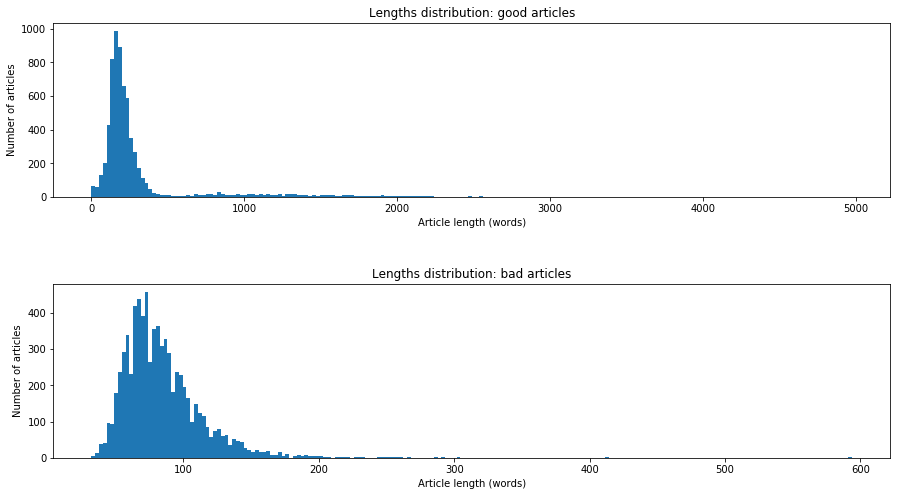

In [3]:
# visualization
plt.figure().set_size_inches(15, 8)

plt.subplot(211)
plt.xlabel('Article length (words)')
plt.ylabel('Number of articles')
plt.title(f'Lengths distribution: {corpora[0].label} articles')
plt.hist(lengths[0], 200)

plt.subplots_adjust(hspace=.5)

plt.subplot(212)
plt.xlabel('Article length (words)')
plt.ylabel('Number of articles')
plt.title(f'Lengths distribution: {corpora[1].label} articles')
plt.hist(lengths[1], 200)

plt.show()

### Building a dictionary

In [3]:
validation_size = 20 # articles per each class
vocabulary_size = 25000

def build_dictionary(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 

  return dictionary, reverse_dictionary, count

def build_dataset(words, dictionary, count):
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)

  count[0][1] = count[0][1] + unk_count

  return data

# flatten all words into a single bag
all_words = [word for corpus in corpora for words in corpus.articles for word in words]

dictionary, reverse_dictionary, count = build_dictionary(all_words)
good_data = [build_dataset(article, dictionary, count) for article in corpora[0].articles]
bad_data  = [build_dataset(article, dictionary, count) for article in corpora[1].articles]

# Splitting between train and validation datasets
good_train_data = good_data[:-validation_size]
good_validation_data = good_data[-validation_size:]
bad_train_data = bad_data[:-validation_size]
bad_validation_data = bad_data[-validation_size:]
validation_data = [item for ga, ba in zip(good_validation_data, bad_validation_data) for item in [ga, ba]]

print(f"Top popular words counts: {count[:15]}\n")
print(f"Example word: {dictionary['слон']} => {reverse_dictionary[dictionary['слон']]}\n")
print(f'Example data: {good_data[0][:20]}\n')
print(f'Validation sizes split train / validation: {len(good_train_data)} / {len(good_validation_data)}')
print(f'Validation dataset size: {len(validation_data)}')

Top popular words counts: [['UNK', 54385], (',', 191060), ('.', 167323), ('в', 121865), ('num', 70531), ('и', 59470), ('на', 47402), ('с', 26509), ('что', 22411), ('по', 21900), ('эт', 21548), ('не', 21271), ('из', 16381), ('год', 15883), ('он', 14053)]

Example word: 3144 => слон

Example data: [4, 385, 3, 606, 600, 50, 1918, 1257, 10524, 1302, 540, 1, 89, 359, 255, 2110, 49, 999, 1, 6767]

Validation sizes split train / validation: 6646 / 20
Validation dataset size: 40


Below is an **example** of two training batches spat out by `BatchIterator`:

In [4]:
batch_size = 20
good = [1, 0] # Representation of first class
bad  = [0, 1] # Representation of second class

batches = BatchIterator(batch_size, good_train_data, bad_train_data, good, bad)

for i in range(20):
  batch = batches.next()
  if i > 17: print(batch)

batches.rewind()

[[3315, 2421, 0, 2, 48, 2536, 3, 2944, 5207, 20, 4, 87, 473, 1, 113, 3, 1098, 14989, 20, 4], [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
[[87, 2, 347, 1857, 1702, 363, 10311, 1, 105, 254, 11, 6736, 87, 2, 347, 47, 23, 1379, 3, 363], [[1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]], [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]


## 2. LSTM Model

In [5]:
num_nodes = 64 # Dimension of lstm cell
num_classes = 2 # Number of classes among which to predict
embedding_size = 128 # Dimension of a word vector
num_unrollings = 20 # Number of recurrent steps

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, num_classes], -0.1, 0.1))
  b = tf.Variable(tf.zeros([num_classes]))
  # Embeddings
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))


  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    # Create an LSTM cell
    input_gate =  tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)

    return output_gate * tf.tanh(state), state

  # Input data.
  train_inputs         = tf.placeholder(tf.int32, shape=[num_unrollings])
  train_state_cleaners = tf.placeholder(tf.float32, shape=[num_unrollings])
  train_labels         = tf.placeholder(tf.int32, shape=[num_unrollings, num_classes])

  # Unrolled LSTM loop.
  lstm_outputs = list()
  output = saved_output
  state  = saved_state
  lstm_inputs = tf.unstack(tf.nn.embedding_lookup(embeddings, train_inputs)) # ~ (num_unrollings, embedding_size)
  lstm_state_cleaners = tf.unstack(train_state_cleaners)

  for lstm_input, state_cleaner in zip(lstm_inputs, lstm_state_cleaners):
    reshaped_lstm_input = tf.reshape(lstm_input, (1, embedding_size))
    output, state = lstm_cell(reshaped_lstm_input,
                              tf.multiply(state_cleaner, output),
                              tf.multiply(state_cleaner, state))
    lstm_outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(lstm_outputs, 0), w, b) # ~ (num_unrollings, num_classes)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
      labels=train_labels,
      logits=logits
    ))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    5.0, global_step, 4000, 0.6, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)

  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.int32, shape=[1])
  sample_lstm_input = tf.nn.embedding_lookup(embeddings, sample_input)
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_lstm_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

## 3. Training

### Representation helpers

Before we dive into the very learning - let us define some useful helpers to better represent training process.

In [6]:
def print_md(string):
  display(Markdown(string))

def colored_p(text, prediction):
  g, r = [round(probability * 255) for probability in prediction]
  return f"<span style='color: rgb({r}, {g}, 0)'>{text}</span>"

def represent(words, predictions, tail=3):
  result = []
  temp = []
  changed_ago = 0
  for word, label, i in zip(words, predictions, range(len(words))):
    word_to_add = colored_p(word, label)

    if i == 0:
      temp.append(word_to_add)
      continue

    if label_to_color(predictions[i - 1]) == label_to_color(label):
      temp.append(word_to_add)
    else:
      if len(temp) > tail * 2:
        result += temp[:tail] + ['...'] + temp[-tail:]
      else:
        result += temp
      temp = [word_to_add]

  if len(temp) > tail * 2:
    result += temp[:tail] + ['...'] + temp[-tail:]
  else:
    result += temp

  overall_label = colored_p('=>', predictions[-1])
  article = " ".join(result)

  return f"{overall_label} {article}"

def label_to_color(label):
  if abs(label[0] - label[1]) < 0.2: color = 'black'
  elif label[0] > label[1]:          color = 'green'
  else:                              color = 'red'

  return color

def colored(text, color='black'):
  colors = { 'black':'30',
             'red':'31',
             'green':'32',
             'yellow':'33',
             'blue':'34',
             'purple':'35',
             'sea-blue':'36' }

  return f"\x1b[{colors[color]}m{text}\x1b[0m"


def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

### Training process

In [7]:
num_steps = 30001
summary_frequency = 100
validation_frequencies = [1000, 5000, 30000]

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  losses = []
  perpls = []
  for step in range(num_steps):
    batch = batches.next()
    feed_dict = { train_inputs: batch[0],
                  train_labels: batch[1],
                  train_state_cleaners: batch[2] }
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l

    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      labels = np.array(batch[1])
      perpl = float(np.exp(logprob(predictions, labels)))
      print(
        'Average loss at step %d: %.4f, perplexity: %.2f, learning rate: %.4f' % (step, mean_loss, perpl, lr))

      losses.append(mean_loss)
      perpls.append(perpl)
      mean_loss = 0

      if step in validation_frequencies:
        print('=' * 80)
        for article in validation_data:
          reset_sample_state.run()
          predicted = []
          article_as_words = []
          for word in article:
            article_as_words.append(reverse_dictionary[word])
            prediction = sample_prediction.eval({ sample_input: [word] })
            predicted.append(prediction[0])

          print_md(represent(article_as_words, predicted))

        print('=' * 80)

Initialized
Average loss at step 0: 0.7306, perplexity: 2.08, learning rate: 5.0000
Average loss at step 100: 0.1256, perplexity: 1.00, learning rate: 5.0000
Average loss at step 200: 0.0007, perplexity: 1.00, learning rate: 5.0000
Average loss at step 300: 0.2868, perplexity: 1.00, learning rate: 5.0000
Average loss at step 400: 0.2966, perplexity: 1.01, learning rate: 5.0000
Average loss at step 500: 0.0023, perplexity: 1.00, learning rate: 5.0000
Average loss at step 600: 0.2041, perplexity: 1.00, learning rate: 5.0000
Average loss at step 700: 0.1769, perplexity: 1.01, learning rate: 5.0000
Average loss at step 800: 0.0447, perplexity: 1.00, learning rate: 5.0000
Average loss at step 900: 0.1008, perplexity: 1.00, learning rate: 5.0000
Average loss at step 1000: 0.2129, perplexity: 1.00, learning rate: 5.0000


<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>в</span> <span style='color: rgb(0.0, 255.0, 0)'>конц</span> <span style='color: rgb(1.0, 254.0, 0)'>феврал</span> ... <span style='color: rgb(1.0, 254.0, 0)'>и</span> <span style='color: rgb(0.0, 255.0, 0)'>казан</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>дом</span> <span style='color: rgb(0.0, 255.0, 0)'>обруш</span> <span style='color: rgb(0.0, 255.0, 0)'>под</span> ... <span style='color: rgb(1.0, 254.0, 0)'>в</span> <span style='color: rgb(0.0, 255.0, 0)'>сообщен</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>воздухоплавател</span> <span style='color: rgb(0.0, 255.0, 0)'>федор</span> <span style='color: rgb(1.0, 254.0, 0)'>конюхов</span> ... <span style='color: rgb(0.0, 255.0, 0)'>num</span> <span style='color: rgb(1.0, 254.0, 0)'>минут</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(2.0, 253.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>жертв</span> <span style='color: rgb(0.0, 255.0, 0)'>урага</span> <span style='color: rgb(1.0, 254.0, 0)'>харв</span> ... <span style='color: rgb(0.0, 255.0, 0)'>рассказа</span> <span style='color: rgb(1.0, 254.0, 0)'>о</span> <span style='color: rgb(2.0, 253.0, 0)'>кошмар</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(2.0, 253.0, 0)'>москв</span> <span style='color: rgb(1.0, 254.0, 0)'>и</span> <span style='color: rgb(1.0, 254.0, 0)'>симферопол</span> ... <span style='color: rgb(1.0, 254.0, 0)'>и</span> <span style='color: rgb(7.0, 248.0, 0)'>вен</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(2.0, 253.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>герман</span> <span style='color: rgb(1.0, 254.0, 0)'>предлож</span> <span style='color: rgb(1.0, 254.0, 0)'>сша</span> ... <span style='color: rgb(0.0, 255.0, 0)'>рассказа</span> <span style='color: rgb(1.0, 254.0, 0)'>о</span> <span style='color: rgb(2.0, 253.0, 0)'>кошмар</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>в</span> <span style='color: rgb(1.0, 254.0, 0)'>феврал</span> <span style='color: rgb(0.0, 255.0, 0)'>наибольш</span> ... <span style='color: rgb(1.0, 254.0, 0)'>и</span> <span style='color: rgb(2.0, 253.0, 0)'>итал</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(7.0, 248.0, 0)'>сконча</span> <span style='color: rgb(1.0, 254.0, 0)'>в</span> <span style='color: rgb(2.0, 253.0, 0)'>москв</span> ... <span style='color: rgb(12.0, 243.0, 0)'>сообщ</span> <span style='color: rgb(2.0, 253.0, 0)'>источник</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>путешеств</span> <span style='color: rgb(4.0, 251.0, 0)'>с</span> <span style='color: rgb(12.0, 243.0, 0)'>домашн</span> ... <span style='color: rgb(0.0, 255.0, 0)'>треб</span> <span style='color: rgb(0.0, 255.0, 0)'>прав</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>в</span> <span style='color: rgb(0.0, 255.0, 0)'>мексиканск</span> <span style='color: rgb(0.0, 255.0, 0)'>залив</span> ... <span style='color: rgb(0.0, 255.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>г</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>президент</span> <span style='color: rgb(1.0, 254.0, 0)'>русск</span> <span style='color: rgb(1.0, 254.0, 0)'>географическ</span> ... <span style='color: rgb(0.0, 255.0, 0)'>поручен</span> <span style='color: rgb(1.0, 254.0, 0)'>шойг</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>в</span> <span style='color: rgb(5.0, 250.0, 0)'>атлантическ</span> <span style='color: rgb(1.0, 254.0, 0)'>океан</span> ... <span style='color: rgb(0.0, 255.0, 0)'>сообща</span> <span style='color: rgb(0.0, 255.0, 0)'>эксперт</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>в</span> <span style='color: rgb(1.0, 254.0, 0)'>амстердамск</span> <span style='color: rgb(1.0, 254.0, 0)'>аэропорт</span> ... <span style='color: rgb(0.0, 255.0, 0)'>отпечатк</span> <span style='color: rgb(0.0, 255.0, 0)'>пальц</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(2.0, 253.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>сотрудник</span> <span style='color: rgb(1.0, 254.0, 0)'>госдепартамент</span> <span style='color: rgb(1.0, 254.0, 0)'>сша</span> ... <span style='color: rgb(0.0, 255.0, 0)'>рассказа</span> <span style='color: rgb(1.0, 254.0, 0)'>о</span> <span style='color: rgb(2.0, 253.0, 0)'>кошмар</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>в</span> <span style='color: rgb(0.0, 255.0, 0)'>начал</span> <span style='color: rgb(1.0, 254.0, 0)'>феврал</span> ... <span style='color: rgb(0.0, 255.0, 0)'>num</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span> <span style='color: rgb(11.0, 244.0, 0)'>тепер</span> <span style='color: rgb(168.0, 87.0, 0)'>мест</span> <span style='color: rgb(1.0, 254.0, 0)'>в</span> <span style='color: rgb(1.0, 254.0, 0)'>экономкласс</span> <span style='color: rgb(2.0, 253.0, 0)'>меньш</span> ... <span style='color: rgb(0.0, 255.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>кресел</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>во</span> <span style='color: rgb(1.0, 254.0, 0)'>флорид</span> <span style='color: rgb(0.0, 255.0, 0)'>наблюда</span> ... <span style='color: rgb(1.0, 254.0, 0)'>и</span> <span style='color: rgb(1.0, 254.0, 0)'>барж</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>на</span> <span style='color: rgb(1.0, 254.0, 0)'>фестивал</span> <span style='color: rgb(4.0, 251.0, 0)'>уличн</span> ... <span style='color: rgb(1.0, 254.0, 0)'>соб</span> <span style='color: rgb(0.0, 255.0, 0)'>размер</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>урага</span> <span style='color: rgb(1.0, 254.0, 0)'>ирм</span> <span style='color: rgb(1.0, 254.0, 0)'>разруш</span> ... <span style='color: rgb(1.0, 254.0, 0)'>местн</span> <span style='color: rgb(1.0, 254.0, 0)'>совет</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>российск</span> <span style='color: rgb(0.0, 255.0, 0)'>воздухоплавател</span> <span style='color: rgb(0.0, 255.0, 0)'>федор</span> ... <span style='color: rgb(0.0, 255.0, 0)'>принадлежа</span> <span style='color: rgb(0.0, 255.0, 0)'>им</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>глав</span> <span style='color: rgb(0.0, 255.0, 0)'>минобрнаук</span> <span style='color: rgb(0.0, 255.0, 0)'>стреля</span> ... <span style='color: rgb(0.0, 255.0, 0)'>сказа</span> <span style='color: rgb(0.0, 255.0, 0)'>васильев</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>пожил</span> <span style='color: rgb(1.0, 254.0, 0)'>жительниц</span> <span style='color: rgb(0.0, 255.0, 0)'>штат</span> ... <span style='color: rgb(2.0, 253.0, 0)'>регион</span> <span style='color: rgb(1.0, 254.0, 0)'>стран</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>num</span> <span style='color: rgb(6.0, 249.0, 0)'>тысяч</span> <span style='color: rgb(2.0, 253.0, 0)'>жител</span> ... <span style='color: rgb(3.0, 252.0, 0)'>губернатор</span> <span style='color: rgb(0.0, 255.0, 0)'>телеканал</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>федор</span> <span style='color: rgb(0.0, 255.0, 0)'>конюх</span> <span style='color: rgb(2.0, 253.0, 0)'>соверш</span> ... <span style='color: rgb(0.0, 255.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>год</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>в</span> <span style='color: rgb(1.0, 254.0, 0)'>атлант</span> <span style='color: rgb(0.0, 255.0, 0)'>застрел</span> ... <span style='color: rgb(0.0, 255.0, 0)'>,</span> <span style='color: rgb(1.0, 254.0, 0)'>неизвестн</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>британск</span> <span style='color: rgb(1.0, 254.0, 0)'>совет</span> <span style='color: rgb(0.0, 255.0, 0)'>совместн</span> ... <span style='color: rgb(1.0, 254.0, 0)'>и</span> <span style='color: rgb(0.0, 255.0, 0)'>репортаж</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>москвич</span> <span style='color: rgb(1.0, 254.0, 0)'>четверт</span> <span style='color: rgb(0.0, 255.0, 0)'>ден</span> ... <span style='color: rgb(0.0, 255.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>раз</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>воздушн</span> <span style='color: rgb(1.0, 254.0, 0)'>шар</span> <span style='color: rgb(6.0, 249.0, 0)'>с</span> ... <span style='color: rgb(0.0, 255.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>час</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>один</span> <span style='color: rgb(1.0, 254.0, 0)'>из</span> <span style='color: rgb(0.0, 255.0, 0)'>num</span> ... <span style='color: rgb(0.0, 255.0, 0)'>бригад</span> <span style='color: rgb(1.0, 254.0, 0)'>UNK</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>петербургск</span> <span style='color: rgb(1.0, 254.0, 0)'>аэропорт</span> <span style='color: rgb(0.0, 255.0, 0)'>пулков</span> ... <span style='color: rgb(1.0, 254.0, 0)'>и</span> <span style='color: rgb(10.0, 245.0, 0)'>лондон</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>банд</span> <span style='color: rgb(1.0, 254.0, 0)'>из</span> <span style='color: rgb(0.0, 255.0, 0)'>num</span> ... <span style='color: rgb(0.0, 255.0, 0)'>вооруж</span> <span style='color: rgb(1.0, 254.0, 0)'>палк</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>поездк</span> <span style='color: rgb(1.0, 254.0, 0)'>в</span> <span style='color: rgb(1.0, 254.0, 0)'>риг</span> ... <span style='color: rgb(2.0, 253.0, 0)'>вам</span> <span style='color: rgb(3.0, 252.0, 0)'>надолг</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>следств</span> <span style='color: rgb(1.0, 254.0, 0)'>прос</span> <span style='color: rgb(0.0, 255.0, 0)'>об</span> ... <span style='color: rgb(1.0, 254.0, 0)'>и</span> <span style='color: rgb(1.0, 254.0, 0)'>халатн</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>лиссабон</span> <span style='color: rgb(0.0, 255.0, 0)'>,</span> <span style='color: rgb(0.0, 255.0, 0)'>как</span> ... <span style='color: rgb(7.0, 248.0, 0)'>тысяч</span> <span style='color: rgb(3.0, 252.0, 0)'>рубл</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>в</span> <span style='color: rgb(1.0, 254.0, 0)'>смоленск</span> <span style='color: rgb(0.0, 255.0, 0)'>област</span> ... <span style='color: rgb(0.0, 255.0, 0)'>инцидент</span> <span style='color: rgb(0.0, 255.0, 0)'>уточня</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>в</span> <span style='color: rgb(0.0, 255.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>е</span> ... <span style='color: rgb(0.0, 255.0, 0)'>параметр</span> <span style='color: rgb(0.0, 255.0, 0)'>друг</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>урага</span> <span style='color: rgb(1.0, 254.0, 0)'>ирм</span> <span style='color: rgb(1.0, 254.0, 0)'>лиш</span> ... <span style='color: rgb(0.0, 255.0, 0)'>сам</span> <span style='color: rgb(1.0, 254.0, 0)'>траектор</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>экономик</span> <span style='color: rgb(1.0, 254.0, 0)'>не</span> <span style='color: rgb(1.0, 254.0, 0)'>работа</span> ... <span style='color: rgb(0.0, 255.0, 0)'>себ</span> <span style='color: rgb(1.0, 254.0, 0)'>UNK</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>в</span> <span style='color: rgb(1.0, 254.0, 0)'>погон</span> <span style='color: rgb(3.0, 252.0, 0)'>со</span> ... <span style='color: rgb(0.0, 255.0, 0)'>серг</span> <span style='color: rgb(0.0, 255.0, 0)'>казаков</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>пномпен</span> <span style='color: rgb(0.0, 255.0, 0)'>город</span> <span style='color: rgb(0.0, 255.0, 0)'>,</span> ... <span style='color: rgb(0.0, 255.0, 0)'>плат</span> <span style='color: rgb(0.0, 255.0, 0)'>отдельн</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(1.0, 254.0, 0)'>в</span> <span style='color: rgb(0.0, 255.0, 0)'>центр</span> <span style='color: rgb(0.0, 255.0, 0)'>тбилис</span> ... <span style='color: rgb(1.0, 254.0, 0)'>цел</span> <span style='color: rgb(4.0, 251.0, 0)'>ограблен</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

Average loss at step 1100: 0.1495, perplexity: 1.00, learning rate: 5.0000
Average loss at step 1200: 0.1064, perplexity: 1.00, learning rate: 5.0000
Average loss at step 1300: 0.1622, perplexity: 7.68, learning rate: 5.0000
Average loss at step 1400: 0.1314, perplexity: 1.00, learning rate: 5.0000
Average loss at step 1500: 0.1678, perplexity: 1.00, learning rate: 5.0000
Average loss at step 1600: 0.1389, perplexity: 1.00, learning rate: 5.0000
Average loss at step 1700: 0.0948, perplexity: 1.00, learning rate: 5.0000
Average loss at step 1800: 0.1551, perplexity: 1.00, learning rate: 5.0000
Average loss at step 1900: 0.1363, perplexity: 1.00, learning rate: 5.0000
Average loss at step 2000: 0.1506, perplexity: 1.01, learning rate: 5.0000
Average loss at step 2100: 0.3881, perplexity: 5.85, learning rate: 5.0000
Average loss at step 2200: 0.1023, perplexity: 1.01, learning rate: 5.0000
Average loss at step 2300: 0.1750, perplexity: 1.00, learning rate: 5.0000
Average loss at step 2400

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(206.0, 49.0, 0)'>в</span> <span style='color: rgb(186.0, 69.0, 0)'>конц</span> <span style='color: rgb(208.0, 47.0, 0)'>феврал</span> <span style='color: rgb(251.0, 4.0, 0)'>в</span> <span style='color: rgb(251.0, 4.0, 0)'>москв</span> <span style='color: rgb(150.0, 105.0, 0)'>заработа</span> <span style='color: rgb(30.0, 225.0, 0)'>перв</span> <span style='color: rgb(204.0, 51.0, 0)'>в</span> <span style='color: rgb(110.0, 145.0, 0)'>мир</span> <span style='color: rgb(165.0, 90.0, 0)'>гаджет</span> <span style='color: rgb(243.0, 12.0, 0)'>рестора</span> <span style='color: rgb(235.0, 20.0, 0)'>.</span> <span style='color: rgb(151.0, 104.0, 0)'>об</span> <span style='color: rgb(9.0, 246.0, 0)'>эт</span> <span style='color: rgb(54.0, 201.0, 0)'>сообща</span> <span style='color: rgb(78.0, 177.0, 0)'>на</span> <span style='color: rgb(48.0, 207.0, 0)'>сайт</span> <span style='color: rgb(20.0, 235.0, 0)'>заведен</span> <span style='color: rgb(59.0, 196.0, 0)'>.</span> <span style='color: rgb(105.0, 150.0, 0)'>откроет</span> <span style='color: rgb(71.0, 184.0, 0)'>на</span> <span style='color: rgb(23.0, 232.0, 0)'>тверск</span> <span style='color: rgb(18.0, 237.0, 0)'>улиц</span> ... <span style='color: rgb(1.0, 254.0, 0)'>,</span> <span style='color: rgb(24.0, 231.0, 0)'>в</span> <span style='color: rgb(46.0, 209.0, 0)'>мен</span> <span style='color: rgb(209.0, 46.0, 0)'>рестора</span> <span style='color: rgb(247.0, 8.0, 0)'>будут</span> <span style='color: rgb(205.0, 50.0, 0)'>так</span> <span style='color: rgb(229.0, 26.0, 0)'>коктейл</span> <span style='color: rgb(112.0, 143.0, 0)'>,</span> <span style='color: rgb(55.0, 200.0, 0)'>как</span> <span style='color: rgb(8.0, 247.0, 0)'>син</span> <span style='color: rgb(35.0, 220.0, 0)'>экра</span> ... <span style='color: rgb(12.0, 243.0, 0)'>UNK</span> <span style='color: rgb(5.0, 250.0, 0)'>.</span> <span style='color: rgb(54.0, 201.0, 0)'>как</span> <span style='color: rgb(199.0, 56.0, 0)'>отмеча</span> <span style='color: rgb(0.0, 255.0, 0)'>на</span> <span style='color: rgb(5.0, 250.0, 0)'>сайт</span> <span style='color: rgb(1.0, 254.0, 0)'>проект</span> ... <span style='color: rgb(88.0, 167.0, 0)'>реализац</span> <span style='color: rgb(34.0, 221.0, 0)'>задумк</span> <span style='color: rgb(42.0, 213.0, 0)'>уж</span> <span style='color: rgb(118.0, 137.0, 0)'>был</span> <span style='color: rgb(39.0, 216.0, 0)'>влож</span> <span style='color: rgb(44.0, 211.0, 0)'>бол</span> <span style='color: rgb(6.0, 249.0, 0)'>миллион</span> ... <span style='color: rgb(0.0, 255.0, 0)'>и</span> <span style='color: rgb(0.0, 255.0, 0)'>казан</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 0.0, 0)'>=></span> <span style='color: rgb(240.0, 15.0, 0)'>дом</span> <span style='color: rgb(226.0, 29.0, 0)'>обруш</span> <span style='color: rgb(209.0, 46.0, 0)'>под</span> <span style='color: rgb(19.0, 236.0, 0)'>краснодар</span> <span style='color: rgb(95.0, 160.0, 0)'>из</span> <span style='color: rgb(182.0, 73.0, 0)'>за</span> <span style='color: rgb(153.0, 102.0, 0)'>самодельн</span> <span style='color: rgb(193.0, 62.0, 0)'>UNK</span> <span style='color: rgb(188.0, 67.0, 0)'>.</span> <span style='color: rgb(94.0, 161.0, 0)'>как</span> <span style='color: rgb(255.0, 0.0, 0)'>сообщ</span> <span style='color: rgb(254.0, 1.0, 0)'>в</span> <span style='color: rgb(251.0, 4.0, 0)'>следствен</span> <span style='color: rgb(254.0, 1.0, 0)'>комитет</span> <span style='color: rgb(32.0, 223.0, 0)'>росс</span> <span style='color: rgb(226.0, 29.0, 0)'>по</span> <span style='color: rgb(229.0, 26.0, 0)'>краснодарск</span> <span style='color: rgb(241.0, 14.0, 0)'>кра</span> ... <span style='color: rgb(254.0, 1.0, 0)'>.</span> <span style='color: rgb(254.0, 1.0, 0)'>причин</span> <span style='color: rgb(252.0, 3.0, 0)'>чп</span> <span style='color: rgb(150.0, 105.0, 0)'>стал</span> <span style='color: rgb(249.0, 6.0, 0)'>установк</span> <span style='color: rgb(255.0, 0.0, 0)'>в</span> <span style='color: rgb(253.0, 2.0, 0)'>дом</span> ... <span style='color: rgb(254.0, 1.0, 0)'>с</span> <span style='color: rgb(240.0, 15.0, 0)'>травм</span> <span style='color: rgb(239.0, 16.0, 0)'>,</span> <span style='color: rgb(152.0, 103.0, 0)'>говор</span> <span style='color: rgb(252.0, 3.0, 0)'>в</span> <span style='color: rgb(250.0, 5.0, 0)'>сообщен</span> <span style='color: rgb(255.0, 0.0, 0)'>.</span>

<span style='color: rgb(2.0, 253.0, 0)'>=></span> <span style='color: rgb(5.0, 250.0, 0)'>воздухоплавател</span> <span style='color: rgb(5.0, 250.0, 0)'>федор</span> <span style='color: rgb(5.0, 250.0, 0)'>конюхов</span> ... <span style='color: rgb(0.0, 255.0, 0)'>воздух</span> <span style='color: rgb(2.0, 253.0, 0)'>бол</span> <span style='color: rgb(13.0, 242.0, 0)'>num</span> <span style='color: rgb(204.0, 51.0, 0)'>час</span> <span style='color: rgb(20.0, 235.0, 0)'>.</span> <span style='color: rgb(12.0, 243.0, 0)'>об</span> <span style='color: rgb(1.0, 254.0, 0)'>эт</span> ... <span style='color: rgb(13.0, 242.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>километр</span> <span style='color: rgb(1.0, 254.0, 0)'>в</span> <span style='color: rgb(209.0, 46.0, 0)'>час</span> <span style='color: rgb(21.0, 234.0, 0)'>.</span> <span style='color: rgb(9.0, 246.0, 0)'>по</span> <span style='color: rgb(161.0, 94.0, 0)'>состоян</span> <span style='color: rgb(64.0, 191.0, 0)'>на</span> <span style='color: rgb(134.0, 121.0, 0)'>num</span> <span style='color: rgb(125.0, 130.0, 0)'>num</span> <span style='color: rgb(69.0, 186.0, 0)'>мск</span> <span style='color: rgb(155.0, 100.0, 0)'>num</span> <span style='color: rgb(133.0, 122.0, 0)'>феврал</span> <span style='color: rgb(112.0, 143.0, 0)'>путешественник</span> <span style='color: rgb(80.0, 175.0, 0)'>пролетел</span> <span style='color: rgb(126.0, 129.0, 0)'>поселок</span> <span style='color: rgb(11.0, 244.0, 0)'>UNK</span> <span style='color: rgb(99.0, 156.0, 0)'>в</span> <span style='color: rgb(226.0, 29.0, 0)'>рязанск</span> <span style='color: rgb(243.0, 12.0, 0)'>област</span> <span style='color: rgb(252.0, 3.0, 0)'>и</span> <span style='color: rgb(250.0, 5.0, 0)'>движут</span> <span style='color: rgb(255.0, 0.0, 0)'>в</span> <span style='color: rgb(74.0, 181.0, 0)'>сторон</span> <span style='color: rgb(246.0, 9.0, 0)'>мордов</span> <span style='color: rgb(229.0, 26.0, 0)'>.</span> <span style='color: rgb(151.0, 104.0, 0)'>наблюда</span> <span style='color: rgb(251.0, 4.0, 0)'>за</span> <span style='color: rgb(147.0, 108.0, 0)'>траектор</span> <span style='color: rgb(139.0, 116.0, 0)'>движен</span> <span style='color: rgb(220.0, 35.0, 0)'>шар</span> <span style='color: rgb(230.0, 25.0, 0)'>в</span> <span style='color: rgb(242.0, 13.0, 0)'>режим</span> ... <span style='color: rgb(255.0, 0.0, 0)'>времен</span> <span style='color: rgb(245.0, 10.0, 0)'>можн</span> <span style='color: rgb(249.0, 6.0, 0)'>на</span> <span style='color: rgb(124.0, 131.0, 0)'>специальн</span> <span style='color: rgb(2.0, 253.0, 0)'>созда</span> <span style='color: rgb(0.0, 255.0, 0)'>сайт</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span> ... <span style='color: rgb(1.0, 254.0, 0)'>и</span> <span style='color: rgb(11.0, 244.0, 0)'>меняйл</span> <span style='color: rgb(7.0, 248.0, 0)'>отправ</span> <span style='color: rgb(251.0, 4.0, 0)'>в</span> <span style='color: rgb(94.0, 161.0, 0)'>полет</span> <span style='color: rgb(15.0, 240.0, 0)'>на</span> <span style='color: rgb(226.0, 29.0, 0)'>аэростат</span> <span style='color: rgb(10.0, 245.0, 0)'>бинбанк</span> <span style='color: rgb(62.0, 193.0, 0)'>премиум</span> <span style='color: rgb(102.0, 153.0, 0)'>,</span> <span style='color: rgb(107.0, 148.0, 0)'>котор</span> <span style='color: rgb(0.0, 255.0, 0)'>явля</span> <span style='color: rgb(0.0, 255.0, 0)'>сам</span> <span style='color: rgb(0.0, 255.0, 0)'>больш</span> ... <span style='color: rgb(74.0, 181.0, 0)'>num</span> <span style='color: rgb(17.0, 238.0, 0)'>минут</span> <span style='color: rgb(2.0, 253.0, 0)'>.</span>

<span style='color: rgb(2.0, 253.0, 0)'>=></span> <span style='color: rgb(53.0, 202.0, 0)'>жертв</span> <span style='color: rgb(78.0, 177.0, 0)'>урага</span> <span style='color: rgb(12.0, 243.0, 0)'>харв</span> <span style='color: rgb(36.0, 219.0, 0)'>в</span> <span style='color: rgb(81.0, 174.0, 0)'>техас</span> <span style='color: rgb(168.0, 87.0, 0)'>числ</span> <span style='color: rgb(193.0, 62.0, 0)'>уж</span> <span style='color: rgb(182.0, 73.0, 0)'>num</span> <span style='color: rgb(239.0, 16.0, 0)'>человек</span> <span style='color: rgb(243.0, 12.0, 0)'>.</span> <span style='color: rgb(124.0, 131.0, 0)'>как</span> <span style='color: rgb(210.0, 45.0, 0)'>сообща</span> <span style='color: rgb(252.0, 3.0, 0)'>власт</span> <span style='color: rgb(186.0, 69.0, 0)'>американск</span> <span style='color: rgb(29.0, 226.0, 0)'>штат</span> <span style='color: rgb(193.0, 62.0, 0)'>техас</span> <span style='color: rgb(181.0, 74.0, 0)'>,</span> <span style='color: rgb(180.0, 75.0, 0)'>числ</span> ... <span style='color: rgb(247.0, 8.0, 0)'>урага</span> <span style='color: rgb(211.0, 44.0, 0)'>харв</span> <span style='color: rgb(221.0, 34.0, 0)'>увелич</span> <span style='color: rgb(17.0, 238.0, 0)'>до</span> <span style='color: rgb(57.0, 198.0, 0)'>num</span> <span style='color: rgb(84.0, 171.0, 0)'>человек</span> <span style='color: rgb(221.0, 34.0, 0)'>.</span> <span style='color: rgb(238.0, 17.0, 0)'>по</span> <span style='color: rgb(168.0, 87.0, 0)'>уточнен</span> ... <span style='color: rgb(253.0, 2.0, 0)'>выж</span> <span style='color: rgb(251.0, 4.0, 0)'>в</span> <span style='color: rgb(235.0, 20.0, 0)'>ураган</span> <span style='color: rgb(22.0, 233.0, 0)'>ирм</span> <span style='color: rgb(15.0, 240.0, 0)'>журналистк</span> <span style='color: rgb(7.0, 248.0, 0)'>рассказа</span> <span style='color: rgb(12.0, 243.0, 0)'>о</span> <span style='color: rgb(2.0, 253.0, 0)'>кошмар</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(92.0, 163.0, 0)'>москв</span> <span style='color: rgb(21.0, 234.0, 0)'>и</span> <span style='color: rgb(114.0, 141.0, 0)'>симферопол</span> <span style='color: rgb(45.0, 210.0, 0)'>оказа</span> <span style='color: rgb(67.0, 188.0, 0)'>наибол</span> <span style='color: rgb(45.0, 210.0, 0)'>выгодн</span> ... <span style='color: rgb(21.0, 234.0, 0)'>в</span> <span style='color: rgb(42.0, 213.0, 0)'>длин</span> <span style='color: rgb(25.0, 230.0, 0)'>выходн</span> <span style='color: rgb(211.0, 44.0, 0)'>в</span> <span style='color: rgb(204.0, 51.0, 0)'>чест</span> <span style='color: rgb(123.0, 132.0, 0)'>num</span> <span style='color: rgb(228.0, 27.0, 0)'>феврал</span> <span style='color: rgb(216.0, 39.0, 0)'>.</span> <span style='color: rgb(108.0, 147.0, 0)'>об</span> <span style='color: rgb(14.0, 241.0, 0)'>эт</span> <span style='color: rgb(87.0, 168.0, 0)'>сообща</span> <span style='color: rgb(246.0, 9.0, 0)'>в</span> <span style='color: rgb(255.0, 0.0, 0)'>пресс</span> <span style='color: rgb(254.0, 1.0, 0)'>релиз</span> <span style='color: rgb(247.0, 8.0, 0)'>турсервис</span> <span style='color: rgb(97.0, 158.0, 0)'>,</span> <span style='color: rgb(76.0, 179.0, 0)'>поступ</span> <span style='color: rgb(139.0, 116.0, 0)'>в</span> <span style='color: rgb(5.0, 250.0, 0)'>лент</span> <span style='color: rgb(27.0, 228.0, 0)'>.</span> <span style='color: rgb(30.0, 225.0, 0)'>ру</span> ... <span style='color: rgb(5.0, 250.0, 0)'>num</span> <span style='color: rgb(8.0, 247.0, 0)'>феврал</span> <span style='color: rgb(95.0, 160.0, 0)'>.</span> <span style='color: rgb(166.0, 89.0, 0)'>специалист</span> <span style='color: rgb(18.0, 237.0, 0)'>проанализирова</span> <span style='color: rgb(19.0, 236.0, 0)'>десятк</span> <span style='color: rgb(17.0, 238.0, 0)'>тысяч</span> ... <span style='color: rgb(5.0, 250.0, 0)'>и</span> <span style='color: rgb(0.0, 255.0, 0)'>турц</span> <span style='color: rgb(1.0, 254.0, 0)'>,</span> <span style='color: rgb(155.0, 100.0, 0)'>отмеча</span> <span style='color: rgb(16.0, 239.0, 0)'>в</span> <span style='color: rgb(7.0, 248.0, 0)'>.</span> <span style='color: rgb(85.0, 170.0, 0)'>специалист</span> ... <span style='color: rgb(0.0, 255.0, 0)'>и</span> <span style='color: rgb(0.0, 255.0, 0)'>вен</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(199.0, 56.0, 0)'>герман</span> <span style='color: rgb(119.0, 136.0, 0)'>предлож</span> <span style='color: rgb(44.0, 211.0, 0)'>сша</span> <span style='color: rgb(90.0, 165.0, 0)'>помощ</span> <span style='color: rgb(55.0, 200.0, 0)'>посл</span> ... <span style='color: rgb(0.0, 255.0, 0)'>техас</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span> <span style='color: rgb(1.0, 254.0, 0)'>как</span> <span style='color: rgb(142.0, 113.0, 0)'>сообщ</span> <span style='color: rgb(5.0, 250.0, 0)'>официальн</span> <span style='color: rgb(89.0, 166.0, 0)'>представител</span> <span style='color: rgb(103.0, 152.0, 0)'>правительств</span> <span style='color: rgb(182.0, 73.0, 0)'>герман</span> <span style='color: rgb(246.0, 9.0, 0)'>штефф</span> <span style='color: rgb(195.0, 60.0, 0)'>UNK</span> <span style='color: rgb(165.0, 90.0, 0)'>,</span> <span style='color: rgb(12.0, 243.0, 0)'>канцлер</span> <span style='color: rgb(38.0, 217.0, 0)'>фрг</span> <span style='color: rgb(183.0, 72.0, 0)'>ангел</span> <span style='color: rgb(62.0, 193.0, 0)'>меркел</span> <span style='color: rgb(2.0, 253.0, 0)'>направ</span> <span style='color: rgb(2.0, 253.0, 0)'>губернатор</span> ... <span style='color: rgb(0.0, 255.0, 0)'>рассказа</span> <span style='color: rgb(0.0, 255.0, 0)'>о</span> <span style='color: rgb(0.0, 255.0, 0)'>кошмар</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(206.0, 49.0, 0)'>в</span> <span style='color: rgb(205.0, 50.0, 0)'>феврал</span> <span style='color: rgb(219.0, 36.0, 0)'>наибольш</span> <span style='color: rgb(161.0, 94.0, 0)'>спрос</span> <span style='color: rgb(157.0, 98.0, 0)'>у</span> <span style='color: rgb(66.0, 189.0, 0)'>российск</span> <span style='color: rgb(106.0, 149.0, 0)'>путешественник</span> <span style='color: rgb(100.0, 155.0, 0)'>будет</span> <span style='color: rgb(119.0, 136.0, 0)'>пользова</span> <span style='color: rgb(240.0, 15.0, 0)'>таиланд</span> <span style='color: rgb(194.0, 61.0, 0)'>.</span> <span style='color: rgb(50.0, 205.0, 0)'>об</span> <span style='color: rgb(9.0, 246.0, 0)'>эт</span> <span style='color: rgb(1.0, 254.0, 0)'>корреспондент</span> ... <span style='color: rgb(50.0, 205.0, 0)'>отдыха</span> <span style='color: rgb(14.0, 241.0, 0)'>.</span> <span style='color: rgb(3.0, 252.0, 0)'>на</span> <span style='color: rgb(106.0, 149.0, 0)'>втор</span> <span style='color: rgb(174.0, 81.0, 0)'>мест</span> <span style='color: rgb(10.0, 245.0, 0)'>списк</span> <span style='color: rgb(245.0, 10.0, 0)'>из</span> <span style='color: rgb(1.0, 254.0, 0)'>десят</span> <span style='color: rgb(2.0, 253.0, 0)'>позиц</span> <span style='color: rgb(24.0, 231.0, 0)'>оказа</span> ... <span style='color: rgb(3.0, 252.0, 0)'>.</span> <span style='color: rgb(60.0, 195.0, 0)'>в</span> <span style='color: rgb(5.0, 250.0, 0)'>топ</span> <span style='color: rgb(196.0, 59.0, 0)'>num</span> <span style='color: rgb(31.0, 224.0, 0)'>такж</span> <span style='color: rgb(7.0, 248.0, 0)'>вошл</span> <span style='color: rgb(60.0, 195.0, 0)'>тунис</span> ... <span style='color: rgb(1.0, 254.0, 0)'>.</span> <span style='color: rgb(3.0, 252.0, 0)'>ран</span> <span style='color: rgb(12.0, 243.0, 0)'>сообща</span> <span style='color: rgb(169.0, 86.0, 0)'>,</span> <span style='color: rgb(86.0, 169.0, 0)'>что</span> <span style='color: rgb(25.0, 230.0, 0)'>наибол</span> <span style='color: rgb(13.0, 242.0, 0)'>востребова</span> ... <span style='color: rgb(2.0, 253.0, 0)'>россия</span> <span style='color: rgb(14.0, 241.0, 0)'>направлен</span> <span style='color: rgb(87.0, 168.0, 0)'>отдых</span> <span style='color: rgb(220.0, 35.0, 0)'>в</span> <span style='color: rgb(242.0, 13.0, 0)'>num</span> <span style='color: rgb(3.0, 252.0, 0)'>год</span> <span style='color: rgb(0.0, 255.0, 0)'>стал</span> <span style='color: rgb(1.0, 254.0, 0)'>испан</span> <span style='color: rgb(5.0, 250.0, 0)'>.</span> <span style='color: rgb(123.0, 132.0, 0)'>в</span> <span style='color: rgb(173.0, 82.0, 0)'>тройк</span> <span style='color: rgb(17.0, 238.0, 0)'>лидер</span> <span style='color: rgb(26.0, 229.0, 0)'>такж</span> <span style='color: rgb(9.0, 246.0, 0)'>вошл</span> ... <span style='color: rgb(1.0, 254.0, 0)'>и</span> <span style='color: rgb(2.0, 253.0, 0)'>итал</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 0.0, 0)'>=></span> <span style='color: rgb(235.0, 20.0, 0)'>сконча</span> <span style='color: rgb(250.0, 5.0, 0)'>в</span> <span style='color: rgb(241.0, 14.0, 0)'>москв</span> <span style='color: rgb(199.0, 56.0, 0)'>испанск</span> <span style='color: rgb(50.0, 205.0, 0)'>футболист</span> <span style='color: rgb(6.0, 249.0, 0)'>уч</span> <span style='color: rgb(205.0, 50.0, 0)'>в</span> <span style='color: rgb(52.0, 203.0, 0)'>рудн</span> <span style='color: rgb(187.0, 68.0, 0)'>.</span> <span style='color: rgb(78.0, 177.0, 0)'>как</span> <span style='color: rgb(254.0, 1.0, 0)'>сообщ</span> <span style='color: rgb(234.0, 21.0, 0)'>источник</span> <span style='color: rgb(249.0, 6.0, 0)'>,</span> <span style='color: rgb(9.0, 246.0, 0)'>хорош</span> <span style='color: rgb(4.0, 251.0, 0)'>знаком</span> <span style='color: rgb(253.0, 2.0, 0)'>с</span> <span style='color: rgb(82.0, 173.0, 0)'>ситуац</span> <span style='color: rgb(217.0, 38.0, 0)'>,</span> <span style='color: rgb(62.0, 193.0, 0)'>молод</span> <span style='color: rgb(33.0, 222.0, 0)'>человек</span> <span style='color: rgb(247.0, 8.0, 0)'>,</span> <span style='color: rgb(241.0, 14.0, 0)'>сконча</span> <span style='color: rgb(224.0, 31.0, 0)'>во</span> <span style='color: rgb(251.0, 4.0, 0)'>врем</span> <span style='color: rgb(249.0, 6.0, 0)'>футбольн</span> <span style='color: rgb(34.0, 221.0, 0)'>матч</span> <span style='color: rgb(251.0, 4.0, 0)'>в</span> <span style='color: rgb(245.0, 10.0, 0)'>москв</span> <span style='color: rgb(246.0, 9.0, 0)'>,</span> <span style='color: rgb(96.0, 159.0, 0)'>явля</span> <span style='color: rgb(243.0, 12.0, 0)'>студент</span> <span style='color: rgb(74.0, 181.0, 0)'>российск</span> <span style='color: rgb(243.0, 12.0, 0)'>университет</span> <span style='color: rgb(242.0, 13.0, 0)'>дружб</span> <span style='color: rgb(240.0, 15.0, 0)'>народ</span> <span style='color: rgb(254.0, 1.0, 0)'>.</span> <span style='color: rgb(233.0, 22.0, 0)'>num</span> <span style='color: rgb(143.0, 112.0, 0)'>летн</span> <span style='color: rgb(67.0, 188.0, 0)'>уроженец</span> <span style='color: rgb(28.0, 227.0, 0)'>республик</span> <span style='color: rgb(6.0, 249.0, 0)'>сан</span> ... <span style='color: rgb(20.0, 235.0, 0)'>во</span> <span style='color: rgb(26.0, 229.0, 0)'>врем</span> <span style='color: rgb(1.0, 254.0, 0)'>игр</span> <span style='color: rgb(193.0, 62.0, 0)'>в</span> <span style='color: rgb(72.0, 183.0, 0)'>футбол</span> <span style='color: rgb(35.0, 220.0, 0)'>,</span> <span style='color: rgb(27.0, 228.0, 0)'>был</span> <span style='color: rgb(194.0, 61.0, 0)'>студент</span> <span style='color: rgb(35.0, 220.0, 0)'>рудн</span> <span style='color: rgb(135.0, 120.0, 0)'>и</span> <span style='color: rgb(17.0, 238.0, 0)'>прожива</span> <span style='color: rgb(232.0, 23.0, 0)'>в</span> <span style='color: rgb(23.0, 232.0, 0)'>общежит</span> <span style='color: rgb(58.0, 197.0, 0)'>при</span> <span style='color: rgb(213.0, 42.0, 0)'>университет</span> <span style='color: rgb(101.0, 154.0, 0)'>,</span> <span style='color: rgb(255.0, 0.0, 0)'>сообщ</span> <span style='color: rgb(245.0, 10.0, 0)'>источник</span> <span style='color: rgb(255.0, 0.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(25.0, 230.0, 0)'>путешеств</span> <span style='color: rgb(158.0, 97.0, 0)'>с</span> <span style='color: rgb(39.0, 216.0, 0)'>домашн</span> <span style='color: rgb(124.0, 131.0, 0)'>питомц</span> <span style='color: rgb(6.0, 249.0, 0)'>всегд</span> <span style='color: rgb(28.0, 227.0, 0)'>лишн</span> <span style='color: rgb(1.0, 254.0, 0)'>хлопот</span> ... <span style='color: rgb(0.0, 255.0, 0)'>треб</span> <span style='color: rgb(0.0, 255.0, 0)'>прав</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(2.0, 253.0, 0)'>=></span> <span style='color: rgb(206.0, 49.0, 0)'>в</span> <span style='color: rgb(227.0, 28.0, 0)'>мексиканск</span> <span style='color: rgb(172.0, 83.0, 0)'>залив</span> <span style='color: rgb(212.0, 43.0, 0)'>тропическ</span> <span style='color: rgb(62.0, 193.0, 0)'>шторм</span> <span style='color: rgb(9.0, 246.0, 0)'>кат</span> <span style='color: rgb(41.0, 214.0, 0)'>усил</span> ... <span style='color: rgb(12.0, 243.0, 0)'>.</span> <span style='color: rgb(17.0, 238.0, 0)'>как</span> <span style='color: rgb(26.0, 229.0, 0)'>сообща</span> <span style='color: rgb(140.0, 115.0, 0)'>,</span> <span style='color: rgb(12.0, 243.0, 0)'>тропическ</span> <span style='color: rgb(31.0, 224.0, 0)'>шторм</span> <span style='color: rgb(7.0, 248.0, 0)'>кат</span> <span style='color: rgb(8.0, 247.0, 0)'>,</span> <span style='color: rgb(14.0, 241.0, 0)'>сформирова</span> <span style='color: rgb(17.0, 238.0, 0)'>в</span> <span style='color: rgb(173.0, 82.0, 0)'>мексиканск</span> <span style='color: rgb(68.0, 187.0, 0)'>залив</span> <span style='color: rgb(245.0, 10.0, 0)'>,</span> <span style='color: rgb(222.0, 33.0, 0)'>по</span> <span style='color: rgb(48.0, 207.0, 0)'>всем</span> <span style='color: rgb(149.0, 106.0, 0)'>признак</span> <span style='color: rgb(57.0, 198.0, 0)'>усил</span> <span style='color: rgb(17.0, 238.0, 0)'>до</span> <span style='color: rgb(170.0, 85.0, 0)'>урага</span> <span style='color: rgb(213.0, 42.0, 0)'>.</span> <span style='color: rgb(8.0, 247.0, 0)'>тропическ</span> <span style='color: rgb(49.0, 206.0, 0)'>шторм</span> <span style='color: rgb(5.0, 250.0, 0)'>кат</span> ... <span style='color: rgb(18.0, 237.0, 0)'>num</span> <span style='color: rgb(15.0, 240.0, 0)'>г</span> <span style='color: rgb(2.0, 253.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(109.0, 146.0, 0)'>президент</span> <span style='color: rgb(73.0, 182.0, 0)'>русск</span> <span style='color: rgb(122.0, 133.0, 0)'>географическ</span> <span style='color: rgb(81.0, 174.0, 0)'>обществ</span> <span style='color: rgb(24.0, 231.0, 0)'>(</span> <span style='color: rgb(14.0, 241.0, 0)'>рго</span> <span style='color: rgb(25.0, 230.0, 0)'>)</span> <span style='color: rgb(9.0, 246.0, 0)'>и</span> <span style='color: rgb(216.0, 39.0, 0)'>министр</span> <span style='color: rgb(255.0, 0.0, 0)'>оборон</span> <span style='color: rgb(18.0, 237.0, 0)'>росс</span> <span style='color: rgb(88.0, 167.0, 0)'>серг</span> <span style='color: rgb(237.0, 18.0, 0)'>шойг</span> <span style='color: rgb(8.0, 247.0, 0)'>призва</span> <span style='color: rgb(196.0, 59.0, 0)'>развива</span> <span style='color: rgb(38.0, 217.0, 0)'>нов</span> <span style='color: rgb(98.0, 157.0, 0)'>туристическ</span> <span style='color: rgb(40.0, 215.0, 0)'>направлен</span> <span style='color: rgb(36.0, 219.0, 0)'>путешеств</span> <span style='color: rgb(47.0, 208.0, 0)'>по</span> <span style='color: rgb(163.0, 92.0, 0)'>пещер</span> <span style='color: rgb(47.0, 208.0, 0)'>.</span> <span style='color: rgb(50.0, 205.0, 0)'>об</span> <span style='color: rgb(4.0, 251.0, 0)'>эт</span> ... <span style='color: rgb(54.0, 201.0, 0)'>num</span> <span style='color: rgb(72.0, 183.0, 0)'>феврал</span> <span style='color: rgb(75.0, 180.0, 0)'>,</span> <span style='color: rgb(163.0, 92.0, 0)'>сообща</span> <span style='color: rgb(7.0, 248.0, 0)'>агентств</span> <span style='color: rgb(23.0, 232.0, 0)'>городск</span> <span style='color: rgb(0.0, 255.0, 0)'>новост</span> ... <span style='color: rgb(0.0, 255.0, 0)'>поручен</span> <span style='color: rgb(0.0, 255.0, 0)'>шойг</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(243.0, 12.0, 0)'>=></span> <span style='color: rgb(206.0, 49.0, 0)'>в</span> <span style='color: rgb(245.0, 10.0, 0)'>атлантическ</span> <span style='color: rgb(225.0, 30.0, 0)'>океан</span> <span style='color: rgb(166.0, 89.0, 0)'>тропическ</span> <span style='color: rgb(50.0, 205.0, 0)'>шторм</span> <span style='color: rgb(117.0, 138.0, 0)'>хос</span> <span style='color: rgb(1.0, 254.0, 0)'>стал</span> <span style='color: rgb(10.0, 245.0, 0)'>ураган</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span> ... <span style='color: rgb(66.0, 189.0, 0)'>национальн</span> <span style='color: rgb(79.0, 176.0, 0)'>центр</span> <span style='color: rgb(18.0, 237.0, 0)'>сша</span> <span style='color: rgb(162.0, 93.0, 0)'>по</span> <span style='color: rgb(154.0, 101.0, 0)'>предупрежден</span> <span style='color: rgb(102.0, 153.0, 0)'>ураган</span> <span style='color: rgb(3.0, 252.0, 0)'>,</span> <span style='color: rgb(126.0, 129.0, 0)'>тропическ</span> <span style='color: rgb(2.0, 253.0, 0)'>шторм</span> <span style='color: rgb(5.0, 250.0, 0)'>хос</span> <span style='color: rgb(0.0, 255.0, 0)'>,</span> ... <span style='color: rgb(0.0, 255.0, 0)'>хос</span> <span style='color: rgb(15.0, 240.0, 0)'>движет</span> <span style='color: rgb(21.0, 234.0, 0)'>в</span> <span style='color: rgb(202.0, 53.0, 0)'>район</span> <span style='color: rgb(40.0, 215.0, 0)'>стран</span> <span style='color: rgb(79.0, 176.0, 0)'>карибск</span> <span style='color: rgb(125.0, 130.0, 0)'>бассейн</span> <span style='color: rgb(76.0, 179.0, 0)'>со</span> <span style='color: rgb(227.0, 28.0, 0)'>скорост</span> <span style='color: rgb(175.0, 80.0, 0)'>num</span> <span style='color: rgb(13.0, 242.0, 0)'>километр</span> <span style='color: rgb(32.0, 223.0, 0)'>в</span> <span style='color: rgb(231.0, 24.0, 0)'>час</span> <span style='color: rgb(53.0, 202.0, 0)'>,</span> <span style='color: rgb(233.0, 22.0, 0)'>сообща</span> <span style='color: rgb(237.0, 18.0, 0)'>эксперт</span> <span style='color: rgb(243.0, 12.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(206.0, 49.0, 0)'>в</span> <span style='color: rgb(47.0, 208.0, 0)'>амстердамск</span> <span style='color: rgb(38.0, 217.0, 0)'>аэропорт</span> <span style='color: rgb(200.0, 55.0, 0)'>UNK</span> <span style='color: rgb(31.0, 224.0, 0)'>тестир</span> <span style='color: rgb(28.0, 227.0, 0)'>нов</span> <span style='color: rgb(52.0, 203.0, 0)'>сист</span> <span style='color: rgb(74.0, 181.0, 0)'>безопасн</span> <span style='color: rgb(218.0, 37.0, 0)'>с</span> <span style='color: rgb(203.0, 52.0, 0)'>распознаван</span> <span style='color: rgb(223.0, 32.0, 0)'>лиц</span> <span style='color: rgb(244.0, 11.0, 0)'>пассажир</span> <span style='color: rgb(213.0, 42.0, 0)'>.</span> <span style='color: rgb(85.0, 170.0, 0)'>проверя</span> <span style='color: rgb(192.0, 63.0, 0)'>паспорт</span> <span style='color: rgb(152.0, 103.0, 0)'>путешественник</span> <span style='color: rgb(27.0, 228.0, 0)'>ил</span> <span style='color: rgb(1.0, 254.0, 0)'>ег</span> <span style='color: rgb(5.0, 250.0, 0)'>посадочн</span> ... <span style='color: rgb(1.0, 254.0, 0)'>отпечатк</span> <span style='color: rgb(0.0, 255.0, 0)'>пальц</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(20.0, 235.0, 0)'>сотрудник</span> <span style='color: rgb(2.0, 253.0, 0)'>госдепартамент</span> <span style='color: rgb(0.0, 255.0, 0)'>сша</span> ... <span style='color: rgb(0.0, 255.0, 0)'>.</span> <span style='color: rgb(1.0, 254.0, 0)'>как</span> <span style='color: rgb(16.0, 239.0, 0)'>сообща</span> <span style='color: rgb(198.0, 57.0, 0)'>пресс</span> <span style='color: rgb(206.0, 49.0, 0)'>служб</span> <span style='color: rgb(31.0, 224.0, 0)'>американск</span> <span style='color: rgb(152.0, 103.0, 0)'>внешнеполитическ</span> <span style='color: rgb(155.0, 100.0, 0)'>ведомств</span> <span style='color: rgb(62.0, 193.0, 0)'>,</span> <span style='color: rgb(33.0, 222.0, 0)'>все</span> <span style='color: rgb(9.0, 246.0, 0)'>сотрудник</span> ... <span style='color: rgb(29.0, 226.0, 0)'>находя</span> <span style='color: rgb(14.0, 241.0, 0)'>на</span> <span style='color: rgb(54.0, 201.0, 0)'>багамск</span> <span style='color: rgb(104.0, 151.0, 0)'>остров</span> <span style='color: rgb(150.0, 105.0, 0)'>,</span> <span style='color: rgb(187.0, 68.0, 0)'>будут</span> <span style='color: rgb(165.0, 90.0, 0)'>эвакуирова</span> <span style='color: rgb(217.0, 38.0, 0)'>в</span> <span style='color: rgb(214.0, 41.0, 0)'>связ</span> <span style='color: rgb(178.0, 77.0, 0)'>с</span> <span style='color: rgb(234.0, 21.0, 0)'>приближа</span> <span style='color: rgb(93.0, 162.0, 0)'>ураган</span> <span style='color: rgb(215.0, 40.0, 0)'>num</span> <span style='color: rgb(4.0, 251.0, 0)'>ирм</span> <span style='color: rgb(4.0, 251.0, 0)'>.</span> <span style='color: rgb(47.0, 208.0, 0)'>в</span> ... <span style='color: rgb(6.0, 249.0, 0)'>сотрудник</span> <span style='color: rgb(20.0, 235.0, 0)'>правительств</span> <span style='color: rgb(26.0, 229.0, 0)'>сша</span> <span style='color: rgb(111.0, 144.0, 0)'>,</span> <span style='color: rgb(54.0, 201.0, 0)'>есл</span> <span style='color: rgb(9.0, 246.0, 0)'>их</span> <span style='color: rgb(131.0, 124.0, 0)'>присутств</span> <span style='color: rgb(9.0, 246.0, 0)'>не</span> <span style='color: rgb(2.0, 253.0, 0)'>явля</span> <span style='color: rgb(0.0, 255.0, 0)'>обязательн</span> <span style='color: rgb(3.0, 252.0, 0)'>.</span> <span style='color: rgb(2.0, 253.0, 0)'>такж</span> <span style='color: rgb(19.0, 236.0, 0)'>будут</span> <span style='color: rgb(185.0, 70.0, 0)'>эвакуирова</span> <span style='color: rgb(13.0, 242.0, 0)'>член</span> <span style='color: rgb(6.0, 249.0, 0)'>их</span> <span style='color: rgb(0.0, 255.0, 0)'>сем</span> ... <span style='color: rgb(0.0, 255.0, 0)'>рассказа</span> <span style='color: rgb(0.0, 255.0, 0)'>о</span> <span style='color: rgb(0.0, 255.0, 0)'>кошмар</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(206.0, 49.0, 0)'>в</span> <span style='color: rgb(249.0, 6.0, 0)'>начал</span> <span style='color: rgb(249.0, 6.0, 0)'>феврал</span> <span style='color: rgb(254.0, 1.0, 0)'>самолет</span> <span style='color: rgb(102.0, 153.0, 0)'>авиакомпан</span> <span style='color: rgb(249.0, 6.0, 0)'>соверш</span> <span style='color: rgb(22.0, 233.0, 0)'>сам</span> <span style='color: rgb(21.0, 234.0, 0)'>длин</span> <span style='color: rgb(128.0, 127.0, 0)'>в</span> <span style='color: rgb(2.0, 253.0, 0)'>мир</span> <span style='color: rgb(52.0, 203.0, 0)'>коммерческ</span> <span style='color: rgb(3.0, 252.0, 0)'>рейс</span> ... <span style='color: rgb(4.0, 251.0, 0)'>эт</span> <span style='color: rgb(9.0, 246.0, 0)'>врем</span> <span style='color: rgb(38.0, 217.0, 0)'>лайнер</span> <span style='color: rgb(190.0, 65.0, 0)'>пролета</span> <span style='color: rgb(183.0, 72.0, 0)'>num</span> <span style='color: rgb(171.0, 84.0, 0)'>num</span> <span style='color: rgb(42.0, 213.0, 0)'>километр</span> <span style='color: rgb(87.0, 168.0, 0)'>.</span> <span style='color: rgb(186.0, 69.0, 0)'>в</span> <span style='color: rgb(5.0, 250.0, 0)'>салон</span> <span style='color: rgb(205.0, 50.0, 0)'>num</span> <span style='color: rgb(193.0, 62.0, 0)'>num</span> <span style='color: rgb(177.0, 78.0, 0)'>мест</span> <span style='color: rgb(183.0, 72.0, 0)'>экономкласс</span> <span style='color: rgb(113.0, 142.0, 0)'>и</span> <span style='color: rgb(57.0, 198.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>бизнес</span> <span style='color: rgb(70.0, 185.0, 0)'>класс</span> <span style='color: rgb(6.0, 249.0, 0)'>.</span> <span style='color: rgb(19.0, 236.0, 0)'>вылет</span> <span style='color: rgb(219.0, 36.0, 0)'>из</span> <span style='color: rgb(90.0, 165.0, 0)'>аэропорт</span> <span style='color: rgb(14.0, 241.0, 0)'>дох</span> <span style='color: rgb(42.0, 213.0, 0)'>в</span> <span style='color: rgb(154.0, 101.0, 0)'>num</span> <span style='color: rgb(147.0, 108.0, 0)'>num</span> <span style='color: rgb(25.0, 230.0, 0)'>по</span> <span style='color: rgb(102.0, 153.0, 0)'>местн</span> <span style='color: rgb(101.0, 154.0, 0)'>времен</span> <span style='color: rgb(67.0, 188.0, 0)'>.</span> <span style='color: rgb(122.0, 133.0, 0)'>в</span> <span style='color: rgb(137.0, 118.0, 0)'>соста</span> <span style='color: rgb(41.0, 214.0, 0)'>экипаж</span> <span style='color: rgb(2.0, 253.0, 0)'>вход</span> <span style='color: rgb(202.0, 53.0, 0)'>num</span> <span style='color: rgb(80.0, 175.0, 0)'>пилот</span> <span style='color: rgb(244.0, 11.0, 0)'>и</span> <span style='color: rgb(209.0, 46.0, 0)'>num</span> <span style='color: rgb(69.0, 186.0, 0)'>бортпроводник</span> <span style='color: rgb(25.0, 230.0, 0)'>.</span> <span style='color: rgb(147.0, 108.0, 0)'>за</span> <span style='color: rgb(111.0, 144.0, 0)'>врем</span> <span style='color: rgb(86.0, 169.0, 0)'>полет</span> <span style='color: rgb(221.0, 34.0, 0)'>пассажир</span> <span style='color: rgb(63.0, 192.0, 0)'>выпива</span> <span style='color: rgb(39.0, 216.0, 0)'>бол</span> <span style='color: rgb(3.0, 252.0, 0)'>тысяч</span> ... <span style='color: rgb(5.0, 250.0, 0)'>num</span> <span style='color: rgb(2.0, 253.0, 0)'>бол</span> <span style='color: rgb(4.0, 251.0, 0)'>num</span> <span style='color: rgb(220.0, 35.0, 0)'>час</span> <span style='color: rgb(71.0, 184.0, 0)'>полет</span> <span style='color: rgb(102.0, 153.0, 0)'>нелегк</span> <span style='color: rgb(210.0, 45.0, 0)'>испытан</span> <span style='color: rgb(11.0, 244.0, 0)'>для</span> <span style='color: rgb(1.0, 254.0, 0)'>пассажир</span> <span style='color: rgb(1.0, 254.0, 0)'>,</span> ... <span style='color: rgb(74.0, 181.0, 0)'>час</span> <span style='color: rgb(76.0, 179.0, 0)'>времен</span> <span style='color: rgb(72.0, 183.0, 0)'>в</span> <span style='color: rgb(227.0, 28.0, 0)'>пут</span> <span style='color: rgb(144.0, 111.0, 0)'>.</span> <span style='color: rgb(168.0, 87.0, 0)'>к</span> <span style='color: rgb(56.0, 199.0, 0)'>том</span> <span style='color: rgb(2.0, 253.0, 0)'>же</span> <span style='color: rgb(139.0, 116.0, 0)'>лета</span> <span style='color: rgb(240.0, 15.0, 0)'>пассажир</span> <span style='color: rgb(87.0, 168.0, 0)'>с</span> <span style='color: rgb(45.0, 210.0, 0)'>комфорт</span> <span style='color: rgb(61.0, 194.0, 0)'>а</span> <span style='color: rgb(46.0, 209.0, 0)'>num</span> <span style='color: rgb(197.0, 58.0, 0)'>сконструирова</span> <span style='color: rgb(5.0, 250.0, 0)'>специальн</span> <span style='color: rgb(0.0, 255.0, 0)'>для</span> <span style='color: rgb(0.0, 255.0, 0)'>UNK</span> ... <span style='color: rgb(53.0, 202.0, 0)'>в</span> <span style='color: rgb(0.0, 255.0, 0)'>окленд</span> <span style='color: rgb(63.0, 192.0, 0)'>в</span> <span style='color: rgb(208.0, 47.0, 0)'>num</span> <span style='color: rgb(204.0, 51.0, 0)'>num</span> <span style='color: rgb(1.0, 254.0, 0)'>на</span> <span style='color: rgb(5.0, 250.0, 0)'>след</span> <span style='color: rgb(0.0, 255.0, 0)'>ден</span> ... <span style='color: rgb(4.0, 251.0, 0)'>ест</span> <span style='color: rgb(5.0, 250.0, 0)'>удобн</span> <span style='color: rgb(3.0, 252.0, 0)'>стыковк</span> <span style='color: rgb(106.0, 149.0, 0)'>в</span> <span style='color: rgb(138.0, 117.0, 0)'>дуба</span> <span style='color: rgb(228.0, 27.0, 0)'>продолжительн</span> <span style='color: rgb(23.0, 232.0, 0)'>три</span> <span style='color: rgb(207.0, 48.0, 0)'>четыр</span> <span style='color: rgb(237.0, 18.0, 0)'>час</span> <span style='color: rgb(223.0, 32.0, 0)'>,</span> <span style='color: rgb(163.0, 92.0, 0)'>так</span> <span style='color: rgb(39.0, 216.0, 0)'>образ</span> <span style='color: rgb(63.0, 192.0, 0)'>,</span> <span style='color: rgb(48.0, 207.0, 0)'>вся</span> ... <span style='color: rgb(26.0, 229.0, 0)'>в</span> <span style='color: rgb(8.0, 247.0, 0)'>средн</span> <span style='color: rgb(56.0, 199.0, 0)'>num</span> <span style='color: rgb(237.0, 18.0, 0)'>час</span> <span style='color: rgb(158.0, 97.0, 0)'>.</span> <span style='color: rgb(48.0, 207.0, 0)'>правд</span> <span style='color: rgb(37.0, 218.0, 0)'>,</span> <span style='color: rgb(80.0, 175.0, 0)'>удовольств</span> ... <span style='color: rgb(8.0, 247.0, 0)'>(</span> <span style='color: rgb(40.0, 215.0, 0)'>num</span> <span style='color: rgb(93.0, 162.0, 0)'>час</span> <span style='color: rgb(127.0, 128.0, 0)'>num</span> <span style='color: rgb(49.0, 206.0, 0)'>минут</span> <span style='color: rgb(25.0, 230.0, 0)'>по</span> <span style='color: rgb(201.0, 54.0, 0)'>зимн</span> <span style='color: rgb(143.0, 112.0, 0)'>расписан</span> <span style='color: rgb(22.0, 233.0, 0)'>)</span> <span style='color: rgb(172.0, 83.0, 0)'>самолет</span> <span style='color: rgb(131.0, 124.0, 0)'>num</span> <span style='color: rgb(144.0, 111.0, 0)'>num</span> <span style='color: rgb(6.0, 249.0, 0)'>эт</span> <span style='color: rgb(60.0, 195.0, 0)'>единствен</span> <span style='color: rgb(112.0, 143.0, 0)'>беспосадочн</span> <span style='color: rgb(11.0, 244.0, 0)'>рейс</span> <span style='color: rgb(26.0, 229.0, 0)'>межд</span> <span style='color: rgb(3.0, 252.0, 0)'>австрал</span> ... <span style='color: rgb(12.0, 243.0, 0)'>сша</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span> <span style='color: rgb(10.0, 245.0, 0)'>самолет</span> <span style='color: rgb(168.0, 87.0, 0)'>лета</span> <span style='color: rgb(252.0, 3.0, 0)'>шест</span> <span style='color: rgb(55.0, 200.0, 0)'>раз</span> <span style='color: rgb(252.0, 3.0, 0)'>в</span> <span style='color: rgb(252.0, 3.0, 0)'>недел</span> <span style='color: rgb(29.0, 226.0, 0)'>кажд</span> <span style='color: rgb(0.0, 255.0, 0)'>ден</span> <span style='color: rgb(1.0, 254.0, 0)'>,</span> ... <span style='color: rgb(0.0, 255.0, 0)'>ест</span> <span style='color: rgb(18.0, 237.0, 0)'>мест</span> <span style='color: rgb(37.0, 218.0, 0)'>четырех</span> <span style='color: rgb(128.0, 127.0, 0)'>класс</span> <span style='color: rgb(27.0, 228.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>отдельн</span> <span style='color: rgb(0.0, 255.0, 0)'>кабин</span> ... <span style='color: rgb(1.0, 254.0, 0)'>изображ</span> <span style='color: rgb(42.0, 213.0, 0)'>в</span> <span style='color: rgb(47.0, 208.0, 0)'>ковбойск</span> <span style='color: rgb(106.0, 149.0, 0)'>шляп</span> <span style='color: rgb(6.0, 249.0, 0)'>и</span> <span style='color: rgb(11.0, 244.0, 0)'>звездн</span> <span style='color: rgb(4.0, 251.0, 0)'>полосат</span> ... <span style='color: rgb(0.0, 255.0, 0)'>лайнер</span> <span style='color: rgb(7.0, 248.0, 0)'>в</span> <span style='color: rgb(49.0, 206.0, 0)'>стандартн</span> <span style='color: rgb(137.0, 118.0, 0)'>UNK</span> <span style='color: rgb(134.0, 121.0, 0)'>.</span> <span style='color: rgb(16.0, 239.0, 0)'>кто</span> <span style='color: rgb(1.0, 254.0, 0)'>выполня</span> <span style='color: rgb(41.0, 214.0, 0)'>,</span> ... <span style='color: rgb(12.0, 243.0, 0)'>в</span> <span style='color: rgb(3.0, 252.0, 0)'>полет</span> <span style='color: rgb(25.0, 230.0, 0)'>num</span> <span style='color: rgb(190.0, 65.0, 0)'>час</span> <span style='color: rgb(156.0, 99.0, 0)'>num</span> <span style='color: rgb(100.0, 155.0, 0)'>минут</span> <span style='color: rgb(57.0, 198.0, 0)'>(</span> <span style='color: rgb(115.0, 140.0, 0)'>num</span> <span style='color: rgb(224.0, 31.0, 0)'>час</span> <span style='color: rgb(163.0, 92.0, 0)'>num</span> <span style='color: rgb(140.0, 115.0, 0)'>минут</span> <span style='color: rgb(80.0, 175.0, 0)'>по</span> <span style='color: rgb(231.0, 24.0, 0)'>зимн</span> <span style='color: rgb(166.0, 89.0, 0)'>расписан</span> <span style='color: rgb(61.0, 194.0, 0)'>)</span> <span style='color: rgb(240.0, 15.0, 0)'>самолет</span> <span style='color: rgb(141.0, 114.0, 0)'>num</span> <span style='color: rgb(153.0, 102.0, 0)'>num</span> <span style='color: rgb(152.0, 103.0, 0)'>num</span> <span style='color: rgb(152.0, 103.0, 0)'>num</span> <span style='color: rgb(254.0, 1.0, 0)'>пассажир</span> <span style='color: rgb(211.0, 44.0, 0)'>,</span> <span style='color: rgb(182.0, 73.0, 0)'>котор</span> <span style='color: rgb(145.0, 110.0, 0)'>лет</span> <span style='color: rgb(251.0, 4.0, 0)'>из</span> <span style='color: rgb(215.0, 40.0, 0)'>сан</span> <span style='color: rgb(129.0, 126.0, 0)'>франциск</span> <span style='color: rgb(245.0, 10.0, 0)'>в</span> <span style='color: rgb(251.0, 4.0, 0)'>сингапур</span> <span style='color: rgb(248.0, 7.0, 0)'>,</span> <span style='color: rgb(2.0, 253.0, 0)'>участв</span> <span style='color: rgb(124.0, 131.0, 0)'>в</span> <span style='color: rgb(91.0, 164.0, 0)'>интересн</span> <span style='color: rgb(52.0, 203.0, 0)'>игр</span> <span style='color: rgb(80.0, 175.0, 0)'>со</span> <span style='color: rgb(238.0, 17.0, 0)'>времен</span> <span style='color: rgb(243.0, 12.0, 0)'>из</span> <span style='color: rgb(249.0, 6.0, 0)'>за</span> ... <span style='color: rgb(220.0, 35.0, 0)'>пояс</span> <span style='color: rgb(163.0, 92.0, 0)'>.</span> <span style='color: rgb(211.0, 44.0, 0)'>по</span> <span style='color: rgb(152.0, 103.0, 0)'>пут</span> <span style='color: rgb(166.0, 89.0, 0)'>из</span> <span style='color: rgb(252.0, 3.0, 0)'>сша</span> <span style='color: rgb(254.0, 1.0, 0)'>в</span> <span style='color: rgb(147.0, 108.0, 0)'>аз</span> <span style='color: rgb(8.0, 247.0, 0)'>он</span> <span style='color: rgb(183.0, 72.0, 0)'>незаметн</span> <span style='color: rgb(242.0, 13.0, 0)'>для</span> <span style='color: rgb(186.0, 69.0, 0)'>себ</span> <span style='color: rgb(159.0, 96.0, 0)'>теря</span> <span style='color: rgb(16.0, 239.0, 0)'>почт</span> <span style='color: rgb(134.0, 121.0, 0)'>два</span> <span style='color: rgb(13.0, 242.0, 0)'>дня</span> <span style='color: rgb(129.0, 126.0, 0)'>вылета</span> <span style='color: rgb(241.0, 14.0, 0)'>в</span> <span style='color: rgb(168.0, 87.0, 0)'>num</span> <span style='color: rgb(167.0, 88.0, 0)'>num</span> ... <span style='color: rgb(216.0, 39.0, 0)'>а</span> <span style='color: rgb(254.0, 1.0, 0)'>в</span> <span style='color: rgb(180.0, 75.0, 0)'>аэропорт</span> <span style='color: rgb(97.0, 158.0, 0)'>чанг</span> <span style='color: rgb(232.0, 23.0, 0)'>приземля</span> <span style='color: rgb(251.0, 4.0, 0)'>в</span> <span style='color: rgb(226.0, 29.0, 0)'>num</span> ... <span style='color: rgb(241.0, 14.0, 0)'>времен</span> <span style='color: rgb(233.0, 22.0, 0)'>,</span> <span style='color: rgb(173.0, 82.0, 0)'>но</span> <span style='color: rgb(71.0, 184.0, 0)'>на</span> <span style='color: rgb(196.0, 59.0, 0)'>два</span> <span style='color: rgb(238.0, 17.0, 0)'>час</span> <span style='color: rgb(201.0, 54.0, 0)'>позж</span> ... <span style='color: rgb(227.0, 28.0, 0)'>и</span> <span style='color: rgb(253.0, 2.0, 0)'>приземлен</span> <span style='color: rgb(254.0, 1.0, 0)'>в</span> <span style='color: rgb(100.0, 155.0, 0)'>штат</span> <span style='color: rgb(254.0, 1.0, 0)'>в</span> <span style='color: rgb(199.0, 56.0, 0)'>num</span> <span style='color: rgb(203.0, 52.0, 0)'>num</span> ... <span style='color: rgb(228.0, 27.0, 0)'>,</span> <span style='color: rgb(250.0, 5.0, 0)'>конечн</span> <span style='color: rgb(253.0, 2.0, 0)'>,</span> <span style='color: rgb(94.0, 161.0, 0)'>num</span> <span style='color: rgb(205.0, 50.0, 0)'>час</span> <span style='color: rgb(240.0, 15.0, 0)'>в</span> <span style='color: rgb(155.0, 100.0, 0)'>полет</span> <span style='color: rgb(229.0, 26.0, 0)'>)</span> <span style='color: rgb(245.0, 10.0, 0)'>.</span> <span style='color: rgb(240.0, 15.0, 0)'>кто</span> <span style='color: rgb(94.0, 161.0, 0)'>выполня</span> <span style='color: rgb(79.0, 176.0, 0)'>номер</span> <span style='color: rgb(34.0, 221.0, 0)'>рейс</span> <span style='color: rgb(10.0, 245.0, 0)'>num</span> <span style='color: rgb(27.0, 228.0, 0)'>запущ</span> <span style='color: rgb(185.0, 70.0, 0)'>в</span> <span style='color: rgb(41.0, 214.0, 0)'>июн</span> <span style='color: rgb(15.0, 240.0, 0)'>num</span> <span style='color: rgb(198.0, 57.0, 0)'>годаврем</span> <span style='color: rgb(248.0, 7.0, 0)'>в</span> <span style='color: rgb(173.0, 82.0, 0)'>полет</span> <span style='color: rgb(132.0, 123.0, 0)'>num</span> <span style='color: rgb(253.0, 2.0, 0)'>час</span> <span style='color: rgb(197.0, 58.0, 0)'>num</span> <span style='color: rgb(250.0, 5.0, 0)'>минут</span> ... <span style='color: rgb(254.0, 1.0, 0)'>течен</span> <span style='color: rgb(239.0, 16.0, 0)'>полет</span> <span style='color: rgb(192.0, 63.0, 0)'>сменя</span> <span style='color: rgb(128.0, 127.0, 0)'>друг</span> <span style='color: rgb(54.0, 201.0, 0)'>друг</span> <span style='color: rgb(71.0, 184.0, 0)'>.</span> <span style='color: rgb(44.0, 211.0, 0)'>на</span> <span style='color: rgb(74.0, 181.0, 0)'>num</span> <span style='color: rgb(224.0, 31.0, 0)'>час</span> <span style='color: rgb(193.0, 62.0, 0)'>полет</span> <span style='color: rgb(67.0, 188.0, 0)'>самолет</span> <span style='color: rgb(29.0, 226.0, 0)'>треб</span> <span style='color: rgb(43.0, 212.0, 0)'>бол</span> <span style='color: rgb(126.0, 129.0, 0)'>num</span> <span style='color: rgb(100.0, 155.0, 0)'>тысяч</span> <span style='color: rgb(119.0, 136.0, 0)'>литр</span> <span style='color: rgb(98.0, 157.0, 0)'>топлив</span> <span style='color: rgb(49.0, 206.0, 0)'>.</span> <span style='color: rgb(130.0, 125.0, 0)'>авиакомпан</span> <span style='color: rgb(47.0, 208.0, 0)'>обнародова</span> <span style='color: rgb(5.0, 250.0, 0)'>занимательн</span> <span style='color: rgb(16.0, 239.0, 0)'>статистик</span> ... <span style='color: rgb(11.0, 244.0, 0)'>оаэ</span> <span style='color: rgb(0.0, 255.0, 0)'>снача</span> <span style='color: rgb(62.0, 193.0, 0)'>лета</span> <span style='color: rgb(232.0, 23.0, 0)'>num</span> <span style='color: rgb(226.0, 29.0, 0)'>num</span> <span style='color: rgb(180.0, 75.0, 0)'>котор</span> <span style='color: rgb(26.0, 229.0, 0)'>вмеща</span> <span style='color: rgb(226.0, 29.0, 0)'>num</span> <span style='color: rgb(19.0, 236.0, 0)'>пассажир</span> <span style='color: rgb(56.0, 199.0, 0)'>(</span> <span style='color: rgb(125.0, 130.0, 0)'>num</span> <span style='color: rgb(40.0, 215.0, 0)'>в</span> <span style='color: rgb(1.0, 254.0, 0)'>перв</span> <span style='color: rgb(150.0, 105.0, 0)'>класс</span> <span style='color: rgb(210.0, 45.0, 0)'>,</span> <span style='color: rgb(109.0, 146.0, 0)'>num</span> <span style='color: rgb(39.0, 216.0, 0)'>в</span> <span style='color: rgb(0.0, 255.0, 0)'>бизнес</span> <span style='color: rgb(13.0, 242.0, 0)'>и</span> ... <span style='color: rgb(17.0, 238.0, 0)'>в</span> <span style='color: rgb(19.0, 236.0, 0)'>эконом</span> <span style='color: rgb(12.0, 243.0, 0)'>)</span> <span style='color: rgb(149.0, 106.0, 0)'>,</span> <span style='color: rgb(4.0, 251.0, 0)'>но</span> <span style='color: rgb(3.0, 252.0, 0)'>уж</span> <span style='color: rgb(33.0, 222.0, 0)'>в</span> <span style='color: rgb(8.0, 247.0, 0)'>июл</span> <span style='color: rgb(145.0, 110.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>год</span> <span style='color: rgb(5.0, 250.0, 0)'>замен</span> <span style='color: rgb(0.0, 255.0, 0)'>ег</span> ... <span style='color: rgb(14.0, 241.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>кресел</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(19.0, 236.0, 0)'>=></span> <span style='color: rgb(187.0, 68.0, 0)'>во</span> <span style='color: rgb(80.0, 175.0, 0)'>флорид</span> <span style='color: rgb(130.0, 125.0, 0)'>наблюда</span> <span style='color: rgb(169.0, 86.0, 0)'>перебо</span> <span style='color: rgb(253.0, 2.0, 0)'>с</span> <span style='color: rgb(253.0, 2.0, 0)'>бензин</span> <span style='color: rgb(184.0, 71.0, 0)'>и</span> <span style='color: rgb(145.0, 110.0, 0)'>очеред</span> <span style='color: rgb(251.0, 4.0, 0)'>к</span> <span style='color: rgb(87.0, 168.0, 0)'>заправк</span> <span style='color: rgb(104.0, 151.0, 0)'>.</span> <span style='color: rgb(212.0, 43.0, 0)'>в</span> <span style='color: rgb(119.0, 136.0, 0)'>американск</span> <span style='color: rgb(8.0, 247.0, 0)'>штат</span> <span style='color: rgb(16.0, 239.0, 0)'>флорид</span> <span style='color: rgb(65.0, 190.0, 0)'>,</span> <span style='color: rgb(200.0, 55.0, 0)'>где</span> <span style='color: rgb(191.0, 64.0, 0)'>проход</span> <span style='color: rgb(15.0, 240.0, 0)'>подготовк</span> <span style='color: rgb(17.0, 238.0, 0)'>к</span> <span style='color: rgb(12.0, 243.0, 0)'>ураган</span> ... <span style='color: rgb(0.0, 255.0, 0)'>,</span> <span style='color: rgb(1.0, 254.0, 0)'>наблюда</span> <span style='color: rgb(20.0, 235.0, 0)'>перебо</span> <span style='color: rgb(189.0, 66.0, 0)'>с</span> <span style='color: rgb(2.0, 253.0, 0)'>доставк</span> <span style='color: rgb(11.0, 244.0, 0)'>топлив</span> <span style='color: rgb(28.0, 227.0, 0)'>и</span> ... <span style='color: rgb(28.0, 227.0, 0)'>.</span> <span style='color: rgb(98.0, 157.0, 0)'>возросш</span> <span style='color: rgb(60.0, 195.0, 0)'>из</span> <span style='color: rgb(237.0, 18.0, 0)'>за</span> <span style='color: rgb(240.0, 15.0, 0)'>эвакуац</span> <span style='color: rgb(46.0, 209.0, 0)'>населен</span> <span style='color: rgb(158.0, 97.0, 0)'>нагрузк</span> <span style='color: rgb(121.0, 134.0, 0)'>на</span> <span style='color: rgb(246.0, 9.0, 0)'>дорог</span> <span style='color: rgb(3.0, 252.0, 0)'>стал</span> <span style='color: rgb(31.0, 224.0, 0)'>главн</span> <span style='color: rgb(246.0, 9.0, 0)'>причин</span> <span style='color: rgb(212.0, 43.0, 0)'>перебо</span> <span style='color: rgb(252.0, 3.0, 0)'>.</span> <span style='color: rgb(255.0, 0.0, 0)'>в</span> <span style='color: rgb(13.0, 242.0, 0)'>штат</span> <span style='color: rgb(97.0, 158.0, 0)'>нет</span> <span style='color: rgb(43.0, 212.0, 0)'>нефтеперерабатыва</span> <span style='color: rgb(94.0, 161.0, 0)'>завод</span> <span style='color: rgb(168.0, 87.0, 0)'>,</span> <span style='color: rgb(114.0, 141.0, 0)'>поэт</span> <span style='color: rgb(7.0, 248.0, 0)'>населен</span> <span style='color: rgb(9.0, 246.0, 0)'>полност</span> <span style='color: rgb(1.0, 254.0, 0)'>завис</span> ... <span style='color: rgb(25.0, 230.0, 0)'>и</span> <span style='color: rgb(15.0, 240.0, 0)'>барж</span> <span style='color: rgb(19.0, 236.0, 0)'>.</span>

<span style='color: rgb(213.0, 42.0, 0)'>=></span> <span style='color: rgb(9.0, 246.0, 0)'>на</span> <span style='color: rgb(0.0, 255.0, 0)'>фестивал</span> <span style='color: rgb(0.0, 255.0, 0)'>уличн</span> ... <span style='color: rgb(9.0, 246.0, 0)'>num</span> <span style='color: rgb(84.0, 171.0, 0)'>каратн</span> <span style='color: rgb(97.0, 158.0, 0)'>съедобн</span> <span style='color: rgb(116.0, 139.0, 0)'>золот</span> <span style='color: rgb(36.0, 219.0, 0)'>.</span> <span style='color: rgb(14.0, 241.0, 0)'>нов</span> <span style='color: rgb(139.0, 116.0, 0)'>блюд</span> <span style='color: rgb(202.0, 53.0, 0)'>получ</span> <span style='color: rgb(136.0, 119.0, 0)'>назван</span> <span style='color: rgb(191.0, 64.0, 0)'>бурдж</span> <span style='color: rgb(83.0, 172.0, 0)'>халиф</span> <span style='color: rgb(253.0, 2.0, 0)'>в</span> <span style='color: rgb(247.0, 8.0, 0)'>чест</span> <span style='color: rgb(205.0, 50.0, 0)'>одноимен</span> ... <span style='color: rgb(254.0, 1.0, 0)'>в</span> <span style='color: rgb(249.0, 6.0, 0)'>дуба</span> <span style='color: rgb(252.0, 3.0, 0)'>,</span> <span style='color: rgb(105.0, 150.0, 0)'>явля</span> <span style='color: rgb(46.0, 209.0, 0)'>сам</span> <span style='color: rgb(38.0, 217.0, 0)'>высок</span> <span style='color: rgb(192.0, 63.0, 0)'>сооружен</span> <span style='color: rgb(242.0, 13.0, 0)'>в</span> <span style='color: rgb(30.0, 225.0, 0)'>мир</span> <span style='color: rgb(139.0, 116.0, 0)'>.</span> <span style='color: rgb(3.0, 252.0, 0)'>фестивал</span> <span style='color: rgb(10.0, 245.0, 0)'>пройдет</span> <span style='color: rgb(200.0, 55.0, 0)'>с</span> <span style='color: rgb(61.0, 194.0, 0)'>num</span> <span style='color: rgb(214.0, 41.0, 0)'>по</span> <span style='color: rgb(116.0, 139.0, 0)'>num</span> <span style='color: rgb(219.0, 36.0, 0)'>феврал</span> <span style='color: rgb(224.0, 31.0, 0)'>.</span> <span style='color: rgb(254.0, 1.0, 0)'>в</span> <span style='color: rgb(207.0, 48.0, 0)'>январ</span> <span style='color: rgb(27.0, 228.0, 0)'>стал</span> <span style='color: rgb(252.0, 3.0, 0)'>известн</span> <span style='color: rgb(209.0, 46.0, 0)'>,</span> <span style='color: rgb(164.0, 91.0, 0)'>что</span> <span style='color: rgb(101.0, 154.0, 0)'>макдоналдс</span> <span style='color: rgb(206.0, 49.0, 0)'>вперв</span> <span style='color: rgb(241.0, 14.0, 0)'>за</span> <span style='color: rgb(139.0, 116.0, 0)'>num</span> <span style='color: rgb(43.0, 212.0, 0)'>лет</span> <span style='color: rgb(207.0, 48.0, 0)'>с</span> <span style='color: rgb(6.0, 249.0, 0)'>момент</span> <span style='color: rgb(5.0, 250.0, 0)'>создан</span> <span style='color: rgb(1.0, 254.0, 0)'>биг</span> ... <span style='color: rgb(23.0, 232.0, 0)'>.</span> <span style='color: rgb(1.0, 254.0, 0)'>два</span> <span style='color: rgb(5.0, 250.0, 0)'>бургер</span> <span style='color: rgb(131.0, 124.0, 0)'>отлича</span> <span style='color: rgb(24.0, 231.0, 0)'>межд</span> <span style='color: rgb(8.0, 247.0, 0)'>соб</span> <span style='color: rgb(163.0, 92.0, 0)'>размер</span> <span style='color: rgb(213.0, 42.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(51.0, 204.0, 0)'>урага</span> <span style='color: rgb(2.0, 253.0, 0)'>ирм</span> <span style='color: rgb(9.0, 246.0, 0)'>разруш</span> ... <span style='color: rgb(5.0, 250.0, 0)'>сен</span> <span style='color: rgb(7.0, 248.0, 0)'>март</span> <span style='color: rgb(74.0, 181.0, 0)'>.</span> <span style='color: rgb(162.0, 93.0, 0)'>как</span> <span style='color: rgb(253.0, 2.0, 0)'>переда</span> <span style='color: rgb(158.0, 97.0, 0)'>со</span> <span style='color: rgb(135.0, 120.0, 0)'>ссылк</span> <span style='color: rgb(9.0, 246.0, 0)'>на</span> <span style='color: rgb(57.0, 198.0, 0)'>местн</span> <span style='color: rgb(1.0, 254.0, 0)'>власт</span> <span style='color: rgb(32.0, 223.0, 0)'>,</span> <span style='color: rgb(126.0, 129.0, 0)'>шест</span> <span style='color: rgb(190.0, 65.0, 0)'>человек</span> <span style='color: rgb(52.0, 203.0, 0)'>погибл</span> <span style='color: rgb(114.0, 141.0, 0)'>из</span> <span style='color: rgb(158.0, 97.0, 0)'>за</span> <span style='color: rgb(185.0, 70.0, 0)'>урага</span> <span style='color: rgb(15.0, 240.0, 0)'>ирм</span> <span style='color: rgb(15.0, 240.0, 0)'>на</span> <span style='color: rgb(44.0, 211.0, 0)'>французск</span> ... <span style='color: rgb(4.0, 251.0, 0)'>остров</span> <span style='color: rgb(5.0, 250.0, 0)'>сен</span> <span style='color: rgb(9.0, 246.0, 0)'>март</span> <span style='color: rgb(179.0, 76.0, 0)'>в</span> <span style='color: rgb(41.0, 214.0, 0)'>карибск</span> <span style='color: rgb(75.0, 180.0, 0)'>мор</span> <span style='color: rgb(57.0, 198.0, 0)'>.</span> ... <span style='color: rgb(82.0, 173.0, 0)'>здан</span> <span style='color: rgb(52.0, 203.0, 0)'>разруш</span> <span style='color: rgb(33.0, 222.0, 0)'>.</span> <span style='color: rgb(252.0, 3.0, 0)'>глав</span> <span style='color: rgb(172.0, 83.0, 0)'>местн</span> <span style='color: rgb(13.0, 242.0, 0)'>совет</span> <span style='color: rgb(5.0, 250.0, 0)'>назва</span> <span style='color: rgb(8.0, 247.0, 0)'>произошедш</span> ... <span style='color: rgb(24.0, 231.0, 0)'>местн</span> <span style='color: rgb(1.0, 254.0, 0)'>совет</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(12.0, 243.0, 0)'>российск</span> <span style='color: rgb(2.0, 253.0, 0)'>воздухоплавател</span> <span style='color: rgb(1.0, 254.0, 0)'>федор</span> ... <span style='color: rgb(1.0, 254.0, 0)'>.</span> <span style='color: rgb(14.0, 241.0, 0)'>утр</span> <span style='color: rgb(24.0, 231.0, 0)'>в</span> <span style='color: rgb(118.0, 137.0, 0)'>сред</span> <span style='color: rgb(55.0, 200.0, 0)'>,</span> <span style='color: rgb(90.0, 165.0, 0)'>num</span> <span style='color: rgb(14.0, 241.0, 0)'>феврал</span> <span style='color: rgb(122.0, 133.0, 0)'>,</span> <span style='color: rgb(18.0, 237.0, 0)'>конюхов</span> <span style='color: rgb(49.0, 206.0, 0)'>и</span> <span style='color: rgb(34.0, 221.0, 0)'>меняйл</span> ... <span style='color: rgb(52.0, 203.0, 0)'>рекорд</span> <span style='color: rgb(6.0, 249.0, 0)'>был</span> <span style='color: rgb(0.0, 255.0, 0)'>установл</span> <span style='color: rgb(132.0, 123.0, 0)'>в</span> <span style='color: rgb(45.0, 210.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>год</span> <span style='color: rgb(3.0, 252.0, 0)'>и</span> ... <span style='color: rgb(0.0, 255.0, 0)'>принадлежа</span> <span style='color: rgb(0.0, 255.0, 0)'>им</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(245.0, 10.0, 0)'>глав</span> <span style='color: rgb(212.0, 43.0, 0)'>минобрнаук</span> <span style='color: rgb(241.0, 14.0, 0)'>стреля</span> ... <span style='color: rgb(253.0, 2.0, 0)'>пол</span> <span style='color: rgb(211.0, 44.0, 0)'>восточн</span> <span style='color: rgb(178.0, 77.0, 0)'>экономическ</span> <span style='color: rgb(39.0, 216.0, 0)'>форум</span> <span style='color: rgb(205.0, 50.0, 0)'>прокомментирова</span> <span style='color: rgb(246.0, 9.0, 0)'>инцидент</span> <span style='color: rgb(247.0, 8.0, 0)'>в</span> ... <span style='color: rgb(239.0, 16.0, 0)'>школ</span> <span style='color: rgb(251.0, 4.0, 0)'>.</span> <span style='color: rgb(249.0, 6.0, 0)'>по</span> <span style='color: rgb(123.0, 132.0, 0)'>е</span> <span style='color: rgb(171.0, 84.0, 0)'>мнен</span> <span style='color: rgb(236.0, 19.0, 0)'>,</span> <span style='color: rgb(99.0, 156.0, 0)'>откр</span> <span style='color: rgb(235.0, 20.0, 0)'>стрельб</span> <span style='color: rgb(254.0, 1.0, 0)'>подросток</span> <span style='color: rgb(248.0, 7.0, 0)'>нужда</span> ... <span style='color: rgb(244.0, 11.0, 0)'>,</span> <span style='color: rgb(214.0, 41.0, 0)'>котор</span> <span style='color: rgb(251.0, 4.0, 0)'>ем</span> <span style='color: rgb(127.0, 128.0, 0)'>не</span> <span style='color: rgb(244.0, 11.0, 0)'>оказа</span> <span style='color: rgb(245.0, 10.0, 0)'>ни</span> <span style='color: rgb(218.0, 37.0, 0)'>родител</span> <span style='color: rgb(163.0, 92.0, 0)'>,</span> <span style='color: rgb(29.0, 226.0, 0)'>ни</span> <span style='color: rgb(28.0, 227.0, 0)'>школ</span> <span style='color: rgb(167.0, 88.0, 0)'>.</span> <span style='color: rgb(96.0, 159.0, 0)'>о</span> <span style='color: rgb(108.0, 147.0, 0)'>сво</span> <span style='color: rgb(216.0, 39.0, 0)'>план</span> <span style='color: rgb(0.0, 255.0, 0)'>он</span> <span style='color: rgb(213.0, 42.0, 0)'>писа</span> <span style='color: rgb(156.0, 99.0, 0)'>в</span> <span style='color: rgb(234.0, 21.0, 0)'>соцсет</span> <span style='color: rgb(180.0, 75.0, 0)'>.</span> <span style='color: rgb(233.0, 22.0, 0)'>в</span> <span style='color: rgb(109.0, 146.0, 0)'>связ</span> <span style='color: rgb(223.0, 32.0, 0)'>с</span> <span style='color: rgb(110.0, 145.0, 0)'>эт</span> <span style='color: rgb(120.0, 135.0, 0)'>ольг</span> <span style='color: rgb(77.0, 178.0, 0)'>васильев</span> <span style='color: rgb(98.0, 157.0, 0)'>счита</span> <span style='color: rgb(11.0, 244.0, 0)'>,</span> <span style='color: rgb(46.0, 209.0, 0)'>что</span> <span style='color: rgb(247.0, 8.0, 0)'>инцидент</span> <span style='color: rgb(7.0, 248.0, 0)'>стал</span> <span style='color: rgb(2.0, 253.0, 0)'>повод</span> <span style='color: rgb(1.0, 254.0, 0)'>задума</span> ... <span style='color: rgb(0.0, 255.0, 0)'>сказа</span> <span style='color: rgb(0.0, 255.0, 0)'>васильев</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(5.0, 250.0, 0)'>пожил</span> <span style='color: rgb(2.0, 253.0, 0)'>жительниц</span> <span style='color: rgb(6.0, 249.0, 0)'>штат</span> <span style='color: rgb(45.0, 210.0, 0)'>монта</span> <span style='color: rgb(157.0, 98.0, 0)'>UNK</span> <span style='color: rgb(10.0, 245.0, 0)'>макдоналд</span> <span style='color: rgb(24.0, 231.0, 0)'>(</span> <span style='color: rgb(14.0, 241.0, 0)'>)</span> ... <span style='color: rgb(7.0, 248.0, 0)'>такж</span> <span style='color: rgb(62.0, 193.0, 0)'>состав</span> <span style='color: rgb(1.0, 254.0, 0)'>сво</span> <span style='color: rgb(121.0, 134.0, 0)'>собствен</span> <span style='color: rgb(0.0, 255.0, 0)'>рейтинг</span> <span style='color: rgb(0.0, 255.0, 0)'>стран</span> <span style='color: rgb(1.0, 254.0, 0)'>,</span> ... <span style='color: rgb(3.0, 252.0, 0)'>россиянин</span> <span style='color: rgb(10.0, 245.0, 0)'>добра</span> <span style='color: rgb(96.0, 159.0, 0)'>из</span> <span style='color: rgb(188.0, 67.0, 0)'>москв</span> <span style='color: rgb(18.0, 237.0, 0)'>до</span> <span style='color: rgb(47.0, 208.0, 0)'>якут</span> <span style='color: rgb(5.0, 250.0, 0)'>на</span> <span style='color: rgb(2.0, 253.0, 0)'>велосипед</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span> <span style='color: rgb(13.0, 242.0, 0)'>за</span> <span style='color: rgb(114.0, 141.0, 0)'>num</span> <span style='color: rgb(1.0, 254.0, 0)'>дне</span> <span style='color: rgb(14.0, 241.0, 0)'>никола</span> <span style='color: rgb(32.0, 223.0, 0)'>павл</span> ... <span style='color: rgb(96.0, 159.0, 0)'>регион</span> <span style='color: rgb(8.0, 247.0, 0)'>стран</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(226.0, 29.0, 0)'>=></span> <span style='color: rgb(45.0, 210.0, 0)'>num</span> <span style='color: rgb(10.0, 245.0, 0)'>тысяч</span> <span style='color: rgb(3.0, 252.0, 0)'>жител</span> ... <span style='color: rgb(3.0, 252.0, 0)'>,</span> <span style='color: rgb(20.0, 235.0, 0)'>котор</span> <span style='color: rgb(57.0, 198.0, 0)'>причин</span> <span style='color: rgb(190.0, 65.0, 0)'>островн</span> <span style='color: rgb(25.0, 230.0, 0)'>государств</span> <span style='color: rgb(14.0, 241.0, 0)'>урага</span> <span style='color: rgb(64.0, 191.0, 0)'>пят</span> ... <span style='color: rgb(2.0, 253.0, 0)'>ирм</span> <span style='color: rgb(6.0, 249.0, 0)'>.</span> <span style='color: rgb(14.0, 241.0, 0)'>по</span> <span style='color: rgb(104.0, 151.0, 0)'>слов</span> <span style='color: rgb(97.0, 158.0, 0)'>губернатор</span> <span style='color: rgb(160.0, 95.0, 0)'>рикард</span> <span style='color: rgb(125.0, 130.0, 0)'>UNK</span> <span style='color: rgb(118.0, 137.0, 0)'>,</span> <span style='color: rgb(209.0, 46.0, 0)'>без</span> <span style='color: rgb(243.0, 12.0, 0)'>свет</span> <span style='color: rgb(250.0, 5.0, 0)'>оста</span> <span style='color: rgb(245.0, 10.0, 0)'>окол</span> <span style='color: rgb(170.0, 85.0, 0)'>num</span> <span style='color: rgb(144.0, 111.0, 0)'>тысяч</span> <span style='color: rgb(252.0, 3.0, 0)'>человек</span> <span style='color: rgb(196.0, 59.0, 0)'>.</span> <span style='color: rgb(194.0, 61.0, 0)'>уж</span> <span style='color: rgb(178.0, 77.0, 0)'>понятн</span> <span style='color: rgb(166.0, 89.0, 0)'>,</span> <span style='color: rgb(163.0, 92.0, 0)'>что</span> <span style='color: rgb(7.0, 248.0, 0)'>нанес</span> <span style='color: rgb(40.0, 215.0, 0)'>довольн</span> <span style='color: rgb(25.0, 230.0, 0)'>значительн</span> <span style='color: rgb(14.0, 241.0, 0)'>ущерб</span> <span style='color: rgb(16.0, 239.0, 0)'>,</span> <span style='color: rgb(253.0, 2.0, 0)'>сообщ</span> <span style='color: rgb(248.0, 7.0, 0)'>губернатор</span> <span style='color: rgb(183.0, 72.0, 0)'>телеканал</span> <span style='color: rgb(226.0, 29.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(11.0, 244.0, 0)'>федор</span> <span style='color: rgb(1.0, 254.0, 0)'>конюх</span> <span style='color: rgb(34.0, 221.0, 0)'>соверш</span> ... <span style='color: rgb(3.0, 252.0, 0)'>в</span> <span style='color: rgb(33.0, 222.0, 0)'>четверг</span> <span style='color: rgb(43.0, 212.0, 0)'>,</span> <span style='color: rgb(121.0, 134.0, 0)'>num</span> <span style='color: rgb(19.0, 236.0, 0)'>феврал</span> <span style='color: rgb(126.0, 129.0, 0)'>,</span> <span style='color: rgb(4.0, 251.0, 0)'>национальн</span> <span style='color: rgb(3.0, 252.0, 0)'>служб</span> <span style='color: rgb(0.0, 255.0, 0)'>новост</span> ... <span style='color: rgb(1.0, 254.0, 0)'>по</span> <span style='color: rgb(12.0, 243.0, 0)'>информац</span> <span style='color: rgb(18.0, 237.0, 0)'>телекана</span> <span style='color: rgb(167.0, 88.0, 0)'>num</span> <span style='color: rgb(10.0, 245.0, 0)'>,</span> <span style='color: rgb(2.0, 253.0, 0)'>путешественник</span> <span style='color: rgb(10.0, 245.0, 0)'>наход</span> ... <span style='color: rgb(0.0, 255.0, 0)'>.</span> <span style='color: rgb(4.0, 251.0, 0)'>в</span> <span style='color: rgb(6.0, 249.0, 0)'>декабр</span> <span style='color: rgb(123.0, 132.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>год</span> <span style='color: rgb(9.0, 246.0, 0)'>сообща</span> <span style='color: rgb(3.0, 252.0, 0)'>,</span> ... <span style='color: rgb(3.0, 252.0, 0)'>в</span> <span style='color: rgb(5.0, 250.0, 0)'>стратосфер</span> <span style='color: rgb(42.0, 213.0, 0)'>из</span> <span style='color: rgb(160.0, 95.0, 0)'>якут</span> <span style='color: rgb(9.0, 246.0, 0)'>.</span> <span style='color: rgb(2.0, 253.0, 0)'>предполага</span> <span style='color: rgb(1.0, 254.0, 0)'>,</span> ... <span style='color: rgb(17.0, 238.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>год</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(131.0, 124.0, 0)'>=></span> <span style='color: rgb(206.0, 49.0, 0)'>в</span> <span style='color: rgb(201.0, 54.0, 0)'>атлант</span> <span style='color: rgb(12.0, 243.0, 0)'>застрел</span> <span style='color: rgb(12.0, 243.0, 0)'>бенгальск</span> <span style='color: rgb(135.0, 120.0, 0)'>тигриц</span> <span style='color: rgb(103.0, 152.0, 0)'>.</span> <span style='color: rgb(238.0, 17.0, 0)'>в</span> <span style='color: rgb(215.0, 40.0, 0)'>одн</span> <span style='color: rgb(222.0, 33.0, 0)'>из</span> <span style='color: rgb(230.0, 25.0, 0)'>пригород</span> <span style='color: rgb(223.0, 32.0, 0)'>атлант</span> <span style='color: rgb(60.0, 195.0, 0)'>застрел</span> <span style='color: rgb(135.0, 120.0, 0)'>шестилетн</span> <span style='color: rgb(15.0, 240.0, 0)'>бенгальск</span> <span style='color: rgb(166.0, 89.0, 0)'>тигриц</span> <span style='color: rgb(195.0, 60.0, 0)'>сьюз</span> <span style='color: rgb(226.0, 29.0, 0)'>,</span> <span style='color: rgb(184.0, 71.0, 0)'>котор</span> <span style='color: rgb(33.0, 222.0, 0)'>num</span> <span style='color: rgb(130.0, 125.0, 0)'>час</span> <span style='color: rgb(131.0, 124.0, 0)'>гуля</span> <span style='color: rgb(205.0, 50.0, 0)'>по</span> <span style='color: rgb(253.0, 2.0, 0)'>улиц</span> <span style='color: rgb(176.0, 79.0, 0)'>населен</span> ... <span style='color: rgb(251.0, 4.0, 0)'>напаст</span> <span style='color: rgb(240.0, 15.0, 0)'>на</span> <span style='color: rgb(252.0, 3.0, 0)'>UNK</span> <span style='color: rgb(77.0, 178.0, 0)'>е</span> <span style='color: rgb(3.0, 252.0, 0)'>собак</span> <span style='color: rgb(70.0, 185.0, 0)'>,</span> <span style='color: rgb(158.0, 97.0, 0)'>переда</span> <span style='color: rgb(119.0, 136.0, 0)'>.</span> <span style='color: rgb(109.0, 146.0, 0)'>тел</span> <span style='color: rgb(12.0, 243.0, 0)'>животн</span> <span style='color: rgb(1.0, 254.0, 0)'>кремирова</span> <span style='color: rgb(3.0, 252.0, 0)'>.</span> <span style='color: rgb(62.0, 193.0, 0)'>в</span> <span style='color: rgb(206.0, 49.0, 0)'>результат</span> <span style='color: rgb(240.0, 15.0, 0)'>расследован</span> <span style='color: rgb(231.0, 24.0, 0)'>выясн</span> <span style='color: rgb(248.0, 7.0, 0)'>,</span> <span style='color: rgb(169.0, 86.0, 0)'>что</span> <span style='color: rgb(15.0, 240.0, 0)'>тигр</span> <span style='color: rgb(114.0, 141.0, 0)'>перевоз</span> <span style='color: rgb(130.0, 125.0, 0)'>из</span> <span style='color: rgb(220.0, 35.0, 0)'>флорид</span> <span style='color: rgb(137.0, 118.0, 0)'>в</span> <span style='color: rgb(221.0, 34.0, 0)'>теннесс</span> <span style='color: rgb(241.0, 14.0, 0)'>,</span> <span style='color: rgb(224.0, 31.0, 0)'>а</span> <span style='color: rgb(74.0, 181.0, 0)'>оттуд</span> <span style='color: rgb(139.0, 116.0, 0)'>хотел</span> <span style='color: rgb(106.0, 149.0, 0)'>направ</span> <span style='color: rgb(252.0, 3.0, 0)'>в</span> <span style='color: rgb(249.0, 6.0, 0)'>герман</span> <span style='color: rgb(248.0, 7.0, 0)'>,</span> <span style='color: rgb(78.0, 177.0, 0)'>чтоб</span> <span style='color: rgb(242.0, 13.0, 0)'>прода</span> <span style='color: rgb(253.0, 2.0, 0)'>в</span> <span style='color: rgb(223.0, 32.0, 0)'>цирк</span> <span style='color: rgb(201.0, 54.0, 0)'>.</span> <span style='color: rgb(90.0, 165.0, 0)'>однак</span> <span style='color: rgb(177.0, 78.0, 0)'>хищник</span> <span style='color: rgb(140.0, 115.0, 0)'>сбежа</span> <span style='color: rgb(245.0, 10.0, 0)'>во</span> <span style='color: rgb(243.0, 12.0, 0)'>врем</span> <span style='color: rgb(199.0, 56.0, 0)'>одн</span> <span style='color: rgb(227.0, 28.0, 0)'>из</span> <span style='color: rgb(110.0, 145.0, 0)'>ночевок</span> <span style='color: rgb(233.0, 22.0, 0)'>.</span> <span style='color: rgb(117.0, 138.0, 0)'>как</span> <span style='color: rgb(40.0, 215.0, 0)'>эт</span> <span style='color: rgb(76.0, 179.0, 0)'>могл</span> <span style='color: rgb(168.0, 87.0, 0)'>произойт</span> <span style='color: rgb(113.0, 142.0, 0)'>,</span> <span style='color: rgb(48.0, 207.0, 0)'>неизвестн</span> <span style='color: rgb(131.0, 124.0, 0)'>.</span>

<span style='color: rgb(249.0, 6.0, 0)'>=></span> <span style='color: rgb(90.0, 165.0, 0)'>британск</span> <span style='color: rgb(1.0, 254.0, 0)'>совет</span> <span style='color: rgb(5.0, 250.0, 0)'>совместн</span> ... <span style='color: rgb(2.0, 253.0, 0)'>фотограф</span> <span style='color: rgb(3.0, 252.0, 0)'>и</span> <span style='color: rgb(3.0, 252.0, 0)'>музыкант</span> <span style='color: rgb(164.0, 91.0, 0)'>по</span> <span style='color: rgb(43.0, 212.0, 0)'>транссибирск</span> <span style='color: rgb(10.0, 245.0, 0)'>железнодорожн</span> <span style='color: rgb(9.0, 246.0, 0)'>магистра</span> ... <span style='color: rgb(46.0, 209.0, 0)'>об</span> <span style='color: rgb(4.0, 251.0, 0)'>эт</span> <span style='color: rgb(2.0, 253.0, 0)'>сообща</span> <span style='color: rgb(239.0, 16.0, 0)'>в</span> <span style='color: rgb(193.0, 62.0, 0)'>пресс</span> <span style='color: rgb(252.0, 3.0, 0)'>релиз</span> <span style='color: rgb(181.0, 74.0, 0)'>проект</span> <span style='color: rgb(61.0, 194.0, 0)'>,</span> <span style='color: rgb(72.0, 183.0, 0)'>поступ</span> <span style='color: rgb(246.0, 9.0, 0)'>в</span> <span style='color: rgb(251.0, 4.0, 0)'>четверг</span> <span style='color: rgb(227.0, 28.0, 0)'>,</span> <span style='color: rgb(48.0, 207.0, 0)'>num</span> <span style='color: rgb(250.0, 5.0, 0)'>феврал</span> <span style='color: rgb(240.0, 15.0, 0)'>,</span> <span style='color: rgb(253.0, 2.0, 0)'>в</span> <span style='color: rgb(109.0, 146.0, 0)'>редакц</span> <span style='color: rgb(17.0, 238.0, 0)'>лент</span> <span style='color: rgb(69.0, 186.0, 0)'>.</span> <span style='color: rgb(45.0, 210.0, 0)'>ру</span> ... <span style='color: rgb(31.0, 224.0, 0)'>по</span> <span style='color: rgb(99.0, 156.0, 0)'>транссиб</span> <span style='color: rgb(63.0, 192.0, 0)'>проеха</span> <span style='color: rgb(167.0, 88.0, 0)'>UNK</span> <span style='color: rgb(210.0, 45.0, 0)'>эндр</span> <span style='color: rgb(30.0, 225.0, 0)'>диксон</span> <span style='color: rgb(38.0, 217.0, 0)'>,</span> <span style='color: rgb(67.0, 188.0, 0)'>писател</span> ... <span style='color: rgb(30.0, 225.0, 0)'>поездк</span> <span style='color: rgb(5.0, 250.0, 0)'>он</span> <span style='color: rgb(12.0, 243.0, 0)'>побыва</span> <span style='color: rgb(229.0, 26.0, 0)'>в</span> <span style='color: rgb(195.0, 60.0, 0)'>москв</span> <span style='color: rgb(161.0, 94.0, 0)'>,</span> <span style='color: rgb(194.0, 61.0, 0)'>казан</span> <span style='color: rgb(66.0, 189.0, 0)'>,</span> <span style='color: rgb(22.0, 233.0, 0)'>екатеринбург</span> <span style='color: rgb(164.0, 91.0, 0)'>,</span> <span style='color: rgb(233.0, 22.0, 0)'>новосибирск</span> <span style='color: rgb(222.0, 33.0, 0)'>и</span> <span style='color: rgb(61.0, 194.0, 0)'>красноярск</span> <span style='color: rgb(249.0, 6.0, 0)'>,</span> <span style='color: rgb(250.0, 5.0, 0)'>где</span> <span style='color: rgb(147.0, 108.0, 0)'>познаком</span> <span style='color: rgb(251.0, 4.0, 0)'>с</span> <span style='color: rgb(105.0, 150.0, 0)'>местн</span> <span style='color: rgb(101.0, 154.0, 0)'>культур</span> <span style='color: rgb(25.0, 230.0, 0)'>и</span> <span style='color: rgb(25.0, 230.0, 0)'>пообща</span> <span style='color: rgb(212.0, 43.0, 0)'>с</span> <span style='color: rgb(8.0, 247.0, 0)'>жител</span> <span style='color: rgb(128.0, 127.0, 0)'>город</span> <span style='color: rgb(11.0, 244.0, 0)'>.</span> <span style='color: rgb(18.0, 237.0, 0)'>итог</span> <span style='color: rgb(228.0, 27.0, 0)'>поездк</span> <span style='color: rgb(16.0, 239.0, 0)'>стал</span> <span style='color: rgb(108.0, 147.0, 0)'>интерактивн</span> <span style='color: rgb(59.0, 196.0, 0)'>сайт</span> <span style='color: rgb(227.0, 28.0, 0)'>UNK</span> <span style='color: rgb(93.0, 162.0, 0)'>,</span> <span style='color: rgb(141.0, 114.0, 0)'>сочета</span> <span style='color: rgb(239.0, 16.0, 0)'>в</span> <span style='color: rgb(213.0, 42.0, 0)'>себ</span> <span style='color: rgb(33.0, 222.0, 0)'>документальн</span> <span style='color: rgb(144.0, 111.0, 0)'>кин</span> <span style='color: rgb(133.0, 122.0, 0)'>,</span> <span style='color: rgb(164.0, 91.0, 0)'>UNK</span> <span style='color: rgb(112.0, 143.0, 0)'>,</span> <span style='color: rgb(163.0, 92.0, 0)'>авторск</span> <span style='color: rgb(231.0, 24.0, 0)'>эсс</span> <span style='color: rgb(235.0, 20.0, 0)'>и</span> <span style='color: rgb(237.0, 18.0, 0)'>репортаж</span> <span style='color: rgb(249.0, 6.0, 0)'>.</span>

<span style='color: rgb(15.0, 240.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>москвич</span> <span style='color: rgb(23.0, 232.0, 0)'>четверт</span> <span style='color: rgb(0.0, 255.0, 0)'>ден</span> ... <span style='color: rgb(0.0, 255.0, 0)'>сероводород</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span> <span style='color: rgb(7.0, 248.0, 0)'>в</span> <span style='color: rgb(249.0, 6.0, 0)'>пресс</span> <span style='color: rgb(251.0, 4.0, 0)'>служб</span> <span style='color: rgb(246.0, 9.0, 0)'>UNK</span> ... <span style='color: rgb(253.0, 2.0, 0)'>,</span> <span style='color: rgb(250.0, 5.0, 0)'>что</span> <span style='color: rgb(188.0, 67.0, 0)'>четверт</span> <span style='color: rgb(93.0, 162.0, 0)'>ден</span> <span style='color: rgb(6.0, 249.0, 0)'>подряд</span> <span style='color: rgb(2.0, 253.0, 0)'>на</span> <span style='color: rgb(126.0, 129.0, 0)'>восток</span> <span style='color: rgb(231.0, 24.0, 0)'>москв</span> <span style='color: rgb(215.0, 40.0, 0)'>фиксир</span> <span style='color: rgb(232.0, 23.0, 0)'>многократн</span> <span style='color: rgb(226.0, 29.0, 0)'>превышен</span> <span style='color: rgb(173.0, 82.0, 0)'>допустим</span> <span style='color: rgb(234.0, 21.0, 0)'>уровн</span> <span style='color: rgb(21.0, 234.0, 0)'>сероводород</span> <span style='color: rgb(141.0, 114.0, 0)'>в</span> <span style='color: rgb(13.0, 242.0, 0)'>воздух</span> <span style='color: rgb(12.0, 243.0, 0)'>.</span> <span style='color: rgb(30.0, 225.0, 0)'>в</span> <span style='color: rgb(77.0, 178.0, 0)'>частност</span> <span style='color: rgb(26.0, 229.0, 0)'>,</span> <span style='color: rgb(26.0, 229.0, 0)'>в</span> <span style='color: rgb(154.0, 101.0, 0)'>ноч</span> <span style='color: rgb(2.0, 253.0, 0)'>на</span> <span style='color: rgb(81.0, 174.0, 0)'>num</span> <span style='color: rgb(104.0, 151.0, 0)'>сентябр</span> <span style='color: rgb(4.0, 251.0, 0)'>на</span> <span style='color: rgb(57.0, 198.0, 0)'>UNK</span> <span style='color: rgb(167.0, 88.0, 0)'>улиц</span> <span style='color: rgb(164.0, 91.0, 0)'>норм</span> <span style='color: rgb(175.0, 80.0, 0)'>оказа</span> <span style='color: rgb(172.0, 83.0, 0)'>превыш</span> <span style='color: rgb(53.0, 202.0, 0)'>в</span> <span style='color: rgb(132.0, 123.0, 0)'>num</span> <span style='color: rgb(108.0, 147.0, 0)'>раз</span> <span style='color: rgb(176.0, 79.0, 0)'>,</span> <span style='color: rgb(184.0, 71.0, 0)'>а</span> <span style='color: rgb(249.0, 6.0, 0)'>вечер</span> <span style='color: rgb(192.0, 63.0, 0)'>num</span> <span style='color: rgb(135.0, 120.0, 0)'>сентябр</span> <span style='color: rgb(164.0, 91.0, 0)'>в</span> <span style='color: rgb(204.0, 51.0, 0)'>num</span> <span style='color: rgb(108.0, 147.0, 0)'>раз</span> <span style='color: rgb(209.0, 46.0, 0)'>.</span> <span style='color: rgb(246.0, 9.0, 0)'>кром</span> <span style='color: rgb(54.0, 201.0, 0)'>тог</span> <span style='color: rgb(54.0, 201.0, 0)'>,</span> <span style='color: rgb(113.0, 142.0, 0)'>во</span> <span style='color: rgb(59.0, 196.0, 0)'>вторник</span> <span style='color: rgb(20.0, 235.0, 0)'>с</span> <span style='color: rgb(58.0, 197.0, 0)'>num</span> <span style='color: rgb(43.0, 212.0, 0)'>утр</span> <span style='color: rgb(7.0, 248.0, 0)'>до</span> <span style='color: rgb(33.0, 222.0, 0)'>num</span> <span style='color: rgb(186.0, 69.0, 0)'>вечер</span> <span style='color: rgb(54.0, 201.0, 0)'>концентрац</span> <span style='color: rgb(28.0, 227.0, 0)'>сероводород</span> <span style='color: rgb(214.0, 41.0, 0)'>в</span> <span style='color: rgb(198.0, 57.0, 0)'>косин</span> <span style='color: rgb(4.0, 251.0, 0)'>ухтомск</span> <span style='color: rgb(7.0, 248.0, 0)'>превыша</span> <span style='color: rgb(1.0, 254.0, 0)'>допустим</span> ... <span style='color: rgb(26.0, 229.0, 0)'>а</span> <span style='color: rgb(29.0, 226.0, 0)'>в</span> <span style='color: rgb(43.0, 212.0, 0)'>понедельник</span> <span style='color: rgb(157.0, 98.0, 0)'>в</span> <span style='color: rgb(232.0, 23.0, 0)'>num</span> <span style='color: rgb(21.0, 234.0, 0)'>раз</span> <span style='color: rgb(112.0, 143.0, 0)'>.</span> <span style='color: rgb(15.0, 240.0, 0)'>ран</span> <span style='color: rgb(50.0, 205.0, 0)'>сообща</span> <span style='color: rgb(237.0, 18.0, 0)'>,</span> <span style='color: rgb(149.0, 106.0, 0)'>что</span> <span style='color: rgb(166.0, 89.0, 0)'>num</span> <span style='color: rgb(70.0, 185.0, 0)'>сентябр</span> <span style='color: rgb(49.0, 206.0, 0)'>предельн</span> <span style='color: rgb(16.0, 239.0, 0)'>допустим</span> <span style='color: rgb(16.0, 239.0, 0)'>показател</span> <span style='color: rgb(0.0, 255.0, 0)'>на</span> <span style='color: rgb(29.0, 226.0, 0)'>восток</span> <span style='color: rgb(181.0, 74.0, 0)'>москв</span> <span style='color: rgb(175.0, 80.0, 0)'>был</span> <span style='color: rgb(41.0, 214.0, 0)'>превыш</span> <span style='color: rgb(23.0, 232.0, 0)'>в</span> <span style='color: rgb(68.0, 187.0, 0)'>num</span> ... <span style='color: rgb(99.0, 156.0, 0)'>num</span> <span style='color: rgb(100.0, 155.0, 0)'>num</span> <span style='color: rgb(60.0, 195.0, 0)'>раз</span> <span style='color: rgb(176.0, 79.0, 0)'>,</span> <span style='color: rgb(165.0, 90.0, 0)'>num</span> <span style='color: rgb(4.0, 251.0, 0)'>август</span> <span style='color: rgb(60.0, 195.0, 0)'>num</span> <span style='color: rgb(58.0, 197.0, 0)'>num</span> <span style='color: rgb(11.0, 244.0, 0)'>раз</span> <span style='color: rgb(127.0, 128.0, 0)'>,</span> <span style='color: rgb(73.0, 182.0, 0)'>num</span> <span style='color: rgb(2.0, 253.0, 0)'>август</span> <span style='color: rgb(38.0, 217.0, 0)'>num</span> <span style='color: rgb(36.0, 219.0, 0)'>num</span> <span style='color: rgb(2.0, 253.0, 0)'>раз</span> <span style='color: rgb(15.0, 240.0, 0)'>.</span>

<span style='color: rgb(3.0, 252.0, 0)'>=></span> <span style='color: rgb(45.0, 210.0, 0)'>воздушн</span> <span style='color: rgb(225.0, 30.0, 0)'>шар</span> <span style='color: rgb(203.0, 52.0, 0)'>с</span> <span style='color: rgb(236.0, 19.0, 0)'>путешественник</span> ... <span style='color: rgb(203.0, 52.0, 0)'>конюхов</span> <span style='color: rgb(222.0, 33.0, 0)'>и</span> <span style='color: rgb(157.0, 98.0, 0)'>иван</span> <span style='color: rgb(117.0, 138.0, 0)'>меняйл</span> <span style='color: rgb(226.0, 29.0, 0)'>приземл</span> <span style='color: rgb(255.0, 0.0, 0)'>в</span> <span style='color: rgb(231.0, 24.0, 0)'>район</span> ... <span style='color: rgb(254.0, 1.0, 0)'>.</span> <span style='color: rgb(179.0, 76.0, 0)'>об</span> <span style='color: rgb(173.0, 82.0, 0)'>эт</span> <span style='color: rgb(22.0, 233.0, 0)'>корреспондент</span> <span style='color: rgb(6.0, 249.0, 0)'>лент</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span> <span style='color: rgb(0.0, 255.0, 0)'>ру</span> <span style='color: rgb(45.0, 210.0, 0)'>в</span> <span style='color: rgb(114.0, 141.0, 0)'>четверг</span> <span style='color: rgb(54.0, 201.0, 0)'>,</span> <span style='color: rgb(91.0, 164.0, 0)'>num</span> <span style='color: rgb(72.0, 183.0, 0)'>феврал</span> <span style='color: rgb(154.0, 101.0, 0)'>,</span> <span style='color: rgb(118.0, 137.0, 0)'>рассказа</span> <span style='color: rgb(38.0, 217.0, 0)'>организатор</span> <span style='color: rgb(11.0, 244.0, 0)'>экспедиц</span> <span style='color: rgb(3.0, 252.0, 0)'>.</span> <span style='color: rgb(2.0, 253.0, 0)'>конюх</span> <span style='color: rgb(43.0, 212.0, 0)'>и</span> <span style='color: rgb(18.0, 237.0, 0)'>меняйл</span> <span style='color: rgb(147.0, 108.0, 0)'>провел</span> <span style='color: rgb(254.0, 1.0, 0)'>в</span> <span style='color: rgb(88.0, 167.0, 0)'>воздух</span> <span style='color: rgb(252.0, 3.0, 0)'>в</span> <span style='color: rgb(221.0, 34.0, 0)'>общ</span> <span style='color: rgb(219.0, 36.0, 0)'>сложност</span> <span style='color: rgb(232.0, 23.0, 0)'>бол</span> <span style='color: rgb(51.0, 204.0, 0)'>num</span> <span style='color: rgb(234.0, 21.0, 0)'>час</span> <span style='color: rgb(254.0, 1.0, 0)'>.</span> <span style='color: rgb(243.0, 12.0, 0)'>за</span> ... <span style='color: rgb(252.0, 3.0, 0)'>врем</span> <span style='color: rgb(240.0, 15.0, 0)'>он</span> <span style='color: rgb(219.0, 36.0, 0)'>преодолел</span> <span style='color: rgb(58.0, 197.0, 0)'>num</span> <span style='color: rgb(187.0, 68.0, 0)'>километр</span> <span style='color: rgb(224.0, 31.0, 0)'>.</span> <span style='color: rgb(23.0, 232.0, 0)'>он</span> <span style='color: rgb(228.0, 27.0, 0)'>постав</span> <span style='color: rgb(90.0, 165.0, 0)'>миров</span> <span style='color: rgb(193.0, 62.0, 0)'>рекорд</span> <span style='color: rgb(133.0, 122.0, 0)'>по</span> <span style='color: rgb(54.0, 201.0, 0)'>длительн</span> <span style='color: rgb(19.0, 236.0, 0)'>полет</span> <span style='color: rgb(19.0, 236.0, 0)'>на</span> ... <span style='color: rgb(5.0, 250.0, 0)'>отрезк</span> <span style='color: rgb(2.0, 253.0, 0)'>пут</span> <span style='color: rgb(70.0, 185.0, 0)'>оказа</span> <span style='color: rgb(168.0, 87.0, 0)'>втор</span> <span style='color: rgb(156.0, 99.0, 0)'>ноч</span> <span style='color: rgb(65.0, 190.0, 0)'>,</span> <span style='color: rgb(4.0, 251.0, 0)'>когд</span> <span style='color: rgb(127.0, 128.0, 0)'>из</span> <span style='color: rgb(249.0, 6.0, 0)'>за</span> <span style='color: rgb(144.0, 111.0, 0)'>холод</span> <span style='color: rgb(247.0, 8.0, 0)'>UNK</span> <span style='color: rgb(230.0, 25.0, 0)'>оболочк</span> <span style='color: rgb(250.0, 5.0, 0)'>шар</span> <span style='color: rgb(250.0, 5.0, 0)'>.</span> <span style='color: rgb(120.0, 135.0, 0)'>эт</span> <span style='color: rgb(229.0, 26.0, 0)'>повлия</span> <span style='color: rgb(83.0, 172.0, 0)'>на</span> <span style='color: rgb(12.0, 243.0, 0)'>вес</span> <span style='color: rgb(11.0, 244.0, 0)'>летательн</span> ... <span style='color: rgb(23.0, 232.0, 0)'>меняйл</span> <span style='color: rgb(68.0, 187.0, 0)'>поб</span> <span style='color: rgb(44.0, 211.0, 0)'>российск</span> <span style='color: rgb(114.0, 141.0, 0)'>рекорд</span> <span style='color: rgb(6.0, 249.0, 0)'>по</span> <span style='color: rgb(39.0, 216.0, 0)'>продолжительн</span> <span style='color: rgb(28.0, 227.0, 0)'>полет</span> ... <span style='color: rgb(0.0, 255.0, 0)'>воздух</span> <span style='color: rgb(1.0, 254.0, 0)'>бол</span> <span style='color: rgb(8.0, 247.0, 0)'>num</span> <span style='color: rgb(121.0, 134.0, 0)'>час</span> <span style='color: rgb(3.0, 252.0, 0)'>.</span>

<span style='color: rgb(254.0, 1.0, 0)'>=></span> <span style='color: rgb(211.0, 44.0, 0)'>один</span> <span style='color: rgb(241.0, 14.0, 0)'>из</span> <span style='color: rgb(195.0, 60.0, 0)'>num</span> ... <span style='color: rgb(252.0, 3.0, 0)'>,</span> <span style='color: rgb(255.0, 0.0, 0)'>сконча</span> <span style='color: rgb(202.0, 53.0, 0)'>утр</span> <span style='color: rgb(127.0, 128.0, 0)'>num</span> <span style='color: rgb(190.0, 65.0, 0)'>сентябр</span> <span style='color: rgb(254.0, 1.0, 0)'>.</span> <span style='color: rgb(175.0, 80.0, 0)'>при</span> ... <span style='color: rgb(169.0, 86.0, 0)'>одн</span> <span style='color: rgb(254.0, 1.0, 0)'>человек</span> <span style='color: rgb(253.0, 2.0, 0)'>оценива</span> <span style='color: rgb(93.0, 162.0, 0)'>как</span> <span style='color: rgb(115.0, 140.0, 0)'>стабильн</span> <span style='color: rgb(244.0, 11.0, 0)'>тяжел</span> <span style='color: rgb(246.0, 9.0, 0)'>.</span> <span style='color: rgb(241.0, 14.0, 0)'>остальн</span> <span style='color: rgb(107.0, 148.0, 0)'>участник</span> <span style='color: rgb(228.0, 27.0, 0)'>дтп</span> <span style='color: rgb(234.0, 21.0, 0)'>наход</span> <span style='color: rgb(252.0, 3.0, 0)'>в</span> ... <span style='color: rgb(196.0, 59.0, 0)'>произошл</span> <span style='color: rgb(168.0, 87.0, 0)'>num</span> <span style='color: rgb(173.0, 82.0, 0)'>сентябр</span> <span style='color: rgb(98.0, 157.0, 0)'>на</span> <span style='color: rgb(153.0, 102.0, 0)'>num</span> <span style='color: rgb(141.0, 114.0, 0)'>километр</span> <span style='color: rgb(138.0, 117.0, 0)'>федеральн</span> <span style='color: rgb(17.0, 238.0, 0)'>автодорог</span> <span style='color: rgb(12.0, 243.0, 0)'>р</span> <span style='color: rgb(25.0, 230.0, 0)'>num</span> <span style='color: rgb(247.0, 8.0, 0)'>амур</span> <span style='color: rgb(232.0, 23.0, 0)'>возл</span> <span style='color: rgb(150.0, 105.0, 0)'>каф</span> <span style='color: rgb(220.0, 35.0, 0)'>меркур</span> <span style='color: rgb(242.0, 13.0, 0)'>.</span> <span style='color: rgb(248.0, 7.0, 0)'>в</span> ... <span style='color: rgb(255.0, 0.0, 0)'>бригад</span> <span style='color: rgb(253.0, 2.0, 0)'>UNK</span> <span style='color: rgb(254.0, 1.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(26.0, 229.0, 0)'>петербургск</span> <span style='color: rgb(42.0, 213.0, 0)'>аэропорт</span> <span style='color: rgb(2.0, 253.0, 0)'>пулков</span> <span style='color: rgb(133.0, 122.0, 0)'>получ</span> <span style='color: rgb(46.0, 209.0, 0)'>отраслев</span> <span style='color: rgb(54.0, 201.0, 0)'>прем</span> <span style='color: rgb(150.0, 105.0, 0)'>воздушн</span> <span style='color: rgb(201.0, 54.0, 0)'>ворот</span> <span style='color: rgb(3.0, 252.0, 0)'>росс</span> <span style='color: rgb(27.0, 228.0, 0)'>как</span> <span style='color: rgb(162.0, 93.0, 0)'>лучш</span> <span style='color: rgb(59.0, 196.0, 0)'>авиагаван</span> <span style='color: rgb(72.0, 183.0, 0)'>стран</span> <span style='color: rgb(112.0, 143.0, 0)'>.</span> <span style='color: rgb(114.0, 141.0, 0)'>об</span> <span style='color: rgb(3.0, 252.0, 0)'>эт</span> <span style='color: rgb(97.0, 158.0, 0)'>сообща</span> <span style='color: rgb(158.0, 97.0, 0)'>на</span> <span style='color: rgb(8.0, 247.0, 0)'>официальн</span> <span style='color: rgb(0.0, 255.0, 0)'>страниц</span> <span style='color: rgb(0.0, 255.0, 0)'>пулков</span> ... <span style='color: rgb(0.0, 255.0, 0)'>и</span> <span style='color: rgb(0.0, 255.0, 0)'>лондон</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(32.0, 223.0, 0)'>=></span> <span style='color: rgb(56.0, 199.0, 0)'>банд</span> <span style='color: rgb(154.0, 101.0, 0)'>из</span> <span style='color: rgb(201.0, 54.0, 0)'>num</span> <span style='color: rgb(216.0, 39.0, 0)'>человек</span> ... <span style='color: rgb(255.0, 0.0, 0)'>по</span> <span style='color: rgb(253.0, 2.0, 0)'>свердловск</span> <span style='color: rgb(253.0, 2.0, 0)'>област</span> <span style='color: rgb(140.0, 115.0, 0)'>заяв</span> <span style='color: rgb(159.0, 96.0, 0)'>о</span> <span style='color: rgb(75.0, 180.0, 0)'>num</span> <span style='color: rgb(117.0, 138.0, 0)'>люд</span> <span style='color: rgb(147.0, 108.0, 0)'>,</span> <span style='color: rgb(112.0, 143.0, 0)'>котор</span> <span style='color: rgb(244.0, 11.0, 0)'>предположительн</span> <span style='color: rgb(243.0, 12.0, 0)'>напа</span> <span style='color: rgb(253.0, 2.0, 0)'>на</span> ... <span style='color: rgb(243.0, 12.0, 0)'>екатеринбург</span> <span style='color: rgb(254.0, 1.0, 0)'>,</span> <span style='color: rgb(219.0, 36.0, 0)'>разб</span> <span style='color: rgb(46.0, 209.0, 0)'>витрин</span> <span style='color: rgb(221.0, 34.0, 0)'>магазин</span> <span style='color: rgb(59.0, 196.0, 0)'>сотов</span> <span style='color: rgb(18.0, 237.0, 0)'>связ</span> <span style='color: rgb(22.0, 233.0, 0)'>,</span> ... <span style='color: rgb(87.0, 168.0, 0)'>укра</span> <span style='color: rgb(102.0, 153.0, 0)'>мобильн</span> <span style='color: rgb(41.0, 214.0, 0)'>телефон</span> <span style='color: rgb(197.0, 58.0, 0)'>.</span> <span style='color: rgb(1.0, 254.0, 0)'>семер</span> <span style='color: rgb(92.0, 163.0, 0)'>из</span> <span style='color: rgb(28.0, 227.0, 0)'>них</span> <span style='color: rgb(71.0, 184.0, 0)'>уж</span> <span style='color: rgb(185.0, 70.0, 0)'>задержа</span> <span style='color: rgb(224.0, 31.0, 0)'>.</span> <span style='color: rgb(67.0, 188.0, 0)'>отмеча</span> <span style='color: rgb(102.0, 153.0, 0)'>,</span> <span style='color: rgb(42.0, 213.0, 0)'>что</span> ... <span style='color: rgb(8.0, 247.0, 0)'>вооруж</span> <span style='color: rgb(10.0, 245.0, 0)'>палк</span> <span style='color: rgb(32.0, 223.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(177.0, 78.0, 0)'>поездк</span> <span style='color: rgb(247.0, 8.0, 0)'>в</span> <span style='color: rgb(232.0, 23.0, 0)'>риг</span> ... <span style='color: rgb(245.0, 10.0, 0)'>на</span> <span style='color: rgb(193.0, 62.0, 0)'>выходн</span> <span style='color: rgb(230.0, 25.0, 0)'>для</span> <span style='color: rgb(12.0, 243.0, 0)'>жител</span> <span style='color: rgb(7.0, 248.0, 0)'>центральн</span> <span style='color: rgb(1.0, 254.0, 0)'>росс</span> ... <span style='color: rgb(6.0, 249.0, 0)'>дом</span> <span style='color: rgb(66.0, 189.0, 0)'>в</span> <span style='color: rgb(38.0, 217.0, 0)'>риг</span> <span style='color: rgb(118.0, 137.0, 0)'>,</span> <span style='color: rgb(2.0, 253.0, 0)'>я</span> <span style='color: rgb(1.0, 254.0, 0)'>не</span> <span style='color: rgb(0.0, 255.0, 0)'>упуска</span> ... <span style='color: rgb(3.0, 252.0, 0)'>я</span> <span style='color: rgb(1.0, 254.0, 0)'>предпочита</span> <span style='color: rgb(17.0, 238.0, 0)'>UNK</span> <span style='color: rgb(120.0, 135.0, 0)'>в</span> <span style='color: rgb(9.0, 246.0, 0)'>жел</span> <span style='color: rgb(53.0, 202.0, 0)'>(</span> <span style='color: rgb(18.0, 237.0, 0)'>num</span> ... <span style='color: rgb(15.0, 240.0, 0)'>секрет</span> <span style='color: rgb(88.0, 167.0, 0)'>(</span> <span style='color: rgb(2.0, 253.0, 0)'>ег</span> <span style='color: rgb(116.0, 139.0, 0)'>называ</span> <span style='color: rgb(10.0, 245.0, 0)'>натуральн</span> <span style='color: rgb(5.0, 250.0, 0)'>аналог</span> <span style='color: rgb(1.0, 254.0, 0)'>всех</span> ... <span style='color: rgb(0.0, 255.0, 0)'>из</span> <span style='color: rgb(66.0, 189.0, 0)'>спел</span> <span style='color: rgb(5.0, 250.0, 0)'>яблок</span> <span style='color: rgb(143.0, 112.0, 0)'>,</span> <span style='color: rgb(26.0, 229.0, 0)'>всегд</span> <span style='color: rgb(5.0, 250.0, 0)'>за</span> <span style='color: rgb(24.0, 231.0, 0)'>пив</span> ... <span style='color: rgb(7.0, 248.0, 0)'>овощ</span> <span style='color: rgb(7.0, 248.0, 0)'>,</span> <span style='color: rgb(8.0, 247.0, 0)'>отправ</span> <span style='color: rgb(172.0, 83.0, 0)'>в</span> <span style='color: rgb(44.0, 211.0, 0)'>гастрономическ</span> <span style='color: rgb(85.0, 170.0, 0)'>отдел</span> <span style='color: rgb(27.0, 228.0, 0)'>.</span> <span style='color: rgb(227.0, 28.0, 0)'>в</span> <span style='color: rgb(170.0, 85.0, 0)'>переход</span> <span style='color: rgb(51.0, 204.0, 0)'>остановк</span> <span style='color: rgb(72.0, 183.0, 0)'>сто</span> <span style='color: rgb(179.0, 76.0, 0)'>сдела</span> <span style='color: rgb(157.0, 98.0, 0)'>у</span> <span style='color: rgb(99.0, 156.0, 0)'>кондитерск</span> <span style='color: rgb(253.0, 2.0, 0)'>отдел</span> <span style='color: rgb(59.0, 196.0, 0)'>(</span> <span style='color: rgb(197.0, 58.0, 0)'>медвеж</span> <span style='color: rgb(136.0, 119.0, 0)'>хлеб</span> <span style='color: rgb(73.0, 182.0, 0)'>)</span> <span style='color: rgb(196.0, 59.0, 0)'>.</span> <span style='color: rgb(129.0, 126.0, 0)'>зде</span> <span style='color: rgb(172.0, 83.0, 0)'>прода</span> <span style='color: rgb(18.0, 237.0, 0)'>сам</span> <span style='color: rgb(1.0, 254.0, 0)'>вкусн</span> <span style='color: rgb(3.0, 252.0, 0)'>пирожн</span> <span style='color: rgb(94.0, 161.0, 0)'>с</span> <span style='color: rgb(94.0, 161.0, 0)'>миндал</span> <span style='color: rgb(34.0, 221.0, 0)'>и</span> <span style='color: rgb(124.0, 131.0, 0)'>шоколад</span> <span style='color: rgb(73.0, 182.0, 0)'>и</span> <span style='color: rgb(27.0, 228.0, 0)'>небольш</span> <span style='color: rgb(47.0, 208.0, 0)'>торт</span> <span style='color: rgb(241.0, 14.0, 0)'>с</span> <span style='color: rgb(84.0, 171.0, 0)'>клюкв</span> <span style='color: rgb(81.0, 174.0, 0)'>и</span> <span style='color: rgb(1.0, 254.0, 0)'>малин</span> ... <span style='color: rgb(2.0, 253.0, 0)'>ест</span> <span style='color: rgb(13.0, 242.0, 0)'>лавк</span> <span style='color: rgb(8.0, 247.0, 0)'>,</span> <span style='color: rgb(151.0, 104.0, 0)'>где</span> <span style='color: rgb(2.0, 253.0, 0)'>можн</span> <span style='color: rgb(3.0, 252.0, 0)'>куп</span> <span style='color: rgb(4.0, 251.0, 0)'>хлеб</span> <span style='color: rgb(225.0, 30.0, 0)'>с</span> <span style='color: rgb(2.0, 253.0, 0)'>грецк</span> <span style='color: rgb(2.0, 253.0, 0)'>орех</span> <span style='color: rgb(7.0, 248.0, 0)'>.</span> <span style='color: rgb(242.0, 13.0, 0)'>в</span> <span style='color: rgb(157.0, 98.0, 0)'>латвийск</span> <span style='color: rgb(174.0, 81.0, 0)'>магазин</span> <span style='color: rgb(37.0, 218.0, 0)'>такж</span> <span style='color: rgb(57.0, 198.0, 0)'>встреча</span> <span style='color: rgb(140.0, 115.0, 0)'>светл</span> <span style='color: rgb(207.0, 48.0, 0)'>UNK</span> <span style='color: rgb(43.0, 212.0, 0)'>хлеб</span> <span style='color: rgb(184.0, 71.0, 0)'>,</span> <span style='color: rgb(12.0, 243.0, 0)'>ржан</span> <span style='color: rgb(13.0, 242.0, 0)'>хлеб</span> <span style='color: rgb(238.0, 17.0, 0)'>с</span> <span style='color: rgb(14.0, 241.0, 0)'>орех</span> <span style='color: rgb(40.0, 215.0, 0)'>и</span> <span style='color: rgb(1.0, 254.0, 0)'>сухофрукт</span> <span style='color: rgb(4.0, 251.0, 0)'>и</span> <span style='color: rgb(18.0, 237.0, 0)'>UNK</span> <span style='color: rgb(143.0, 112.0, 0)'>с</span> <span style='color: rgb(4.0, 251.0, 0)'>чеснок</span> <span style='color: rgb(0.0, 255.0, 0)'>и</span> <span style='color: rgb(3.0, 252.0, 0)'>перц</span> ... <span style='color: rgb(0.0, 255.0, 0)'>вам</span> <span style='color: rgb(0.0, 255.0, 0)'>надолг</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(167.0, 88.0, 0)'>=></span> <span style='color: rgb(58.0, 197.0, 0)'>следств</span> <span style='color: rgb(145.0, 110.0, 0)'>прос</span> <span style='color: rgb(87.0, 168.0, 0)'>об</span> <span style='color: rgb(167.0, 88.0, 0)'>арест</span> <span style='color: rgb(234.0, 21.0, 0)'>ивантеевск</span> <span style='color: rgb(58.0, 197.0, 0)'>стрелк</span> <span style='color: rgb(27.0, 228.0, 0)'>.</span> <span style='color: rgb(253.0, 2.0, 0)'>пресс</span> <span style='color: rgb(123.0, 132.0, 0)'>секретар</span> <span style='color: rgb(81.0, 174.0, 0)'>басма</span> <span style='color: rgb(87.0, 168.0, 0)'>суд</span> <span style='color: rgb(179.0, 76.0, 0)'>юнон</span> <span style='color: rgb(58.0, 197.0, 0)'>царев</span> <span style='color: rgb(36.0, 219.0, 0)'>заяв</span> <span style='color: rgb(14.0, 241.0, 0)'>о</span> ... <span style='color: rgb(42.0, 213.0, 0)'>материал</span> <span style='color: rgb(43.0, 212.0, 0)'>дел</span> <span style='color: rgb(89.0, 166.0, 0)'>по</span> <span style='color: rgb(241.0, 14.0, 0)'>арест</span> <span style='color: rgb(234.0, 21.0, 0)'>девятиклассник</span> <span style='color: rgb(223.0, 32.0, 0)'>,</span> ... <span style='color: rgb(201.0, 54.0, 0)'>,</span> <span style='color: rgb(222.0, 33.0, 0)'>наканун</span> <span style='color: rgb(247.0, 8.0, 0)'>подросток</span> <span style='color: rgb(64.0, 191.0, 0)'>удар</span> <span style='color: rgb(12.0, 243.0, 0)'>кухон</span> <span style='color: rgb(1.0, 254.0, 0)'>топор</span> ... <span style='color: rgb(1.0, 254.0, 0)'>пневматическ</span> <span style='color: rgb(4.0, 251.0, 0)'>пистолет</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span> <span style='color: rgb(128.0, 127.0, 0)'>в</span> <span style='color: rgb(129.0, 126.0, 0)'>результат</span> <span style='color: rgb(7.0, 248.0, 0)'>ег</span> <span style='color: rgb(48.0, 207.0, 0)'>действ</span> <span style='color: rgb(223.0, 32.0, 0)'>пострада</span> <span style='color: rgb(85.0, 170.0, 0)'>num</span> <span style='color: rgb(191.0, 64.0, 0)'>человек</span> <span style='color: rgb(221.0, 34.0, 0)'>,</span> <span style='color: rgb(245.0, 10.0, 0)'>в</span> <span style='color: rgb(111.0, 144.0, 0)'>том</span> <span style='color: rgb(216.0, 39.0, 0)'>числ</span> <span style='color: rgb(248.0, 7.0, 0)'>,</span> <span style='color: rgb(37.0, 218.0, 0)'>учительниц</span> <span style='color: rgb(191.0, 64.0, 0)'>госпитализирова</span> <span style='color: rgb(232.0, 23.0, 0)'>с</span> <span style='color: rgb(231.0, 24.0, 0)'>черепн</span> <span style='color: rgb(228.0, 27.0, 0)'>мозгов</span> <span style='color: rgb(37.0, 218.0, 0)'>травм</span> <span style='color: rgb(65.0, 190.0, 0)'>.</span> <span style='color: rgb(180.0, 75.0, 0)'>уголовн</span> <span style='color: rgb(11.0, 244.0, 0)'>дел</span> <span style='color: rgb(197.0, 58.0, 0)'>возбужд</span> <span style='color: rgb(231.0, 24.0, 0)'>по</span> <span style='color: rgb(253.0, 2.0, 0)'>трем</span> ... <span style='color: rgb(236.0, 19.0, 0)'>,</span> <span style='color: rgb(255.0, 0.0, 0)'>покушен</span> <span style='color: rgb(225.0, 30.0, 0)'>на</span> <span style='color: rgb(144.0, 111.0, 0)'>убийств</span> <span style='color: rgb(198.0, 57.0, 0)'>и</span> <span style='color: rgb(24.0, 231.0, 0)'>халатн</span> <span style='color: rgb(167.0, 88.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(30.0, 225.0, 0)'>лиссабон</span> <span style='color: rgb(24.0, 231.0, 0)'>,</span> <span style='color: rgb(26.0, 229.0, 0)'>как</span> ... <span style='color: rgb(1.0, 254.0, 0)'>город</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span> <span style='color: rgb(0.0, 255.0, 0)'>отсюд</span> <span style='color: rgb(128.0, 127.0, 0)'>как</span> <span style='color: rgb(7.0, 248.0, 0)'>ладон</span> <span style='color: rgb(85.0, 170.0, 0)'>площад</span> <span style='color: rgb(1.0, 254.0, 0)'>маркиз</span> ... <span style='color: rgb(53.0, 202.0, 0)'>,</span> <span style='color: rgb(1.0, 254.0, 0)'>по</span> <span style='color: rgb(2.0, 253.0, 0)'>проездн</span> <span style='color: rgb(160.0, 95.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>евр</span> <span style='color: rgb(3.0, 252.0, 0)'>.</span> <span style='color: rgb(6.0, 249.0, 0)'>есл</span> ... <span style='color: rgb(3.0, 252.0, 0)'>наход</span> <span style='color: rgb(1.0, 254.0, 0)'>монумент</span> <span style='color: rgb(0.0, 255.0, 0)'>первооткрывател</span> <span style='color: rgb(156.0, 99.0, 0)'>и</span> <span style='color: rgb(0.0, 255.0, 0)'>башн</span> <span style='color: rgb(0.0, 255.0, 0)'>бел</span> <span style='color: rgb(0.0, 255.0, 0)'>символ</span> ... <span style='color: rgb(2.0, 253.0, 0)'>казин</span> <span style='color: rgb(4.0, 251.0, 0)'>роял</span> <span style='color: rgb(2.0, 253.0, 0)'>.</span> <span style='color: rgb(114.0, 141.0, 0)'>как</span> <span style='color: rgb(15.0, 240.0, 0)'>и</span> <span style='color: rgb(12.0, 243.0, 0)'>во</span> <span style='color: rgb(1.0, 254.0, 0)'>мног</span> ... <span style='color: rgb(2.0, 253.0, 0)'>москв</span> <span style='color: rgb(7.0, 248.0, 0)'>составля</span> <span style='color: rgb(1.0, 254.0, 0)'>три</span> <span style='color: rgb(227.0, 28.0, 0)'>час</span> <span style='color: rgb(41.0, 214.0, 0)'>.</span> <span style='color: rgb(91.0, 164.0, 0)'>в</span> <span style='color: rgb(17.0, 238.0, 0)'>низк</span> ... <span style='color: rgb(8.0, 247.0, 0)'>пересадк</span> <span style='color: rgb(98.0, 157.0, 0)'>в</span> <span style='color: rgb(17.0, 238.0, 0)'>кишинев</span> <span style='color: rgb(118.0, 137.0, 0)'>в</span> <span style='color: rgb(8.0, 247.0, 0)'>крупн</span> <span style='color: rgb(45.0, 210.0, 0)'>португальск</span> <span style='color: rgb(37.0, 218.0, 0)'>UNK</span> <span style='color: rgb(36.0, 219.0, 0)'>UNK</span> <span style='color: rgb(15.0, 240.0, 0)'>след</span> <span style='color: rgb(125.0, 130.0, 0)'>авиаперевозчик</span> <span style='color: rgb(88.0, 167.0, 0)'>.</span> <span style='color: rgb(19.0, 236.0, 0)'>до</span> <span style='color: rgb(141.0, 114.0, 0)'>лиссабон</span> <span style='color: rgb(5.0, 250.0, 0)'>можн</span> <span style='color: rgb(1.0, 254.0, 0)'>такж</span> <span style='color: rgb(3.0, 252.0, 0)'>добра</span> <span style='color: rgb(126.0, 129.0, 0)'>авиакомпан</span> <span style='color: rgb(42.0, 213.0, 0)'>с</span> <span style='color: rgb(77.0, 178.0, 0)'>пересадк</span> <span style='color: rgb(222.0, 33.0, 0)'>в</span> <span style='color: rgb(199.0, 56.0, 0)'>цюрих</span> <span style='color: rgb(88.0, 167.0, 0)'>ил</span> <span style='color: rgb(109.0, 146.0, 0)'>с</span> <span style='color: rgb(123.0, 132.0, 0)'>пересадк</span> <span style='color: rgb(197.0, 58.0, 0)'>в</span> <span style='color: rgb(187.0, 68.0, 0)'>париж</span> <span style='color: rgb(167.0, 88.0, 0)'>.</span> ... <span style='color: rgb(194.0, 61.0, 0)'>черт</span> <span style='color: rgb(244.0, 11.0, 0)'>город</span> <span style='color: rgb(247.0, 8.0, 0)'>,</span> <span style='color: rgb(50.0, 205.0, 0)'>до</span> <span style='color: rgb(183.0, 72.0, 0)'>центр</span> <span style='color: rgb(116.0, 139.0, 0)'>лиссабон</span> <span style='color: rgb(14.0, 241.0, 0)'>прощ</span> <span style='color: rgb(87.0, 168.0, 0)'>и</span> <span style='color: rgb(144.0, 111.0, 0)'>дешевл</span> <span style='color: rgb(10.0, 245.0, 0)'>всег</span> <span style='color: rgb(10.0, 245.0, 0)'>добира</span> <span style='color: rgb(0.0, 255.0, 0)'>на</span> <span style='color: rgb(2.0, 253.0, 0)'>метр</span> <span style='color: rgb(8.0, 247.0, 0)'>.</span> <span style='color: rgb(180.0, 75.0, 0)'>станц</span> <span style='color: rgb(3.0, 252.0, 0)'>примыка</span> <span style='color: rgb(55.0, 200.0, 0)'>прям</span> <span style='color: rgb(30.0, 225.0, 0)'>к</span> <span style='color: rgb(227.0, 28.0, 0)'>здан</span> <span style='color: rgb(236.0, 19.0, 0)'>аэровокза</span> <span style='color: rgb(192.0, 63.0, 0)'>заблуд</span> <span style='color: rgb(163.0, 92.0, 0)'>невозможн</span> <span style='color: rgb(67.0, 188.0, 0)'>.</span> <span style='color: rgb(148.0, 107.0, 0)'>стоимост</span> <span style='color: rgb(21.0, 234.0, 0)'>одн</span> <span style='color: rgb(148.0, 107.0, 0)'>поездк</span> <span style='color: rgb(224.0, 31.0, 0)'>в</span> <span style='color: rgb(216.0, 39.0, 0)'>UNK</span> <span style='color: rgb(239.0, 16.0, 0)'>подземк</span> <span style='color: rgb(41.0, 214.0, 0)'>составля</span> <span style='color: rgb(19.0, 236.0, 0)'>num</span> <span style='color: rgb(30.0, 225.0, 0)'>евр</span> <span style='color: rgb(230.0, 25.0, 0)'>.</span> <span style='color: rgb(144.0, 111.0, 0)'>ещ</span> <span style='color: rgb(56.0, 199.0, 0)'>num</span> <span style='color: rgb(215.0, 40.0, 0)'>цент</span> <span style='color: rgb(211.0, 44.0, 0)'>придет</span> <span style='color: rgb(42.0, 213.0, 0)'>отда</span> <span style='color: rgb(215.0, 40.0, 0)'>за</span> <span style='color: rgb(85.0, 170.0, 0)'>карточк</span> <span style='color: rgb(35.0, 220.0, 0)'>,</span> <span style='color: rgb(43.0, 212.0, 0)'>котор</span> <span style='color: rgb(200.0, 55.0, 0)'>впоследств</span> <span style='color: rgb(3.0, 252.0, 0)'>можн</span> <span style='color: rgb(1.0, 254.0, 0)'>пополня</span> <span style='color: rgb(1.0, 254.0, 0)'>и</span> <span style='color: rgb(2.0, 253.0, 0)'>оплачива</span> <span style='color: rgb(4.0, 251.0, 0)'>е</span> <span style='color: rgb(7.0, 248.0, 0)'>поездк</span> <span style='color: rgb(108.0, 147.0, 0)'>в</span> <span style='color: rgb(23.0, 232.0, 0)'>трамва</span> <span style='color: rgb(87.0, 168.0, 0)'>,</span> <span style='color: rgb(180.0, 75.0, 0)'>автобус</span> <span style='color: rgb(141.0, 114.0, 0)'>и</span> <span style='color: rgb(158.0, 97.0, 0)'>фуникулер</span> <span style='color: rgb(78.0, 177.0, 0)'>.</span> <span style='color: rgb(67.0, 188.0, 0)'>благодар</span> <span style='color: rgb(47.0, 208.0, 0)'>субтропическ</span> <span style='color: rgb(114.0, 141.0, 0)'>средиземноморск</span> <span style='color: rgb(5.0, 250.0, 0)'>климат</span> <span style='color: rgb(82.0, 173.0, 0)'>,</span> <span style='color: rgb(10.0, 245.0, 0)'>комфортн</span> <span style='color: rgb(254.0, 1.0, 0)'>погод</span> <span style='color: rgb(245.0, 10.0, 0)'>цар</span> <span style='color: rgb(192.0, 63.0, 0)'>зде</span> <span style='color: rgb(230.0, 25.0, 0)'>кругл</span> <span style='color: rgb(5.0, 250.0, 0)'>год</span> <span style='color: rgb(42.0, 213.0, 0)'>.</span> <span style='color: rgb(9.0, 246.0, 0)'>зим</span> ... <span style='color: rgb(2.0, 253.0, 0)'>солнечн</span> <span style='color: rgb(2.0, 253.0, 0)'>столбик</span> <span style='color: rgb(2.0, 253.0, 0)'>термометр</span> <span style='color: rgb(134.0, 121.0, 0)'>в</span> <span style='color: rgb(93.0, 162.0, 0)'>дневн</span> <span style='color: rgb(50.0, 205.0, 0)'>врем</span> <span style='color: rgb(7.0, 248.0, 0)'>редк</span> <span style='color: rgb(216.0, 39.0, 0)'>опуска</span> <span style='color: rgb(43.0, 212.0, 0)'>ниж</span> <span style='color: rgb(5.0, 250.0, 0)'>плюс</span> <span style='color: rgb(156.0, 99.0, 0)'>num</span> <span style='color: rgb(5.0, 250.0, 0)'>градус</span> <span style='color: rgb(1.0, 254.0, 0)'>цельс</span> <span style='color: rgb(56.0, 199.0, 0)'>,</span> <span style='color: rgb(1.0, 254.0, 0)'>лет</span> <span style='color: rgb(108.0, 147.0, 0)'>температур</span> <span style='color: rgb(21.0, 234.0, 0)'>держ</span> <span style='color: rgb(0.0, 255.0, 0)'>на</span> <span style='color: rgb(10.0, 245.0, 0)'>уровн</span> ... <span style='color: rgb(0.0, 255.0, 0)'>тысяч</span> <span style='color: rgb(10.0, 245.0, 0)'>рубл</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

<span style='color: rgb(252.0, 3.0, 0)'>=></span> <span style='color: rgb(206.0, 49.0, 0)'>в</span> <span style='color: rgb(89.0, 166.0, 0)'>смоленск</span> <span style='color: rgb(54.0, 201.0, 0)'>област</span> <span style='color: rgb(214.0, 41.0, 0)'>в</span> <span style='color: rgb(252.0, 3.0, 0)'>дтп</span> <span style='color: rgb(252.0, 3.0, 0)'>погибл</span> ... <span style='color: rgb(171.0, 84.0, 0)'>гагаринск</span> <span style='color: rgb(216.0, 39.0, 0)'>район</span> <span style='color: rgb(194.0, 61.0, 0)'>смоленск</span> <span style='color: rgb(42.0, 213.0, 0)'>област</span> <span style='color: rgb(248.0, 7.0, 0)'>погибл</span> <span style='color: rgb(147.0, 108.0, 0)'>num</span> <span style='color: rgb(15.0, 240.0, 0)'>жител</span> <span style='color: rgb(108.0, 147.0, 0)'>белорусс</span> <span style='color: rgb(44.0, 211.0, 0)'>,</span> <span style='color: rgb(37.0, 218.0, 0)'>ещ</span> <span style='color: rgb(50.0, 205.0, 0)'>num</span> <span style='color: rgb(92.0, 163.0, 0)'>человек</span> <span style='color: rgb(253.0, 2.0, 0)'>пострада</span> <span style='color: rgb(236.0, 19.0, 0)'>.</span> <span style='color: rgb(217.0, 38.0, 0)'>трагед</span> <span style='color: rgb(207.0, 48.0, 0)'>произошл</span> <span style='color: rgb(244.0, 11.0, 0)'>на</span> <span style='color: rgb(168.0, 87.0, 0)'>num</span> <span style='color: rgb(51.0, 204.0, 0)'>километр</span> <span style='color: rgb(45.0, 210.0, 0)'>федеральн</span> <span style='color: rgb(30.0, 225.0, 0)'>автодорог</span> <span style='color: rgb(97.0, 158.0, 0)'>м</span> <span style='color: rgb(9.0, 246.0, 0)'>num</span> <span style='color: rgb(54.0, 201.0, 0)'>белар</span> <span style='color: rgb(144.0, 111.0, 0)'>в</span> <span style='color: rgb(254.0, 1.0, 0)'>результат</span> <span style='color: rgb(252.0, 3.0, 0)'>столкновен</span> <span style='color: rgb(247.0, 8.0, 0)'>частн</span> <span style='color: rgb(148.0, 107.0, 0)'>микроавтобус</span> <span style='color: rgb(227.0, 28.0, 0)'>,</span> <span style='color: rgb(201.0, 54.0, 0)'>еха</span> <span style='color: rgb(200.0, 55.0, 0)'>из</span> ... <span style='color: rgb(176.0, 79.0, 0)'>с</span> <span style='color: rgb(203.0, 52.0, 0)'>грузовик</span> <span style='color: rgb(230.0, 25.0, 0)'>.</span> <span style='color: rgb(83.0, 172.0, 0)'>обстоятельств</span> <span style='color: rgb(253.0, 2.0, 0)'>инцидент</span> <span style='color: rgb(127.0, 128.0, 0)'>уточня</span> <span style='color: rgb(252.0, 3.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(206.0, 49.0, 0)'>в</span> <span style='color: rgb(159.0, 96.0, 0)'>num</span> <span style='color: rgb(21.0, 234.0, 0)'>е</span> <span style='color: rgb(0.0, 255.0, 0)'>год</span> <span style='color: rgb(2.0, 253.0, 0)'>физик</span> ... <span style='color: rgb(2.0, 253.0, 0)'>рассеян</span> <span style='color: rgb(34.0, 221.0, 0)'>частиц</span> <span style='color: rgb(88.0, 167.0, 0)'>без</span> <span style='color: rgb(112.0, 143.0, 0)'>как</span> <span style='color: rgb(0.0, 255.0, 0)'>либ</span> <span style='color: rgb(0.0, 255.0, 0)'>информац</span> <span style='color: rgb(2.0, 253.0, 0)'>о</span> ... <span style='color: rgb(0.0, 255.0, 0)'>взаимодейств</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span> <span style='color: rgb(2.0, 253.0, 0)'>во</span> <span style='color: rgb(120.0, 135.0, 0)'>втор</span> <span style='color: rgb(68.0, 187.0, 0)'>,</span> <span style='color: rgb(39.0, 216.0, 0)'>напрям</span> <span style='color: rgb(0.0, 255.0, 0)'>квантов</span> ... <span style='color: rgb(31.0, 224.0, 0)'>следств</span> <span style='color: rgb(1.0, 254.0, 0)'>элементарн</span> <span style='color: rgb(27.0, 228.0, 0)'>частиц</span> <span style='color: rgb(132.0, 123.0, 0)'>в</span> <span style='color: rgb(115.0, 140.0, 0)'>так</span> <span style='color: rgb(2.0, 253.0, 0)'>подход</span> <span style='color: rgb(231.0, 24.0, 0)'>нигд</span> <span style='color: rgb(40.0, 215.0, 0)'>не</span> <span style='color: rgb(8.0, 247.0, 0)'>возника</span> <span style='color: rgb(12.0, 243.0, 0)'>.</span> ... <span style='color: rgb(2.0, 253.0, 0)'>систем</span> <span style='color: rgb(4.0, 251.0, 0)'>описыва</span> <span style='color: rgb(3.0, 252.0, 0)'>матриц</span> <span style='color: rgb(151.0, 104.0, 0)'>,</span> <span style='color: rgb(0.0, 255.0, 0)'>на</span> <span style='color: rgb(138.0, 117.0, 0)'>котор</span> <span style='color: rgb(27.0, 228.0, 0)'>UNK</span> <span style='color: rgb(0.0, 255.0, 0)'>специальн</span> <span style='color: rgb(0.0, 255.0, 0)'>услов</span> ... <span style='color: rgb(1.0, 254.0, 0)'>пример</span> <span style='color: rgb(4.0, 251.0, 0)'>.</span> <span style='color: rgb(28.0, 227.0, 0)'>в</span> <span style='color: rgb(137.0, 118.0, 0)'>публикац</span> <span style='color: rgb(119.0, 136.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>год</span> <span style='color: rgb(0.0, 255.0, 0)'>автор</span> <span style='color: rgb(0.0, 255.0, 0)'>продемонстрирова</span> ... <span style='color: rgb(92.0, 163.0, 0)'>уда</span> <span style='color: rgb(20.0, 235.0, 0)'>выдел</span> <span style='color: rgb(14.0, 241.0, 0)'>област</span> <span style='color: rgb(141.0, 114.0, 0)'>в</span> <span style='color: rgb(22.0, 233.0, 0)'>пространств</span> <span style='color: rgb(159.0, 96.0, 0)'>трехмерн</span> <span style='color: rgb(28.0, 227.0, 0)'>конформн</span> <span style='color: rgb(32.0, 223.0, 0)'>теор</span> <span style='color: rgb(81.0, 174.0, 0)'>пол</span> ... <span style='color: rgb(0.0, 255.0, 0)'>параметр</span> <span style='color: rgb(0.0, 255.0, 0)'>друг</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(51.0, 204.0, 0)'>урага</span> <span style='color: rgb(2.0, 253.0, 0)'>ирм</span> <span style='color: rgb(8.0, 247.0, 0)'>лиш</span> ... <span style='color: rgb(5.0, 250.0, 0)'>ран</span> <span style='color: rgb(7.0, 248.0, 0)'>стих</span> <span style='color: rgb(5.0, 250.0, 0)'>прошл</span> <span style='color: rgb(130.0, 125.0, 0)'>через</span> <span style='color: rgb(60.0, 195.0, 0)'>антигу</span> <span style='color: rgb(24.0, 231.0, 0)'>и</span> <span style='color: rgb(4.0, 251.0, 0)'>барбуд</span> ... <span style='color: rgb(30.0, 225.0, 0)'>дом</span> <span style='color: rgb(5.0, 250.0, 0)'>.</span> <span style='color: rgb(9.0, 246.0, 0)'>в</span> <span style='color: rgb(244.0, 11.0, 0)'>результат</span> <span style='color: rgb(253.0, 2.0, 0)'>бедств</span> <span style='color: rgb(253.0, 2.0, 0)'>сво</span> <span style='color: rgb(153.0, 102.0, 0)'>жилищ</span> <span style='color: rgb(181.0, 74.0, 0)'>покинул</span> <span style='color: rgb(99.0, 156.0, 0)'>num</span> <span style='color: rgb(225.0, 30.0, 0)'>местн</span> <span style='color: rgb(142.0, 113.0, 0)'>населен</span> <span style='color: rgb(219.0, 36.0, 0)'>.</span> <span style='color: rgb(229.0, 26.0, 0)'>кром</span> <span style='color: rgb(127.0, 128.0, 0)'>тог</span> <span style='color: rgb(32.0, 223.0, 0)'>власт</span> <span style='color: rgb(62.0, 193.0, 0)'>французск</span> <span style='color: rgb(79.0, 176.0, 0)'>сен</span> <span style='color: rgb(14.0, 241.0, 0)'>март</span> <span style='color: rgb(254.0, 1.0, 0)'>сообщ</span> <span style='color: rgb(251.0, 4.0, 0)'>,</span> <span style='color: rgb(249.0, 6.0, 0)'>что</span> <span style='color: rgb(49.0, 206.0, 0)'>ирм</span> <span style='color: rgb(117.0, 138.0, 0)'>разруш</span> <span style='color: rgb(206.0, 49.0, 0)'>остр</span> <span style='color: rgb(79.0, 176.0, 0)'>на</span> <span style='color: rgb(171.0, 84.0, 0)'>num</span> <span style='color: rgb(219.0, 36.0, 0)'>.</span> <span style='color: rgb(252.0, 3.0, 0)'>межд</span> <span style='color: rgb(53.0, 202.0, 0)'>тем</span> <span style='color: rgb(120.0, 135.0, 0)'>,</span> <span style='color: rgb(1.0, 254.0, 0)'>вслед</span> <span style='color: rgb(2.0, 253.0, 0)'>за</span> <span style='color: rgb(1.0, 254.0, 0)'>ирм</span> <span style='color: rgb(4.0, 251.0, 0)'>в</span> <span style='color: rgb(249.0, 6.0, 0)'>атлантическ</span> <span style='color: rgb(197.0, 58.0, 0)'>океан</span> <span style='color: rgb(243.0, 12.0, 0)'>формир</span> <span style='color: rgb(230.0, 25.0, 0)'>ещ</span> <span style='color: rgb(223.0, 32.0, 0)'>два</span> <span style='color: rgb(241.0, 14.0, 0)'>урага</span> <span style='color: rgb(19.0, 236.0, 0)'>кат</span> <span style='color: rgb(2.0, 253.0, 0)'>и</span> <span style='color: rgb(6.0, 249.0, 0)'>хос</span> ... <span style='color: rgb(0.0, 255.0, 0)'>сам</span> <span style='color: rgb(0.0, 255.0, 0)'>траектор</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(0.0, 255.0, 0)'>экономик</span> <span style='color: rgb(0.0, 255.0, 0)'>не</span> <span style='color: rgb(0.0, 255.0, 0)'>работа</span> ... <span style='color: rgb(4.0, 251.0, 0)'>взял</span> <span style='color: rgb(23.0, 232.0, 0)'>ипотек</span> <span style='color: rgb(14.0, 241.0, 0)'>.</span> <span style='color: rgb(150.0, 105.0, 0)'>благодар</span> <span style='color: rgb(164.0, 91.0, 0)'>UNK</span> <span style='color: rgb(34.0, 221.0, 0)'>,</span> <span style='color: rgb(21.0, 234.0, 0)'>строительн</span> <span style='color: rgb(2.0, 253.0, 0)'>отрасл</span> ... <span style='color: rgb(4.0, 251.0, 0)'>стол</span> <span style='color: rgb(2.0, 253.0, 0)'>необходим</span> <span style='color: rgb(85.0, 170.0, 0)'>во</span> <span style='color: rgb(143.0, 112.0, 0)'>врем</span> <span style='color: rgb(104.0, 151.0, 0)'>стагнац</span> <span style='color: rgb(172.0, 83.0, 0)'>финансов</span> <span style='color: rgb(218.0, 37.0, 0)'>вливан</span> <span style='color: rgb(185.0, 70.0, 0)'>.</span> <span style='color: rgb(57.0, 198.0, 0)'>неудивительн</span> <span style='color: rgb(195.0, 60.0, 0)'>стремлен</span> <span style='color: rgb(179.0, 76.0, 0)'>дмитр</span> <span style='color: rgb(74.0, 181.0, 0)'>медведев</span> <span style='color: rgb(14.0, 241.0, 0)'>и</span> <span style='color: rgb(7.0, 248.0, 0)'>ег</span> ... <span style='color: rgb(0.0, 255.0, 0)'>.</span> <span style='color: rgb(0.0, 255.0, 0)'>т</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span> <span style='color: rgb(175.0, 80.0, 0)'>гайдар</span> <span style='color: rgb(20.0, 235.0, 0)'>UNK</span> <span style='color: rgb(231.0, 24.0, 0)'>кредитн</span> <span style='color: rgb(31.0, 224.0, 0)'>рынок</span> <span style='color: rgb(22.0, 233.0, 0)'>черн</span> <span style='color: rgb(110.0, 145.0, 0)'>дыр</span> <span style='color: rgb(96.0, 159.0, 0)'>,</span> <span style='color: rgb(142.0, 113.0, 0)'>котор</span> <span style='color: rgb(9.0, 246.0, 0)'>в</span> <span style='color: rgb(208.0, 47.0, 0)'>нынешн</span> <span style='color: rgb(3.0, 252.0, 0)'>услов</span> <span style='color: rgb(1.0, 254.0, 0)'>съеда</span> <span style='color: rgb(19.0, 236.0, 0)'>деньг</span> ... <span style='color: rgb(1.0, 254.0, 0)'>отнын</span> <span style='color: rgb(3.0, 252.0, 0)'>нужн</span> <span style='color: rgb(5.0, 250.0, 0)'>отдава</span> <span style='color: rgb(150.0, 105.0, 0)'>банк</span> <span style='color: rgb(34.0, 221.0, 0)'>кредитор</span> <span style='color: rgb(142.0, 113.0, 0)'>,</span> <span style='color: rgb(2.0, 253.0, 0)'>получа</span> <span style='color: rgb(21.0, 234.0, 0)'>,</span> <span style='color: rgb(36.0, 219.0, 0)'>что</span> ... <span style='color: rgb(2.0, 253.0, 0)'>из</span> <span style='color: rgb(13.0, 242.0, 0)'>них</span> <span style='color: rgb(6.0, 249.0, 0)'>бол</span> <span style='color: rgb(127.0, 128.0, 0)'>num</span> <span style='color: rgb(2.0, 253.0, 0)'>тысяч</span> <span style='color: rgb(1.0, 254.0, 0)'>обрат</span> <span style='color: rgb(18.0, 237.0, 0)'>с</span> <span style='color: rgb(223.0, 32.0, 0)'>соответств</span> <span style='color: rgb(240.0, 15.0, 0)'>запрос</span> <span style='color: rgb(215.0, 40.0, 0)'>в</span> <span style='color: rgb(130.0, 125.0, 0)'>прошл</span> <span style='color: rgb(1.0, 254.0, 0)'>год</span> <span style='color: rgb(8.0, 247.0, 0)'>.</span> <span style='color: rgb(1.0, 254.0, 0)'>хот</span> <span style='color: rgb(1.0, 254.0, 0)'>ещ</span> <span style='color: rgb(31.0, 224.0, 0)'>в</span> <span style='color: rgb(103.0, 152.0, 0)'>num</span> <span style='color: rgb(40.0, 215.0, 0)'>м</span> <span style='color: rgb(25.0, 230.0, 0)'>получател</span> <span style='color: rgb(33.0, 222.0, 0)'>маткапита</span> ... <span style='color: rgb(0.0, 255.0, 0)'>себ</span> <span style='color: rgb(0.0, 255.0, 0)'>UNK</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(108.0, 147.0, 0)'>=></span> <span style='color: rgb(206.0, 49.0, 0)'>в</span> <span style='color: rgb(245.0, 10.0, 0)'>погон</span> <span style='color: rgb(225.0, 30.0, 0)'>со</span> ... <span style='color: rgb(246.0, 9.0, 0)'>в</span> <span style='color: rgb(245.0, 10.0, 0)'>весов</span> <span style='color: rgb(212.0, 43.0, 0)'>категор</span> <span style='color: rgb(18.0, 237.0, 0)'>до</span> <span style='color: rgb(132.0, 123.0, 0)'>num</span> <span style='color: rgb(11.0, 244.0, 0)'>кг</span> <span style='color: rgb(69.0, 186.0, 0)'>,</span> <span style='color: rgb(154.0, 101.0, 0)'>погиб</span> <span style='color: rgb(159.0, 96.0, 0)'>в</span> <span style='color: rgb(70.0, 185.0, 0)'>город</span> <span style='color: rgb(101.0, 154.0, 0)'>ла</span> <span style='color: rgb(25.0, 230.0, 0)'>пас</span> <span style='color: rgb(21.0, 234.0, 0)'>посл</span> <span style='color: rgb(151.0, 104.0, 0)'>тог</span> <span style='color: rgb(114.0, 141.0, 0)'>,</span> <span style='color: rgb(18.0, 237.0, 0)'>как</span> <span style='color: rgb(2.0, 253.0, 0)'>ег</span> <span style='color: rgb(58.0, 197.0, 0)'>машин</span> <span style='color: rgb(93.0, 162.0, 0)'>обстреля</span> <span style='color: rgb(155.0, 100.0, 0)'>.</span> <span style='color: rgb(27.0, 228.0, 0)'>num</span> <span style='color: rgb(10.0, 245.0, 0)'>летн</span> <span style='color: rgb(51.0, 204.0, 0)'>спортсм</span> <span style='color: rgb(96.0, 159.0, 0)'>был</span> <span style='color: rgb(166.0, 89.0, 0)'>в</span> <span style='color: rgb(229.0, 26.0, 0)'>тот</span> <span style='color: rgb(77.0, 178.0, 0)'>момент</span> <span style='color: rgb(142.0, 113.0, 0)'>за</span> <span style='color: rgb(2.0, 253.0, 0)'>рул</span> <span style='color: rgb(11.0, 244.0, 0)'>.</span> <span style='color: rgb(10.0, 245.0, 0)'>машин</span> <span style='color: rgb(119.0, 136.0, 0)'>вреза</span> <span style='color: rgb(152.0, 103.0, 0)'>в</span> <span style='color: rgb(198.0, 57.0, 0)'>друг</span> <span style='color: rgb(251.0, 4.0, 0)'>автомобил</span> <span style='color: rgb(250.0, 5.0, 0)'>.</span> ... <span style='color: rgb(197.0, 58.0, 0)'>спаст</span> <span style='color: rgb(236.0, 19.0, 0)'>ем</span> <span style='color: rgb(247.0, 8.0, 0)'>жизн</span> <span style='color: rgb(43.0, 212.0, 0)'>не</span> <span style='color: rgb(111.0, 144.0, 0)'>уда</span> <span style='color: rgb(208.0, 47.0, 0)'>,</span> <span style='color: rgb(217.0, 38.0, 0)'>пишет</span> <span style='color: rgb(208.0, 47.0, 0)'>спорт</span> <span style='color: rgb(229.0, 26.0, 0)'>экспресс</span> <span style='color: rgb(201.0, 54.0, 0)'>.</span> <span style='color: rgb(192.0, 63.0, 0)'>UNK</span> <span style='color: rgb(47.0, 208.0, 0)'>не</span> <span style='color: rgb(47.0, 208.0, 0)'>выход</span> <span style='color: rgb(4.0, 251.0, 0)'>на</span> ... <span style='color: rgb(92.0, 163.0, 0)'>в</span> <span style='color: rgb(10.0, 245.0, 0)'>краж</span> <span style='color: rgb(23.0, 232.0, 0)'>.</span> <span style='color: rgb(112.0, 143.0, 0)'>в</span> <span style='color: rgb(62.0, 193.0, 0)'>карьер</span> <span style='color: rgb(124.0, 131.0, 0)'>UNK</span> <span style='color: rgb(28.0, 227.0, 0)'>num</span> <span style='color: rgb(9.0, 246.0, 0)'>побед</span> <span style='color: rgb(159.0, 96.0, 0)'>в</span> <span style='color: rgb(59.0, 196.0, 0)'>num</span> <span style='color: rgb(27.0, 228.0, 0)'>бо</span> <span style='color: rgb(83.0, 172.0, 0)'>.</span> ... <span style='color: rgb(15.0, 240.0, 0)'>проигра</span> <span style='color: rgb(15.0, 240.0, 0)'>российск</span> <span style='color: rgb(3.0, 252.0, 0)'>боксер</span> <span style='color: rgb(214.0, 41.0, 0)'>серг</span> <span style='color: rgb(228.0, 27.0, 0)'>казаков</span> <span style='color: rgb(108.0, 147.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(27.0, 228.0, 0)'>пномпен</span> <span style='color: rgb(11.0, 244.0, 0)'>город</span> <span style='color: rgb(8.0, 247.0, 0)'>,</span> <span style='color: rgb(121.0, 134.0, 0)'>в</span> <span style='color: rgb(183.0, 72.0, 0)'>котор</span> <span style='color: rgb(229.0, 26.0, 0)'>относительн</span> <span style='color: rgb(31.0, 224.0, 0)'>немн</span> <span style='color: rgb(7.0, 248.0, 0)'>достопримечательн</span> <span style='color: rgb(58.0, 197.0, 0)'>.</span> ... <span style='color: rgb(1.0, 254.0, 0)'>наход</span> <span style='color: rgb(4.0, 251.0, 0)'>в</span> <span style='color: rgb(0.0, 255.0, 0)'>восьм</span> <span style='color: rgb(125.0, 130.0, 0)'>час</span> <span style='color: rgb(27.0, 228.0, 0)'>езд</span> <span style='color: rgb(60.0, 195.0, 0)'>от</span> <span style='color: rgb(3.0, 252.0, 0)'>столиц</span> ... <span style='color: rgb(40.0, 215.0, 0)'>воспринима</span> <span style='color: rgb(12.0, 243.0, 0)'>ег</span> <span style='color: rgb(43.0, 212.0, 0)'>тольк</span> <span style='color: rgb(128.0, 127.0, 0)'>как</span> <span style='color: rgb(30.0, 225.0, 0)'>UNK</span> <span style='color: rgb(29.0, 226.0, 0)'>пункт</span> <span style='color: rgb(7.0, 248.0, 0)'>на</span> ... <span style='color: rgb(2.0, 253.0, 0)'>рад</span> <span style='color: rgb(3.0, 252.0, 0)'>чег</span> <span style='color: rgb(57.0, 198.0, 0)'>задержа</span> <span style='color: rgb(185.0, 70.0, 0)'>.</span> <span style='color: rgb(99.0, 156.0, 0)'>и</span> <span style='color: rgb(41.0, 214.0, 0)'>эт</span> <span style='color: rgb(2.0, 253.0, 0)'>не</span> ... <span style='color: rgb(41.0, 214.0, 0)'>,</span> <span style='color: rgb(36.0, 219.0, 0)'>но</span> <span style='color: rgb(10.0, 245.0, 0)'>и</span> <span style='color: rgb(103.0, 152.0, 0)'>мест</span> <span style='color: rgb(7.0, 248.0, 0)'>,</span> <span style='color: rgb(42.0, 213.0, 0)'>связа</span> <span style='color: rgb(101.0, 154.0, 0)'>с</span> ... <span style='color: rgb(0.0, 255.0, 0)'>сленг</span> <span style='color: rgb(1.0, 254.0, 0)'>прошл</span> <span style='color: rgb(1.0, 254.0, 0)'>бол</span> <span style='color: rgb(131.0, 124.0, 0)'>num</span> <span style='color: rgb(1.0, 254.0, 0)'>тысяч</span> <span style='color: rgb(8.0, 247.0, 0)'>человек</span> <span style='color: rgb(1.0, 254.0, 0)'>из</span> ... <span style='color: rgb(42.0, 213.0, 0)'>погибл</span> <span style='color: rgb(78.0, 177.0, 0)'>три</span> <span style='color: rgb(19.0, 236.0, 0)'>миллион</span> <span style='color: rgb(116.0, 139.0, 0)'>UNK</span> <span style='color: rgb(31.0, 224.0, 0)'>.</span> <span style='color: rgb(7.0, 248.0, 0)'>большинств</span> <span style='color: rgb(4.0, 251.0, 0)'>умерл</span> ... <span style='color: rgb(12.0, 243.0, 0)'>в</span> <span style='color: rgb(40.0, 215.0, 0)'>столичн</span> <span style='color: rgb(63.0, 192.0, 0)'>тюрьм</span> <span style='color: rgb(109.0, 146.0, 0)'>безопасн</span> <span style='color: rgb(45.0, 210.0, 0)'>попада</span> <span style='color: rgb(86.0, 169.0, 0)'>люд</span> <span style='color: rgb(19.0, 236.0, 0)'>друг</span> ... <span style='color: rgb(1.0, 254.0, 0)'>с</span> <span style='color: rgb(5.0, 250.0, 0)'>помощ</span> <span style='color: rgb(12.0, 243.0, 0)'>подручн</span> <span style='color: rgb(178.0, 77.0, 0)'>средств</span> <span style='color: rgb(144.0, 111.0, 0)'>тип</span> <span style='color: rgb(222.0, 33.0, 0)'>лопат</span> <span style='color: rgb(210.0, 45.0, 0)'>,</span> <span style='color: rgb(67.0, 188.0, 0)'>нож</span> <span style='color: rgb(164.0, 91.0, 0)'>,</span> <span style='color: rgb(2.0, 253.0, 0)'>молотк</span> <span style='color: rgb(156.0, 99.0, 0)'>,</span> <span style='color: rgb(91.0, 164.0, 0)'>железн</span> <span style='color: rgb(42.0, 213.0, 0)'>труб</span> <span style='color: rgb(32.0, 223.0, 0)'>,</span> ... <span style='color: rgb(24.0, 231.0, 0)'>и</span> <span style='color: rgb(50.0, 205.0, 0)'>в</span> <span style='color: rgb(93.0, 162.0, 0)'>особен</span> <span style='color: rgb(165.0, 90.0, 0)'>UNK</span> <span style='color: rgb(203.0, 52.0, 0)'>.</span> <span style='color: rgb(56.0, 199.0, 0)'>эт</span> <span style='color: rgb(165.0, 90.0, 0)'>незамысловат</span> <span style='color: rgb(119.0, 136.0, 0)'>оруд</span> <span style='color: rgb(6.0, 249.0, 0)'>труд</span> <span style='color: rgb(61.0, 194.0, 0)'>,</span> <span style='color: rgb(12.0, 243.0, 0)'>преврат</span> <span style='color: rgb(197.0, 58.0, 0)'>в</span> <span style='color: rgb(131.0, 124.0, 0)'>инструмент</span> <span style='color: rgb(7.0, 248.0, 0)'>пыток</span> <span style='color: rgb(61.0, 194.0, 0)'>и</span> <span style='color: rgb(208.0, 47.0, 0)'>массов</span> <span style='color: rgb(56.0, 199.0, 0)'>убийств</span> <span style='color: rgb(186.0, 69.0, 0)'>,</span> <span style='color: rgb(241.0, 14.0, 0)'>в</span> <span style='color: rgb(31.0, 224.0, 0)'>туол</span> <span style='color: rgb(19.0, 236.0, 0)'>сленг</span> <span style='color: rgb(24.0, 231.0, 0)'>отвед</span> <span style='color: rgb(20.0, 235.0, 0)'>отдельн</span> <span style='color: rgb(64.0, 191.0, 0)'>UNK</span> <span style='color: rgb(152.0, 103.0, 0)'>стенд</span> <span style='color: rgb(94.0, 161.0, 0)'>.</span> <span style='color: rgb(174.0, 81.0, 0)'>конечн</span> <span style='color: rgb(137.0, 118.0, 0)'>,</span> <span style='color: rgb(140.0, 115.0, 0)'>пользова</span> <span style='color: rgb(187.0, 68.0, 0)'>эт</span> <span style='color: rgb(139.0, 116.0, 0)'>средств</span> <span style='color: rgb(22.0, 233.0, 0)'>не</span> <span style='color: rgb(61.0, 194.0, 0)'>тольк</span> <span style='color: rgb(63.0, 192.0, 0)'>на</span> ... <span style='color: rgb(10.0, 245.0, 0)'>.</span> <span style='color: rgb(74.0, 181.0, 0)'>о</span> <span style='color: rgb(3.0, 252.0, 0)'>большинств</span> <span style='color: rgb(107.0, 148.0, 0)'>из</span> <span style='color: rgb(27.0, 228.0, 0)'>них</span> <span style='color: rgb(10.0, 245.0, 0)'>можн</span> <span style='color: rgb(2.0, 253.0, 0)'>узна</span> <span style='color: rgb(138.0, 117.0, 0)'>в</span> <span style='color: rgb(4.0, 251.0, 0)'>туол</span> <span style='color: rgb(2.0, 253.0, 0)'>сленг</span> <span style='color: rgb(2.0, 253.0, 0)'>.</span> ... <span style='color: rgb(0.0, 255.0, 0)'>плат</span> <span style='color: rgb(0.0, 255.0, 0)'>отдельн</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(1.0, 254.0, 0)'>=></span> <span style='color: rgb(206.0, 49.0, 0)'>в</span> <span style='color: rgb(191.0, 64.0, 0)'>центр</span> <span style='color: rgb(216.0, 39.0, 0)'>тбилис</span> <span style='color: rgb(215.0, 40.0, 0)'>напа</span> <span style='color: rgb(78.0, 177.0, 0)'>на</span> <span style='color: rgb(47.0, 208.0, 0)'>российск</span> <span style='color: rgb(135.0, 120.0, 0)'>турист</span> <span style='color: rgb(178.0, 77.0, 0)'>.</span> <span style='color: rgb(251.0, 4.0, 0)'>тро</span> <span style='color: rgb(225.0, 30.0, 0)'>неизвестн</span> ... <span style='color: rgb(244.0, 11.0, 0)'>центр</span> <span style='color: rgb(250.0, 5.0, 0)'>тбилис</span> <span style='color: rgb(253.0, 2.0, 0)'>соверш</span> <span style='color: rgb(142.0, 113.0, 0)'>нападен</span> <span style='color: rgb(232.0, 23.0, 0)'>на</span> <span style='color: rgb(247.0, 8.0, 0)'>турист</span> <span style='color: rgb(251.0, 4.0, 0)'>из</span> <span style='color: rgb(46.0, 209.0, 0)'>росс</span> <span style='color: rgb(216.0, 39.0, 0)'>.</span> <span style='color: rgb(243.0, 12.0, 0)'>состоян</span> <span style='color: rgb(244.0, 11.0, 0)'>здоров</span> <span style='color: rgb(238.0, 17.0, 0)'>пациент</span> <span style='color: rgb(246.0, 9.0, 0)'>стабильн</span> <span style='color: rgb(89.0, 166.0, 0)'>и</span> <span style='color: rgb(49.0, 206.0, 0)'>удовлетворительн</span> <span style='color: rgb(202.0, 53.0, 0)'>.</span> <span style='color: rgb(253.0, 2.0, 0)'>сейчас</span> <span style='color: rgb(229.0, 26.0, 0)'>он</span> <span style='color: rgb(205.0, 50.0, 0)'>проход</span> <span style='color: rgb(22.0, 233.0, 0)'>дополнительн</span> <span style='color: rgb(179.0, 76.0, 0)'>обследован</span> <span style='color: rgb(21.0, 234.0, 0)'>и</span> <span style='color: rgb(107.0, 148.0, 0)'>с</span> <span style='color: rgb(2.0, 253.0, 0)'>больш</span> <span style='color: rgb(0.0, 255.0, 0)'>вероятн</span> <span style='color: rgb(1.0, 254.0, 0)'>до</span> ... <span style='color: rgb(0.0, 255.0, 0)'>зафиксирова</span> <span style='color: rgb(7.0, 248.0, 0)'>поврежден</span> <span style='color: rgb(20.0, 235.0, 0)'>в</span> <span style='color: rgb(110.0, 145.0, 0)'>област</span> <span style='color: rgb(0.0, 255.0, 0)'>голов</span> <span style='color: rgb(0.0, 255.0, 0)'>и</span> <span style='color: rgb(1.0, 254.0, 0)'>лиц</span> ... <span style='color: rgb(9.0, 246.0, 0)'>получ</span> <span style='color: rgb(51.0, 204.0, 0)'>,</span> <span style='color: rgb(1.0, 254.0, 0)'>когд</span> <span style='color: rgb(172.0, 83.0, 0)'>тро</span> <span style='color: rgb(15.0, 240.0, 0)'>грабител</span> <span style='color: rgb(9.0, 246.0, 0)'>нача</span> <span style='color: rgb(4.0, 251.0, 0)'>избива</span> ... <span style='color: rgb(21.0, 234.0, 0)'>цел</span> <span style='color: rgb(7.0, 248.0, 0)'>ограблен</span> <span style='color: rgb(1.0, 254.0, 0)'>.</span>

Average loss at step 5100: 0.0797, perplexity: 1.00, learning rate: 3.0000
Average loss at step 5200: 0.0242, perplexity: 1.00, learning rate: 3.0000
Average loss at step 5300: 0.1310, perplexity: 1.00, learning rate: 3.0000
Average loss at step 5400: 0.0426, perplexity: 1.00, learning rate: 3.0000
Average loss at step 5500: 0.1165, perplexity: 1.00, learning rate: 3.0000
Average loss at step 5600: 0.1825, perplexity: 1.86, learning rate: 3.0000
Average loss at step 5700: 0.1527, perplexity: 1.00, learning rate: 3.0000
Average loss at step 5800: 0.0008, perplexity: 1.00, learning rate: 3.0000
Average loss at step 5900: 0.0768, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6000: 0.0062, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6100: 0.0002, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6200: 0.0428, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6300: 0.1144, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6400

Average loss at step 15900: 0.0728, perplexity: 1.03, learning rate: 1.0800
Average loss at step 16000: 0.0883, perplexity: 1.26, learning rate: 0.6480
Average loss at step 16100: 0.0170, perplexity: 1.00, learning rate: 0.6480
Average loss at step 16200: 0.5327, perplexity: 1.00, learning rate: 0.6480
Average loss at step 16300: 0.2027, perplexity: 2.98, learning rate: 0.6480
Average loss at step 16400: 0.1924, perplexity: 1.05, learning rate: 0.6480
Average loss at step 16500: 0.0892, perplexity: 1.03, learning rate: 0.6480
Average loss at step 16600: 0.0876, perplexity: 1.00, learning rate: 0.6480
Average loss at step 16700: 0.0205, perplexity: 1.00, learning rate: 0.6480
Average loss at step 16800: 0.1539, perplexity: 1.00, learning rate: 0.6480
Average loss at step 16900: 0.0699, perplexity: 27.40, learning rate: 0.6480
Average loss at step 17000: 0.1145, perplexity: 1.13, learning rate: 0.6480
Average loss at step 17100: 0.2211, perplexity: 1.00, learning rate: 0.6480
Average los

Average loss at step 26700: 0.0533, perplexity: 1.26, learning rate: 0.2333
Average loss at step 26800: 0.0210, perplexity: 1.00, learning rate: 0.2333
Average loss at step 26900: 0.0201, perplexity: 1.00, learning rate: 0.2333
Average loss at step 27000: 0.0179, perplexity: 1.00, learning rate: 0.2333
Average loss at step 27100: 0.1045, perplexity: 1.00, learning rate: 0.2333
Average loss at step 27200: 0.3955, perplexity: 1.00, learning rate: 0.2333
Average loss at step 27300: 0.0327, perplexity: 1.00, learning rate: 0.2333
Average loss at step 27400: 0.0191, perplexity: 1.00, learning rate: 0.2333
Average loss at step 27500: 0.0771, perplexity: 1.01, learning rate: 0.2333
Average loss at step 27600: 0.0096, perplexity: 1.00, learning rate: 0.2333
Average loss at step 27700: 0.0265, perplexity: 1.00, learning rate: 0.2333
Average loss at step 27800: 0.0397, perplexity: 1.03, learning rate: 0.2333
Average loss at step 27900: 0.0019, perplexity: 1.00, learning rate: 0.2333
Average loss

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(212.0, 43.0, 0)'>в</span> <span style='color: rgb(121.0, 134.0, 0)'>конц</span> <span style='color: rgb(186.0, 69.0, 0)'>феврал</span> <span style='color: rgb(219.0, 36.0, 0)'>в</span> <span style='color: rgb(218.0, 37.0, 0)'>москв</span> <span style='color: rgb(219.0, 36.0, 0)'>заработа</span> <span style='color: rgb(175.0, 80.0, 0)'>перв</span> <span style='color: rgb(201.0, 54.0, 0)'>в</span> <span style='color: rgb(106.0, 149.0, 0)'>мир</span> <span style='color: rgb(132.0, 123.0, 0)'>гаджет</span> <span style='color: rgb(133.0, 122.0, 0)'>рестора</span> <span style='color: rgb(107.0, 148.0, 0)'>.</span> <span style='color: rgb(13.0, 242.0, 0)'>об</span> <span style='color: rgb(2.0, 253.0, 0)'>эт</span> <span style='color: rgb(2.0, 253.0, 0)'>сообща</span> ... <span style='color: rgb(0.0, 255.0, 0)'>и</span> <span style='color: rgb(0.0, 255.0, 0)'>казан</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 0.0, 0)'>=></span> <span style='color: rgb(186.0, 69.0, 0)'>дом</span> <span style='color: rgb(210.0, 45.0, 0)'>обруш</span> <span style='color: rgb(242.0, 13.0, 0)'>под</span> ... <span style='color: rgb(255.0, 0.0, 0)'>в</span> <span style='color: rgb(255.0, 0.0, 0)'>сообщен</span> <span style='color: rgb(255.0, 0.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(33.0, 222.0, 0)'>воздухоплавател</span> <span style='color: rgb(8.0, 247.0, 0)'>федор</span> <span style='color: rgb(9.0, 246.0, 0)'>конюхов</span> ... <span style='color: rgb(0.0, 255.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>минут</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 0.0, 0)'>=></span> <span style='color: rgb(244.0, 11.0, 0)'>жертв</span> <span style='color: rgb(246.0, 9.0, 0)'>урага</span> <span style='color: rgb(237.0, 18.0, 0)'>харв</span> ... <span style='color: rgb(255.0, 0.0, 0)'>рассказа</span> <span style='color: rgb(255.0, 0.0, 0)'>о</span> <span style='color: rgb(255.0, 0.0, 0)'>кошмар</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(178.0, 77.0, 0)'>москв</span> <span style='color: rgb(114.0, 141.0, 0)'>и</span> <span style='color: rgb(152.0, 103.0, 0)'>симферопол</span> <span style='color: rgb(203.0, 52.0, 0)'>оказа</span> <span style='color: rgb(44.0, 211.0, 0)'>наибол</span> <span style='color: rgb(27.0, 228.0, 0)'>выгодн</span> <span style='color: rgb(19.0, 236.0, 0)'>направлен</span> ... <span style='color: rgb(0.0, 255.0, 0)'>и</span> <span style='color: rgb(0.0, 255.0, 0)'>вен</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 0.0, 0)'>=></span> <span style='color: rgb(184.0, 71.0, 0)'>герман</span> <span style='color: rgb(107.0, 148.0, 0)'>предлож</span> <span style='color: rgb(136.0, 119.0, 0)'>сша</span> <span style='color: rgb(115.0, 140.0, 0)'>помощ</span> <span style='color: rgb(234.0, 21.0, 0)'>посл</span> <span style='color: rgb(227.0, 28.0, 0)'>удар</span> <span style='color: rgb(237.0, 18.0, 0)'>урага</span> ... <span style='color: rgb(255.0, 0.0, 0)'>рассказа</span> <span style='color: rgb(255.0, 0.0, 0)'>о</span> <span style='color: rgb(255.0, 0.0, 0)'>кошмар</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(212.0, 43.0, 0)'>в</span> <span style='color: rgb(215.0, 40.0, 0)'>феврал</span> <span style='color: rgb(225.0, 30.0, 0)'>наибольш</span> <span style='color: rgb(223.0, 32.0, 0)'>спрос</span> <span style='color: rgb(244.0, 11.0, 0)'>у</span> <span style='color: rgb(241.0, 14.0, 0)'>российск</span> <span style='color: rgb(150.0, 105.0, 0)'>путешественник</span> <span style='color: rgb(148.0, 107.0, 0)'>будет</span> <span style='color: rgb(159.0, 96.0, 0)'>пользова</span> <span style='color: rgb(247.0, 8.0, 0)'>таиланд</span> <span style='color: rgb(252.0, 3.0, 0)'>.</span> <span style='color: rgb(225.0, 30.0, 0)'>об</span> <span style='color: rgb(69.0, 186.0, 0)'>эт</span> <span style='color: rgb(82.0, 173.0, 0)'>корреспондент</span> <span style='color: rgb(6.0, 249.0, 0)'>лент</span> ... <span style='color: rgb(0.0, 255.0, 0)'>и</span> <span style='color: rgb(0.0, 255.0, 0)'>итал</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 0.0, 0)'>=></span> <span style='color: rgb(247.0, 8.0, 0)'>сконча</span> <span style='color: rgb(249.0, 6.0, 0)'>в</span> <span style='color: rgb(248.0, 7.0, 0)'>москв</span> ... <span style='color: rgb(255.0, 0.0, 0)'>сообщ</span> <span style='color: rgb(255.0, 0.0, 0)'>источник</span> <span style='color: rgb(255.0, 0.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(19.0, 236.0, 0)'>путешеств</span> <span style='color: rgb(45.0, 210.0, 0)'>с</span> <span style='color: rgb(43.0, 212.0, 0)'>домашн</span> ... <span style='color: rgb(0.0, 255.0, 0)'>треб</span> <span style='color: rgb(0.0, 255.0, 0)'>прав</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(69.0, 186.0, 0)'>=></span> <span style='color: rgb(212.0, 43.0, 0)'>в</span> <span style='color: rgb(175.0, 80.0, 0)'>мексиканск</span> <span style='color: rgb(245.0, 10.0, 0)'>залив</span> ... <span style='color: rgb(223.0, 32.0, 0)'>как</span> <span style='color: rgb(233.0, 22.0, 0)'>сообща</span> <span style='color: rgb(196.0, 59.0, 0)'>,</span> <span style='color: rgb(42.0, 213.0, 0)'>тропическ</span> <span style='color: rgb(181.0, 74.0, 0)'>шторм</span> <span style='color: rgb(184.0, 71.0, 0)'>кат</span> <span style='color: rgb(187.0, 68.0, 0)'>,</span> ... <span style='color: rgb(237.0, 18.0, 0)'>залив</span> <span style='color: rgb(245.0, 10.0, 0)'>,</span> <span style='color: rgb(240.0, 15.0, 0)'>по</span> <span style='color: rgb(147.0, 108.0, 0)'>всем</span> <span style='color: rgb(216.0, 39.0, 0)'>признак</span> <span style='color: rgb(230.0, 25.0, 0)'>усил</span> <span style='color: rgb(151.0, 104.0, 0)'>до</span> <span style='color: rgb(224.0, 31.0, 0)'>урага</span> <span style='color: rgb(195.0, 60.0, 0)'>.</span> <span style='color: rgb(64.0, 191.0, 0)'>тропическ</span> <span style='color: rgb(188.0, 67.0, 0)'>шторм</span> <span style='color: rgb(200.0, 55.0, 0)'>кат</span> <span style='color: rgb(220.0, 35.0, 0)'>присво</span> ... <span style='color: rgb(217.0, 38.0, 0)'>в</span> <span style='color: rgb(225.0, 30.0, 0)'>сообщен</span> <span style='color: rgb(189.0, 66.0, 0)'>.</span> <span style='color: rgb(87.0, 168.0, 0)'>(</span> <span style='color: rgb(12.0, 243.0, 0)'>)</span> <span style='color: rgb(84.0, 171.0, 0)'>num</span> ... <span style='color: rgb(10.0, 245.0, 0)'>num</span> <span style='color: rgb(81.0, 174.0, 0)'>г</span> <span style='color: rgb(69.0, 186.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(56.0, 199.0, 0)'>президент</span> <span style='color: rgb(34.0, 221.0, 0)'>русск</span> <span style='color: rgb(8.0, 247.0, 0)'>географическ</span> ... <span style='color: rgb(0.0, 255.0, 0)'>поручен</span> <span style='color: rgb(0.0, 255.0, 0)'>шойг</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(212.0, 43.0, 0)'>в</span> <span style='color: rgb(243.0, 12.0, 0)'>атлантическ</span> <span style='color: rgb(228.0, 27.0, 0)'>океан</span> ... <span style='color: rgb(211.0, 44.0, 0)'>шторм</span> <span style='color: rgb(222.0, 33.0, 0)'>хос</span> <span style='color: rgb(198.0, 57.0, 0)'>стал</span> <span style='color: rgb(152.0, 103.0, 0)'>ураган</span> <span style='color: rgb(229.0, 26.0, 0)'>.</span> <span style='color: rgb(135.0, 120.0, 0)'>как</span> <span style='color: rgb(119.0, 136.0, 0)'>сообща</span> <span style='color: rgb(105.0, 150.0, 0)'>специалист</span> <span style='color: rgb(93.0, 162.0, 0)'>национальн</span> <span style='color: rgb(187.0, 68.0, 0)'>центр</span> <span style='color: rgb(119.0, 136.0, 0)'>сша</span> <span style='color: rgb(166.0, 89.0, 0)'>по</span> <span style='color: rgb(175.0, 80.0, 0)'>предупрежден</span> <span style='color: rgb(53.0, 202.0, 0)'>ураган</span> <span style='color: rgb(85.0, 170.0, 0)'>,</span> <span style='color: rgb(24.0, 231.0, 0)'>тропическ</span> <span style='color: rgb(126.0, 129.0, 0)'>шторм</span> <span style='color: rgb(41.0, 214.0, 0)'>хос</span> <span style='color: rgb(151.0, 104.0, 0)'>,</span> <span style='color: rgb(13.0, 242.0, 0)'>котор</span> <span style='color: rgb(77.0, 178.0, 0)'>ран</span> <span style='color: rgb(132.0, 123.0, 0)'>сформирова</span> <span style='color: rgb(73.0, 182.0, 0)'>над</span> <span style='color: rgb(133.0, 122.0, 0)'>атлантическ</span> <span style='color: rgb(143.0, 112.0, 0)'>океан</span> <span style='color: rgb(81.0, 174.0, 0)'>,</span> <span style='color: rgb(34.0, 221.0, 0)'>присво</span> <span style='color: rgb(53.0, 202.0, 0)'>статус</span> ... <span style='color: rgb(0.0, 255.0, 0)'>сообща</span> <span style='color: rgb(0.0, 255.0, 0)'>эксперт</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(212.0, 43.0, 0)'>в</span> <span style='color: rgb(230.0, 25.0, 0)'>амстердамск</span> <span style='color: rgb(253.0, 2.0, 0)'>аэропорт</span> ... <span style='color: rgb(251.0, 4.0, 0)'>не</span> <span style='color: rgb(238.0, 17.0, 0)'>будут</span> <span style='color: rgb(240.0, 15.0, 0)'>.</span> <span style='color: rgb(106.0, 149.0, 0)'>об</span> <span style='color: rgb(10.0, 245.0, 0)'>эт</span> <span style='color: rgb(19.0, 236.0, 0)'>сообща</span> <span style='color: rgb(10.0, 245.0, 0)'>на</span> <span style='color: rgb(22.0, 233.0, 0)'>сайт</span> <span style='color: rgb(21.0, 234.0, 0)'>нидерландск</span> <span style='color: rgb(108.0, 147.0, 0)'>авиакомпан</span> <span style='color: rgb(22.0, 233.0, 0)'>,</span> <span style='color: rgb(7.0, 248.0, 0)'>котор</span> <span style='color: rgb(6.0, 249.0, 0)'>разработа</span> ... <span style='color: rgb(0.0, 255.0, 0)'>отпечатк</span> <span style='color: rgb(0.0, 255.0, 0)'>пальц</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(166.0, 89.0, 0)'>=></span> <span style='color: rgb(179.0, 76.0, 0)'>сотрудник</span> <span style='color: rgb(120.0, 135.0, 0)'>госдепартамент</span> <span style='color: rgb(113.0, 142.0, 0)'>сша</span> <span style='color: rgb(103.0, 152.0, 0)'>эвакуир</span> <span style='color: rgb(97.0, 158.0, 0)'>с</span> <span style='color: rgb(178.0, 77.0, 0)'>баг</span> <span style='color: rgb(239.0, 16.0, 0)'>из</span> <span style='color: rgb(245.0, 10.0, 0)'>за</span> ... <span style='color: rgb(227.0, 28.0, 0)'>багамск</span> <span style='color: rgb(240.0, 15.0, 0)'>остров</span> <span style='color: rgb(245.0, 10.0, 0)'>,</span> <span style='color: rgb(70.0, 185.0, 0)'>будут</span> <span style='color: rgb(231.0, 24.0, 0)'>эвакуирова</span> <span style='color: rgb(246.0, 9.0, 0)'>в</span> <span style='color: rgb(243.0, 12.0, 0)'>связ</span> ... <span style='color: rgb(225.0, 30.0, 0)'>ураган</span> <span style='color: rgb(228.0, 27.0, 0)'>ирм</span> <span style='color: rgb(229.0, 26.0, 0)'>num</span> <span style='color: rgb(113.0, 142.0, 0)'>сентябр</span> <span style='color: rgb(150.0, 105.0, 0)'>госдепартамент</span> <span style='color: rgb(17.0, 238.0, 0)'>объяв</span> <span style='color: rgb(20.0, 235.0, 0)'>об</span> <span style='color: rgb(28.0, 227.0, 0)'>эвакуац</span> <span style='color: rgb(17.0, 238.0, 0)'>с</span> <span style='color: rgb(95.0, 160.0, 0)'>багамск</span> <span style='color: rgb(217.0, 38.0, 0)'>остров</span> <span style='color: rgb(170.0, 85.0, 0)'>сотрудник</span> <span style='color: rgb(84.0, 171.0, 0)'>правительств</span> <span style='color: rgb(111.0, 144.0, 0)'>сша</span> <span style='color: rgb(84.0, 171.0, 0)'>,</span> <span style='color: rgb(28.0, 227.0, 0)'>есл</span> <span style='color: rgb(45.0, 210.0, 0)'>их</span> ... <span style='color: rgb(49.0, 206.0, 0)'>.</span> <span style='color: rgb(64.0, 191.0, 0)'>такж</span> <span style='color: rgb(31.0, 224.0, 0)'>будут</span> <span style='color: rgb(109.0, 146.0, 0)'>эвакуирова</span> <span style='color: rgb(42.0, 213.0, 0)'>член</span> <span style='color: rgb(17.0, 238.0, 0)'>их</span> <span style='color: rgb(27.0, 228.0, 0)'>сем</span> ... <span style='color: rgb(56.0, 199.0, 0)'>остров</span> <span style='color: rgb(67.0, 188.0, 0)'>теркс</span> <span style='color: rgb(39.0, 216.0, 0)'>и</span> <span style='color: rgb(163.0, 92.0, 0)'>кайкос</span> <span style='color: rgb(163.0, 92.0, 0)'>.</span> <span style='color: rgb(207.0, 48.0, 0)'>а</span> <span style='color: rgb(142.0, 113.0, 0)'>находя</span> <span style='color: rgb(199.0, 56.0, 0)'>там</span> <span style='color: rgb(203.0, 52.0, 0)'>след</span> <span style='color: rgb(196.0, 59.0, 0)'>,</span> <span style='color: rgb(61.0, 194.0, 0)'>есл</span> <span style='color: rgb(120.0, 135.0, 0)'>возможн</span> <span style='color: rgb(178.0, 77.0, 0)'>,</span> <span style='color: rgb(96.0, 159.0, 0)'>покинут</span> <span style='color: rgb(19.0, 236.0, 0)'>эт</span> <span style='color: rgb(51.0, 204.0, 0)'>территор</span> ... <span style='color: rgb(89.0, 166.0, 0)'>убежищ</span> <span style='color: rgb(13.0, 242.0, 0)'>в</span> <span style='color: rgb(90.0, 165.0, 0)'>безопасн</span> <span style='color: rgb(120.0, 135.0, 0)'>укрыт</span> <span style='color: rgb(28.0, 227.0, 0)'>,</span> <span style='color: rgb(10.0, 245.0, 0)'>говор</span> <span style='color: rgb(7.0, 248.0, 0)'>в</span> <span style='color: rgb(91.0, 164.0, 0)'>сообщен</span> <span style='color: rgb(23.0, 232.0, 0)'>.</span> <span style='color: rgb(108.0, 147.0, 0)'>чита</span> <span style='color: rgb(89.0, 166.0, 0)'>по</span> <span style='color: rgb(29.0, 226.0, 0)'>тем</span> <span style='color: rgb(110.0, 145.0, 0)'>чуд</span> <span style='color: rgb(153.0, 102.0, 0)'>выж</span> <span style='color: rgb(130.0, 125.0, 0)'>в</span> <span style='color: rgb(35.0, 220.0, 0)'>ураган</span> <span style='color: rgb(93.0, 162.0, 0)'>ирм</span> <span style='color: rgb(62.0, 193.0, 0)'>журналистк</span> <span style='color: rgb(62.0, 193.0, 0)'>рассказа</span> <span style='color: rgb(158.0, 97.0, 0)'>о</span> <span style='color: rgb(166.0, 89.0, 0)'>кошмар</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(212.0, 43.0, 0)'>в</span> <span style='color: rgb(122.0, 133.0, 0)'>начал</span> <span style='color: rgb(166.0, 89.0, 0)'>феврал</span> <span style='color: rgb(241.0, 14.0, 0)'>самолет</span> <span style='color: rgb(148.0, 107.0, 0)'>авиакомпан</span> <span style='color: rgb(247.0, 8.0, 0)'>соверш</span> <span style='color: rgb(93.0, 162.0, 0)'>сам</span> <span style='color: rgb(73.0, 182.0, 0)'>длин</span> <span style='color: rgb(62.0, 193.0, 0)'>в</span> ... <span style='color: rgb(0.0, 255.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>кресел</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(250.0, 5.0, 0)'>=></span> <span style='color: rgb(188.0, 67.0, 0)'>во</span> <span style='color: rgb(162.0, 93.0, 0)'>флорид</span> <span style='color: rgb(152.0, 103.0, 0)'>наблюда</span> <span style='color: rgb(173.0, 82.0, 0)'>перебо</span> <span style='color: rgb(202.0, 53.0, 0)'>с</span> <span style='color: rgb(222.0, 33.0, 0)'>бензин</span> ... <span style='color: rgb(206.0, 49.0, 0)'>заправк</span> <span style='color: rgb(210.0, 45.0, 0)'>.</span> <span style='color: rgb(241.0, 14.0, 0)'>в</span> <span style='color: rgb(99.0, 156.0, 0)'>американск</span> <span style='color: rgb(156.0, 99.0, 0)'>штат</span> <span style='color: rgb(240.0, 15.0, 0)'>флорид</span> <span style='color: rgb(225.0, 30.0, 0)'>,</span> <span style='color: rgb(235.0, 20.0, 0)'>где</span> <span style='color: rgb(231.0, 24.0, 0)'>проход</span> <span style='color: rgb(188.0, 67.0, 0)'>подготовк</span> <span style='color: rgb(97.0, 158.0, 0)'>к</span> <span style='color: rgb(11.0, 244.0, 0)'>ураган</span> <span style='color: rgb(25.0, 230.0, 0)'>ирм</span> ... <span style='color: rgb(12.0, 243.0, 0)'>возросш</span> <span style='color: rgb(35.0, 220.0, 0)'>из</span> <span style='color: rgb(63.0, 192.0, 0)'>за</span> <span style='color: rgb(154.0, 101.0, 0)'>эвакуац</span> <span style='color: rgb(130.0, 125.0, 0)'>населен</span> <span style='color: rgb(165.0, 90.0, 0)'>нагрузк</span> <span style='color: rgb(158.0, 97.0, 0)'>на</span> <span style='color: rgb(228.0, 27.0, 0)'>дорог</span> ... <span style='color: rgb(248.0, 7.0, 0)'>и</span> <span style='color: rgb(254.0, 1.0, 0)'>барж</span> <span style='color: rgb(250.0, 5.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(139.0, 116.0, 0)'>на</span> <span style='color: rgb(75.0, 180.0, 0)'>фестивал</span> <span style='color: rgb(19.0, 236.0, 0)'>уличн</span> <span style='color: rgb(24.0, 231.0, 0)'>ед</span> ... <span style='color: rgb(0.0, 255.0, 0)'>соб</span> <span style='color: rgb(0.0, 255.0, 0)'>размер</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(254.0, 1.0, 0)'>=></span> <span style='color: rgb(103.0, 152.0, 0)'>урага</span> <span style='color: rgb(162.0, 93.0, 0)'>ирм</span> <span style='color: rgb(147.0, 108.0, 0)'>разруш</span> <span style='color: rgb(96.0, 159.0, 0)'>почт</span> <span style='color: rgb(87.0, 168.0, 0)'>все</span> <span style='color: rgb(132.0, 123.0, 0)'>строен</span> <span style='color: rgb(161.0, 94.0, 0)'>на</span> <span style='color: rgb(163.0, 92.0, 0)'>остров</span> <span style='color: rgb(80.0, 175.0, 0)'>сен</span> <span style='color: rgb(161.0, 94.0, 0)'>март</span> <span style='color: rgb(236.0, 19.0, 0)'>.</span> <span style='color: rgb(204.0, 51.0, 0)'>как</span> ... <span style='color: rgb(255.0, 0.0, 0)'>местн</span> <span style='color: rgb(254.0, 1.0, 0)'>совет</span> <span style='color: rgb(254.0, 1.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(36.0, 219.0, 0)'>российск</span> <span style='color: rgb(7.0, 248.0, 0)'>воздухоплавател</span> <span style='color: rgb(1.0, 254.0, 0)'>федор</span> ... <span style='color: rgb(0.0, 255.0, 0)'>принадлежа</span> <span style='color: rgb(0.0, 255.0, 0)'>им</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(218.0, 37.0, 0)'>=></span> <span style='color: rgb(141.0, 114.0, 0)'>глав</span> <span style='color: rgb(88.0, 167.0, 0)'>минобрнаук</span> <span style='color: rgb(88.0, 167.0, 0)'>стреля</span> <span style='color: rgb(102.0, 153.0, 0)'>в</span> <span style='color: rgb(111.0, 144.0, 0)'>школ</span> <span style='color: rgb(204.0, 51.0, 0)'>подросток</span> <span style='color: rgb(182.0, 73.0, 0)'>нужда</span> <span style='color: rgb(231.0, 24.0, 0)'>в</span> ... <span style='color: rgb(226.0, 29.0, 0)'>эт</span> <span style='color: rgb(246.0, 9.0, 0)'>человек</span> <span style='color: rgb(240.0, 15.0, 0)'>,</span> <span style='color: rgb(134.0, 121.0, 0)'>сказа</span> <span style='color: rgb(198.0, 57.0, 0)'>васильев</span> <span style='color: rgb(218.0, 37.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(60.0, 195.0, 0)'>пожил</span> <span style='color: rgb(56.0, 199.0, 0)'>жительниц</span> <span style='color: rgb(43.0, 212.0, 0)'>штат</span> ... <span style='color: rgb(0.0, 255.0, 0)'>регион</span> <span style='color: rgb(0.0, 255.0, 0)'>стран</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 0.0, 0)'>=></span> <span style='color: rgb(119.0, 136.0, 0)'>num</span> <span style='color: rgb(43.0, 212.0, 0)'>тысяч</span> <span style='color: rgb(105.0, 150.0, 0)'>жител</span> <span style='color: rgb(106.0, 149.0, 0)'>пуэрт</span> <span style='color: rgb(106.0, 149.0, 0)'>рик</span> <span style='color: rgb(118.0, 137.0, 0)'>оста</span> <span style='color: rgb(163.0, 92.0, 0)'>без</span> <span style='color: rgb(171.0, 84.0, 0)'>электроэнерг</span> <span style='color: rgb(233.0, 22.0, 0)'>из</span> ... <span style='color: rgb(179.0, 76.0, 0)'>государств</span> <span style='color: rgb(199.0, 56.0, 0)'>урага</span> <span style='color: rgb(229.0, 26.0, 0)'>пят</span> <span style='color: rgb(150.0, 105.0, 0)'>категор</span> <span style='color: rgb(143.0, 112.0, 0)'>ирм</span> <span style='color: rgb(229.0, 26.0, 0)'>.</span> <span style='color: rgb(191.0, 64.0, 0)'>по</span> <span style='color: rgb(221.0, 34.0, 0)'>слов</span> ... <span style='color: rgb(255.0, 0.0, 0)'>губернатор</span> <span style='color: rgb(255.0, 0.0, 0)'>телеканал</span> <span style='color: rgb(255.0, 0.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(24.0, 231.0, 0)'>федор</span> <span style='color: rgb(69.0, 186.0, 0)'>конюх</span> <span style='color: rgb(172.0, 83.0, 0)'>соверш</span> <span style='color: rgb(60.0, 195.0, 0)'>нов</span> <span style='color: rgb(28.0, 227.0, 0)'>полет</span> <span style='color: rgb(16.0, 239.0, 0)'>на</span> ... <span style='color: rgb(0.0, 255.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>год</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 0.0, 0)'>=></span> <span style='color: rgb(212.0, 43.0, 0)'>в</span> <span style='color: rgb(178.0, 77.0, 0)'>атлант</span> <span style='color: rgb(184.0, 71.0, 0)'>застрел</span> <span style='color: rgb(140.0, 115.0, 0)'>бенгальск</span> <span style='color: rgb(215.0, 40.0, 0)'>тигриц</span> <span style='color: rgb(190.0, 65.0, 0)'>.</span> <span style='color: rgb(248.0, 7.0, 0)'>в</span> ... <span style='color: rgb(255.0, 0.0, 0)'>,</span> <span style='color: rgb(255.0, 0.0, 0)'>неизвестн</span> <span style='color: rgb(255.0, 0.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(56.0, 199.0, 0)'>британск</span> <span style='color: rgb(13.0, 242.0, 0)'>совет</span> <span style='color: rgb(8.0, 247.0, 0)'>совместн</span> ... <span style='color: rgb(0.0, 255.0, 0)'>и</span> <span style='color: rgb(0.0, 255.0, 0)'>репортаж</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(58.0, 197.0, 0)'>=></span> <span style='color: rgb(214.0, 41.0, 0)'>москвич</span> <span style='color: rgb(143.0, 112.0, 0)'>четверт</span> <span style='color: rgb(35.0, 220.0, 0)'>ден</span> <span style='color: rgb(33.0, 222.0, 0)'>подряд</span> <span style='color: rgb(36.0, 219.0, 0)'>трав</span> ... <span style='color: rgb(70.0, 185.0, 0)'>в</span> <span style='color: rgb(25.0, 230.0, 0)'>пресс</span> <span style='color: rgb(83.0, 172.0, 0)'>служб</span> <span style='color: rgb(143.0, 112.0, 0)'>UNK</span> <span style='color: rgb(246.0, 9.0, 0)'>сообщ</span> <span style='color: rgb(249.0, 6.0, 0)'>,</span> <span style='color: rgb(246.0, 9.0, 0)'>что</span> <span style='color: rgb(237.0, 18.0, 0)'>четверт</span> <span style='color: rgb(121.0, 134.0, 0)'>ден</span> <span style='color: rgb(224.0, 31.0, 0)'>подряд</span> <span style='color: rgb(209.0, 46.0, 0)'>на</span> <span style='color: rgb(253.0, 2.0, 0)'>восток</span> ... <span style='color: rgb(250.0, 5.0, 0)'>а</span> <span style='color: rgb(254.0, 1.0, 0)'>вечер</span> <span style='color: rgb(251.0, 4.0, 0)'>num</span> <span style='color: rgb(141.0, 114.0, 0)'>сентябр</span> <span style='color: rgb(200.0, 55.0, 0)'>в</span> <span style='color: rgb(206.0, 49.0, 0)'>num</span> <span style='color: rgb(173.0, 82.0, 0)'>раз</span> ... <span style='color: rgb(205.0, 50.0, 0)'>допустим</span> <span style='color: rgb(208.0, 47.0, 0)'>показател</span> <span style='color: rgb(238.0, 17.0, 0)'>в</span> <span style='color: rgb(127.0, 128.0, 0)'>num</span> <span style='color: rgb(112.0, 143.0, 0)'>num</span> <span style='color: rgb(141.0, 114.0, 0)'>раз</span> <span style='color: rgb(113.0, 142.0, 0)'>,</span> <span style='color: rgb(141.0, 114.0, 0)'>а</span> <span style='color: rgb(197.0, 58.0, 0)'>в</span> <span style='color: rgb(192.0, 63.0, 0)'>понедельник</span> <span style='color: rgb(220.0, 35.0, 0)'>в</span> ... <span style='color: rgb(197.0, 58.0, 0)'>,</span> <span style='color: rgb(217.0, 38.0, 0)'>что</span> <span style='color: rgb(191.0, 64.0, 0)'>num</span> <span style='color: rgb(28.0, 227.0, 0)'>сентябр</span> <span style='color: rgb(18.0, 237.0, 0)'>предельн</span> <span style='color: rgb(16.0, 239.0, 0)'>допустим</span> <span style='color: rgb(58.0, 197.0, 0)'>показател</span> <span style='color: rgb(68.0, 187.0, 0)'>на</span> <span style='color: rgb(166.0, 89.0, 0)'>восток</span> <span style='color: rgb(207.0, 48.0, 0)'>москв</span> <span style='color: rgb(238.0, 17.0, 0)'>был</span> ... <span style='color: rgb(217.0, 38.0, 0)'>раз</span> <span style='color: rgb(203.0, 52.0, 0)'>,</span> <span style='color: rgb(212.0, 43.0, 0)'>num</span> <span style='color: rgb(37.0, 218.0, 0)'>сентябр</span> <span style='color: rgb(26.0, 229.0, 0)'>num</span> <span style='color: rgb(25.0, 230.0, 0)'>num</span> ... <span style='color: rgb(21.0, 234.0, 0)'>num</span> <span style='color: rgb(30.0, 225.0, 0)'>раз</span> <span style='color: rgb(58.0, 197.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(189.0, 66.0, 0)'>воздушн</span> <span style='color: rgb(199.0, 56.0, 0)'>шар</span> <span style='color: rgb(212.0, 43.0, 0)'>с</span> <span style='color: rgb(147.0, 108.0, 0)'>путешественник</span> <span style='color: rgb(82.0, 173.0, 0)'>федор</span> <span style='color: rgb(75.0, 180.0, 0)'>конюхов</span> <span style='color: rgb(60.0, 195.0, 0)'>и</span> <span style='color: rgb(100.0, 155.0, 0)'>иван</span> <span style='color: rgb(118.0, 137.0, 0)'>меняйл</span> <span style='color: rgb(152.0, 103.0, 0)'>приземл</span> <span style='color: rgb(191.0, 64.0, 0)'>в</span> <span style='color: rgb(202.0, 53.0, 0)'>район</span> <span style='color: rgb(188.0, 67.0, 0)'>город</span> <span style='color: rgb(165.0, 90.0, 0)'>красн</span> <span style='color: rgb(76.0, 179.0, 0)'>кут</span> <span style='color: rgb(167.0, 88.0, 0)'>в</span> <span style='color: rgb(136.0, 119.0, 0)'>саратовск</span> <span style='color: rgb(169.0, 86.0, 0)'>област</span> <span style='color: rgb(211.0, 44.0, 0)'>.</span> <span style='color: rgb(48.0, 207.0, 0)'>об</span> <span style='color: rgb(4.0, 251.0, 0)'>эт</span> <span style='color: rgb(2.0, 253.0, 0)'>корреспондент</span> ... <span style='color: rgb(0.0, 255.0, 0)'>num</span> <span style='color: rgb(0.0, 255.0, 0)'>час</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 0.0, 0)'>=></span> <span style='color: rgb(203.0, 52.0, 0)'>один</span> <span style='color: rgb(241.0, 14.0, 0)'>из</span> <span style='color: rgb(234.0, 21.0, 0)'>num</span> ... <span style='color: rgb(255.0, 0.0, 0)'>бригад</span> <span style='color: rgb(255.0, 0.0, 0)'>UNK</span> <span style='color: rgb(255.0, 0.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(99.0, 156.0, 0)'>петербургск</span> <span style='color: rgb(204.0, 51.0, 0)'>аэропорт</span> <span style='color: rgb(246.0, 9.0, 0)'>пулков</span> <span style='color: rgb(221.0, 34.0, 0)'>получ</span> ... <span style='color: rgb(207.0, 48.0, 0)'>прем</span> <span style='color: rgb(243.0, 12.0, 0)'>воздушн</span> <span style='color: rgb(183.0, 72.0, 0)'>ворот</span> <span style='color: rgb(101.0, 154.0, 0)'>росс</span> <span style='color: rgb(201.0, 54.0, 0)'>как</span> <span style='color: rgb(26.0, 229.0, 0)'>лучш</span> <span style='color: rgb(25.0, 230.0, 0)'>авиагаван</span> <span style='color: rgb(18.0, 237.0, 0)'>стран</span> ... <span style='color: rgb(0.0, 255.0, 0)'>и</span> <span style='color: rgb(0.0, 255.0, 0)'>лондон</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 0.0, 0)'>=></span> <span style='color: rgb(165.0, 90.0, 0)'>банд</span> <span style='color: rgb(235.0, 20.0, 0)'>из</span> <span style='color: rgb(224.0, 31.0, 0)'>num</span> ... <span style='color: rgb(255.0, 0.0, 0)'>вооруж</span> <span style='color: rgb(255.0, 0.0, 0)'>палк</span> <span style='color: rgb(255.0, 0.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(26.0, 229.0, 0)'>поездк</span> <span style='color: rgb(16.0, 239.0, 0)'>в</span> <span style='color: rgb(48.0, 207.0, 0)'>риг</span> ... <span style='color: rgb(0.0, 255.0, 0)'>вам</span> <span style='color: rgb(0.0, 255.0, 0)'>надолг</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 0.0, 0)'>=></span> <span style='color: rgb(115.0, 140.0, 0)'>следств</span> <span style='color: rgb(104.0, 151.0, 0)'>прос</span> <span style='color: rgb(15.0, 240.0, 0)'>об</span> <span style='color: rgb(171.0, 84.0, 0)'>арест</span> <span style='color: rgb(160.0, 95.0, 0)'>ивантеевск</span> <span style='color: rgb(132.0, 123.0, 0)'>стрелк</span> <span style='color: rgb(97.0, 158.0, 0)'>.</span> <span style='color: rgb(142.0, 113.0, 0)'>пресс</span> <span style='color: rgb(69.0, 186.0, 0)'>секретар</span> <span style='color: rgb(120.0, 135.0, 0)'>басма</span> <span style='color: rgb(215.0, 40.0, 0)'>суд</span> <span style='color: rgb(185.0, 70.0, 0)'>юнон</span> <span style='color: rgb(68.0, 187.0, 0)'>царев</span> <span style='color: rgb(108.0, 147.0, 0)'>заяв</span> <span style='color: rgb(158.0, 97.0, 0)'>о</span> <span style='color: rgb(149.0, 106.0, 0)'>получен</span> <span style='color: rgb(175.0, 80.0, 0)'>материал</span> <span style='color: rgb(217.0, 38.0, 0)'>дел</span> <span style='color: rgb(179.0, 76.0, 0)'>по</span> ... <span style='color: rgb(225.0, 30.0, 0)'>информатик</span> <span style='color: rgb(250.0, 5.0, 0)'>,</span> <span style='color: rgb(225.0, 30.0, 0)'>нача</span> <span style='color: rgb(139.0, 116.0, 0)'>взрыва</span> <span style='color: rgb(243.0, 12.0, 0)'>в</span> <span style='color: rgb(232.0, 23.0, 0)'>класс</span> <span style='color: rgb(200.0, 55.0, 0)'>петард</span> ... <span style='color: rgb(255.0, 0.0, 0)'>и</span> <span style='color: rgb(255.0, 0.0, 0)'>халатн</span> <span style='color: rgb(255.0, 0.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(91.0, 164.0, 0)'>лиссабон</span> <span style='color: rgb(88.0, 167.0, 0)'>,</span> <span style='color: rgb(113.0, 142.0, 0)'>как</span> <span style='color: rgb(64.0, 191.0, 0)'>и</span> <span style='color: rgb(13.0, 242.0, 0)'>сам</span> <span style='color: rgb(23.0, 232.0, 0)'>португал</span> ... <span style='color: rgb(0.0, 255.0, 0)'>тысяч</span> <span style='color: rgb(0.0, 255.0, 0)'>рубл</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 0.0, 0)'>=></span> <span style='color: rgb(212.0, 43.0, 0)'>в</span> <span style='color: rgb(67.0, 188.0, 0)'>смоленск</span> <span style='color: rgb(29.0, 226.0, 0)'>област</span> <span style='color: rgb(67.0, 188.0, 0)'>в</span> <span style='color: rgb(90.0, 165.0, 0)'>дтп</span> <span style='color: rgb(242.0, 13.0, 0)'>погибл</span> <span style='color: rgb(220.0, 35.0, 0)'>num</span> <span style='color: rgb(181.0, 74.0, 0)'>гражда</span> ... <span style='color: rgb(255.0, 0.0, 0)'>инцидент</span> <span style='color: rgb(255.0, 0.0, 0)'>уточня</span> <span style='color: rgb(255.0, 0.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(212.0, 43.0, 0)'>в</span> <span style='color: rgb(152.0, 103.0, 0)'>num</span> <span style='color: rgb(163.0, 92.0, 0)'>е</span> <span style='color: rgb(14.0, 241.0, 0)'>год</span> <span style='color: rgb(6.0, 249.0, 0)'>физик</span> <span style='color: rgb(2.0, 253.0, 0)'>ненадолг</span> ... <span style='color: rgb(0.0, 255.0, 0)'>параметр</span> <span style='color: rgb(0.0, 255.0, 0)'>друг</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(253.0, 2.0, 0)'>=></span> <span style='color: rgb(103.0, 152.0, 0)'>урага</span> <span style='color: rgb(162.0, 93.0, 0)'>ирм</span> <span style='color: rgb(171.0, 84.0, 0)'>лиш</span> <span style='color: rgb(136.0, 119.0, 0)'>num</span> <span style='color: rgb(73.0, 182.0, 0)'>тысяч</span> <span style='color: rgb(109.0, 146.0, 0)'>UNK</span> <span style='color: rgb(163.0, 92.0, 0)'>электричеств</span> <span style='color: rgb(186.0, 69.0, 0)'>.</span> <span style='color: rgb(213.0, 42.0, 0)'>урага</span> <span style='color: rgb(208.0, 47.0, 0)'>ирм</span> <span style='color: rgb(201.0, 54.0, 0)'>достиг</span> <span style='color: rgb(127.0, 128.0, 0)'>пуэрт</span> <span style='color: rgb(94.0, 161.0, 0)'>рик</span> <span style='color: rgb(42.0, 213.0, 0)'>и</span> <span style='color: rgb(34.0, 221.0, 0)'>лиш</span> ... <span style='color: rgb(16.0, 239.0, 0)'>тысяч</span> <span style='color: rgb(84.0, 171.0, 0)'>местн</span> <span style='color: rgb(72.0, 183.0, 0)'>жител</span> <span style='color: rgb(181.0, 74.0, 0)'>электричеств</span> <span style='color: rgb(174.0, 81.0, 0)'>.</span> <span style='color: rgb(182.0, 73.0, 0)'>ран</span> <span style='color: rgb(171.0, 84.0, 0)'>стих</span> <span style='color: rgb(99.0, 156.0, 0)'>прошл</span> <span style='color: rgb(176.0, 79.0, 0)'>через</span> <span style='color: rgb(103.0, 152.0, 0)'>антигу</span> <span style='color: rgb(120.0, 135.0, 0)'>и</span> <span style='color: rgb(106.0, 149.0, 0)'>барбуд</span> <span style='color: rgb(94.0, 161.0, 0)'>,</span> <span style='color: rgb(118.0, 137.0, 0)'>повред</span> <span style='color: rgb(28.0, 227.0, 0)'>практическ</span> <span style='color: rgb(20.0, 235.0, 0)'>все</span> <span style='color: rgb(80.0, 175.0, 0)'>дом</span> <span style='color: rgb(106.0, 149.0, 0)'>.</span> <span style='color: rgb(179.0, 76.0, 0)'>в</span> <span style='color: rgb(239.0, 16.0, 0)'>результат</span> <span style='color: rgb(243.0, 12.0, 0)'>бедств</span> ... <span style='color: rgb(240.0, 15.0, 0)'>тог</span> <span style='color: rgb(251.0, 4.0, 0)'>власт</span> <span style='color: rgb(193.0, 62.0, 0)'>французск</span> <span style='color: rgb(96.0, 159.0, 0)'>сен</span> <span style='color: rgb(201.0, 54.0, 0)'>март</span> <span style='color: rgb(252.0, 3.0, 0)'>сообщ</span> <span style='color: rgb(254.0, 1.0, 0)'>,</span> ... <span style='color: rgb(250.0, 5.0, 0)'>сам</span> <span style='color: rgb(254.0, 1.0, 0)'>траектор</span> <span style='color: rgb(253.0, 2.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(5.0, 250.0, 0)'>экономик</span> <span style='color: rgb(12.0, 243.0, 0)'>не</span> <span style='color: rgb(39.0, 216.0, 0)'>работа</span> ... <span style='color: rgb(0.0, 255.0, 0)'>себ</span> <span style='color: rgb(0.0, 255.0, 0)'>UNK</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 0.0, 0)'>=></span> <span style='color: rgb(212.0, 43.0, 0)'>в</span> <span style='color: rgb(237.0, 18.0, 0)'>погон</span> <span style='color: rgb(239.0, 16.0, 0)'>со</span> ... <span style='color: rgb(255.0, 0.0, 0)'>серг</span> <span style='color: rgb(255.0, 0.0, 0)'>казаков</span> <span style='color: rgb(255.0, 0.0, 0)'>.</span>

<span style='color: rgb(0.0, 255.0, 0)'>=></span> <span style='color: rgb(65.0, 190.0, 0)'>пномпен</span> <span style='color: rgb(69.0, 186.0, 0)'>город</span> <span style='color: rgb(37.0, 218.0, 0)'>,</span> ... <span style='color: rgb(0.0, 255.0, 0)'>плат</span> <span style='color: rgb(0.0, 255.0, 0)'>отдельн</span> <span style='color: rgb(0.0, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 0.0, 0)'>=></span> <span style='color: rgb(212.0, 43.0, 0)'>в</span> <span style='color: rgb(230.0, 25.0, 0)'>центр</span> <span style='color: rgb(124.0, 131.0, 0)'>тбилис</span> <span style='color: rgb(216.0, 39.0, 0)'>напа</span> <span style='color: rgb(225.0, 30.0, 0)'>на</span> <span style='color: rgb(206.0, 49.0, 0)'>российск</span> ... <span style='color: rgb(255.0, 0.0, 0)'>цел</span> <span style='color: rgb(255.0, 0.0, 0)'>ограблен</span> <span style='color: rgb(255.0, 0.0, 0)'>.</span>

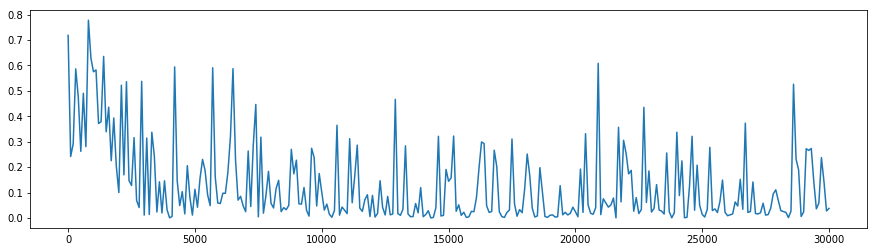

In [8]:
plt.figure().set_size_inches(15, 4)

plt.plot([n * summary_frequency for n in range(0, len(losses))], losses)
plt.show()